## General setup

In [ ]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torch
torch.cuda.is_available()

True

In [ ]:
import os
import subprocess
import torch

def get_least_used_cuda_device():
    try:
        # Query GPU memory usage via nvidia-smi
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=memory.used", "--format=csv,nounits,noheader"]
        )
        memory_used = [int(x) for x in result.decode("utf-8").strip().split("\n")]
        min_memory_gpu = memory_used.index(min(memory_used))
        return torch.device(f"cuda:{min_memory_gpu}")
    except Exception as e:
        print(f"❌ Could not query GPU usage: {e}")
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_least_used_cuda_device()
print(f"✅ Using device: {device}")

✅ Using device: cuda:0


In [4]:
from enum import Enum

class NodeOrder(Enum):
    DEG_DESC = "deg_desc"               # highest remaining deg first
    DEG_ASC = "deg_asc"                 # lowest remaining deg first
    RANDOM = "random"                   # reshuffle each call
    FIXED = "fixed"                     # visit 0,1,2,... in that order
    NEIGH_MIN_REM = "neigh_min_rem"     # neighbours of min-deg_rem node with smallest deg_rem first
    NEIGH_MAX_REM = "neigh_max_rem"     # neighbours of min-deg_rem node with largest deg_rem first
    ROUND_ROBIN = "round_robin"         # visit each node once, then wrap (start from the beginning)

## Input parameters

In [ ]:
import os
# Path to the directory where the data entries are
parent_directory = "data/cleaned"
include_dirs = ["6", "7", "8", "9", "10"]

absolute_path = "/home/nschmitz/GNNs/kirigami-database/"

directory_path = os.path.join(absolute_path, parent_directory)

amount_unfoldings = 3000
max_files_per_dir = 50
print(directory_path)

/home/nschmitz/GNNs/kirigami-database/data/cleaned


In [6]:
batch_size = 1
num_prop_rounds = 2

without_constraints = False
print("Model without constraints: ", without_constraints)

Model without constraints:  False


In [7]:
learning_rate = 0.00006 # 0.00003 for no constraints
accum_steps = 4
num_epochs = 50
training_node_ordering_strategy = NodeOrder.RANDOM

save_model_folder_name = "22__testing__" # Define prefix of save folder name
print("💿 Folder that model data gets saved into: ", save_model_folder_name)

💿 Folder that model data gets saved into:  22__testing__


In [8]:
add_edge_deterministic = True
add_edge_deterministic_threshold = 0.5
calc_pr_curves = False

In [9]:
print("Metrics---")
print("Amount unfoldings: ", amount_unfoldings)
print("Max files per dir: ", max_files_per_dir)
print("Batch size: ", batch_size)
print("Num prop rounds: ", num_prop_rounds)
print("Learning rate: ", learning_rate)
print("Num epochs: ", num_epochs)
print("Accum steps: ", accum_steps)
print("Training node ordering strategy: ", training_node_ordering_strategy)
print("Add edge is deterministic: ", add_edge_deterministic)
print("Add edge is deterministic threshold: ", add_edge_deterministic_threshold)
print("Calc PR-Curve: ", calc_pr_curves)
print("---------------")

Metrics---
Amount unfoldings:  3000
Max files per dir:  50
Batch size:  1
Num prop rounds:  2
Learning rate:  6e-05
Num epochs:  50
Accum steps:  4
Training node ordering strategy:  NodeOrder.RANDOM
Add edge is deterministic:  True
Add edge is deterministic threshold:  0.5
Calc PR-Curve:  False
---------------


## Model implementation

### Baseline model

In [ ]:
import copy
from typing import Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn.pytorch as dglnn

# ----------------------------- utils ---------------------------------

def all_unordered_pairs(N, device=None):
    """Return [2, P] with all (i<j) pairs."""
    idx = torch.arange(N, device=device)
    src = idx.repeat_interleave(N)
    dst = idx.repeat(N)
    mask = src < dst
    return torch.stack([src[mask], dst[mask]], dim=0)

def mask_existing_pairs(g, pairs):
    """
    Keep only candidate pairs that are NOT already connected (in either direction).
    Assumes g is made undirected via add_reverse_edges.
    """
    src, dst = pairs[0], pairs[1]
    exists_fwd = g.has_edges_between(src, dst)
    exists_bwd = g.has_edges_between(dst, src)
    keep = ~(exists_fwd | exists_bwd)
    return torch.stack([src[keep], dst[keep]], dim=0)

# -------------------------- building blocks ---------------------------

class NodeEncoder(nn.Module):
    """
    Two-layer GIN or GCN encoder over the *unfolded* graph edges, using g.ndata["hv"].
    """
    def __init__(self, in_dim, hidden_dim=128, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.conv1 = dglnn.GraphConv(in_dim, hidden_dim, norm="both", allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_dim, hidden_dim, norm="both", allow_zero_in_degree=True)


    def forward(self, g):
        x = g.ndata["hv"]
        h = self.conv1(g, x)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.dropout(h)
        return h

class SymmetricPairFeat(nn.Module):
    """Order-invariant pair features from node embeddings."""
    def forward(self, h, pairs):
        i, j = pairs[0], pairs[1]
        hi, hj = h[i], h[j]
        return torch.cat([hi + hj, (hi - hj).abs(), hi * hj], dim=-1)

class EdgeMLP(nn.Module):
    """Two-layer MLP mapping pair features to a scalar logit."""
    def __init__(self, hidden_dim=128, dropout=0.1):
        super().__init__()
        in_dim = 3 * hidden_dim
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
    def forward(self, pf):
        return self.net(pf).squeeze(-1)

# ---------------------------- main model ------------------------------

class BaselinePairwiseLPGraphBuilder(nn.Module):
    """
    Non-sequential baseline that:
      • uses g.ndata['hv'] as-is (your random features)
      • encodes over the unfolded graph edges
      • scores missing pairs in parallel
      • at eval, can also build & return a predicted graph (like your controller)
    Unified forward():
      - If pairs or all_pairs -> returns (logits, pairs) in train/eval.
      - If no pairs and eval() -> returns {'generated_graph': ..., ...}.
      - If no pairs and train() -> raises ValueError.
    """
    def __init__(self,
                 in_dim,
                 hidden_dim=128,
                 dropout=0.1,
                 edge_threshold=0.5,
                 update_deg_rem_on_infer=True):
        super().__init__()
        self.encoder = NodeEncoder(in_dim, hidden_dim, dropout)
        self.pair = SymmetricPairFeat()
        self.edge_mlp = EdgeMLP(hidden_dim, dropout)
        self.edge_threshold = float(edge_threshold)
        self.update_deg_rem_on_infer = bool(update_deg_rem_on_infer)

    def set_threshold(self, tau):
        self.edge_threshold = float(max(0.0, min(1.0, tau)))

    @torch.no_grad()
    def _infer_graph_from_embeddings(self, g, h):
        device = g.device
        N = g.num_nodes()

        cand = mask_existing_pairs(g, all_unordered_pairs(N, device=device))
        if cand.numel() == 0:
            return {"generated_graph": copy.deepcopy(g), "pred_actions": [], "pred_pairs": [], "edge_probs": []}

        logits = self.edge_mlp(self.pair(h, cand))
        probs = torch.sigmoid(logits)
        keep = probs >= self.edge_threshold
        add_pairs = cand[:, keep]
        add_probs = probs[keep]

        out = copy.deepcopy(g)
        if add_pairs.numel() > 0:
            s, d = add_pairs[0], add_pairs[1]
            out.add_edges(torch.cat([s, d], 0), torch.cat([d, s], 0))
            new_e = torch.ones((2 * s.numel(), 1), dtype=torch.float32, device=device)
            if "he" not in out.edata:
                out.edata["he"] = torch.ones((out.num_edges(), 1), dtype=torch.float32, device=device)
            else:
                start = out.num_edges() - new_e.size(0)
                out.edata["he"][start:] = new_e

            if self.update_deg_rem_on_infer and ("deg_rem" in out.ndata) and ("deg_target" in out.ndata):
                delta = torch.zeros((N, 1), dtype=out.ndata["deg_rem"].dtype, device=device)
                for i, j in zip(s.tolist(), d.tolist()):
                    delta[i] += 1
                    delta[j] += 1
                out.ndata["deg_rem"] = torch.maximum(out.ndata["deg_rem"] - delta,
                                                     torch.zeros_like(out.ndata["deg_rem"]))

        pred_actions = [(int(i), 1, int(j)) for i, j in zip(add_pairs[0].tolist(), add_pairs[1].tolist())]
        return {
            "generated_graph": out,
            "pred_actions": pred_actions,
            "pred_pairs": add_pairs,
            "edge_probs": add_probs.cpu().tolist()
        }

    def forward(self, g, pairs=None, all_pairs=False):
        h = self.encoder(g)

        # --- classification path: available in both train & eval ---
        if (pairs is not None) or all_pairs:
            if pairs is None:  # all_pairs=True
                pairs = mask_existing_pairs(g, all_unordered_pairs(g.num_nodes(), device=h.device))
            logits = self.edge_mlp(self.pair(h, pairs))
            return logits, pairs

        # --- inference path: only when evaluating and no pairs were provided ---
        if self.training:
            raise ValueError("Training requires candidate `pairs` (or set all_pairs=True).")
        # eval mode: build & return the predicted graph
        return self._infer_graph_from_embeddings(g, h)

    @torch.no_grad()
    def infer_graph(self, g):
        self.eval()
        h = self.encoder(g)
        return self._infer_graph_from_embeddings(g, h)

### FINE-GNN

In [ ]:
from enum import Enum
from functools import partial

import dgl
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import Bernoulli, Categorical
import copy
from collections import defaultdict, deque

def weights_init(m):
    """
    Code from https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
    Usage:
        model = Model()
        model.apply(weight_init)
    """
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)


def dgmg_message_weight_init(m):
    """
    This is similar as the function above where we initialize linear layers from a normal distribution with std
    1./10 as suggested by the author. This should only be used for the message passing functions, i.e. fe's in the
    paper.
    """

    def _weight_init(m):
        if isinstance(m, nn.Linear):
            init.normal_(m.weight.data, std=1.0 / 10)
            init.normal_(m.bias.data, std=1.0 / 10)
        else:
            raise ValueError("Expected the input to be of type nn.Linear!")

    if isinstance(m, nn.ModuleList):
        for layer in m:
            layer.apply(_weight_init)
    else:
        m.apply(_weight_init)


# --- Original version of model in Python
class GraphEmbed(nn.Module):
    def __init__(self, node_hidden_size):
        super(GraphEmbed, self).__init__()

        # Setting from the paper
        self.graph_hidden_size = 2 * node_hidden_size

        # Embed graphs
        self.node_gating = nn.Sequential(
            nn.Linear(node_hidden_size, 1), nn.Sigmoid()
        )
        self.node_to_graph = nn.Linear(node_hidden_size, self.graph_hidden_size)

    def forward(self, g):
        if g.num_nodes() == 0:
            return torch.zeros(1, self.graph_hidden_size)
        else:
            # Node features are stored as hv in ndata.
            hvs = g.ndata["hv"]
            return (self.node_gating(hvs) * self.node_to_graph(hvs)).sum(
                0, keepdim=True
            )


class GraphProp(nn.Module):
    def __init__(self, num_prop_rounds, node_hidden_size):
        super(GraphProp, self).__init__()

        self.num_prop_rounds = num_prop_rounds

        # Setting from the paper
        self.node_activation_hidden_size = 2 * node_hidden_size # needs to align with the activation size set in ndata["a"] for the input graphs!!!

        message_funcs = []
        self.reduce_funcs = []
        node_update_funcs = []

        for t in range(num_prop_rounds):
            # input being [hv, hu, xuv]
            message_funcs.append(
                nn.Linear(
                    2 * node_hidden_size + 1, self.node_activation_hidden_size
                )
            )

            self.reduce_funcs.append(partial(self.dgmg_reduce, round=t))
            node_update_funcs.append(
                nn.GRUCell(self.node_activation_hidden_size, node_hidden_size)
            )

        self.message_funcs = nn.ModuleList(message_funcs)
        self.node_update_funcs = nn.ModuleList(node_update_funcs)

    def dgmg_msg(self, edges):
        """For an edge u->v, return concat([h_u, x_uv])"""
        return {"m": torch.cat([edges.src["hv"], edges.data["he"]], dim=1)}

    def dgmg_reduce(self, nodes, round):
        hv_old = nodes.data["hv"]
        m = nodes.mailbox["m"]
        message = torch.cat(
            [hv_old.unsqueeze(1).expand(-1, m.size(1), -1), m], dim=2
        )
        node_activation = (self.message_funcs[round](message)).sum(1)

        return {"a": node_activation}

    def forward(self, g):
        if g.num_edges() == 0:
            return
        else:
            for t in range(self.num_prop_rounds):
                g.update_all(
                    message_func=self.dgmg_msg, reduce_func=self.reduce_funcs[t]
                )
                g.ndata["hv"] = self.node_update_funcs[t](
                    g.ndata["a"], g.ndata["hv"]
                )


def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)


class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size, edge_threshold = 0.5, deterministic = True, with_constraints = True):
        super(AddEdge, self).__init__()

        self.graph_op = {"embed": graph_embed_func}
        
        # Additional features count
        add_feature_count = 0
        
        if with_constraints:
            # Adding remaining budget (deg_rem) as extra input feature
            add_feature_count += 1
        
        self.add_edge = nn.Linear(
            graph_embed_func.graph_hidden_size + node_hidden_size + add_feature_count, 1
        )
        
        self.edge_threshold = edge_threshold
        self.deterministic = deterministic
        self.with_constraints = with_constraints
        
        # Track decisions/probabilities
        self.log_prob = []
        self.raw_probs = []
        self.predicted_actions = []

    def set_threshold(self, tau) -> None:
        """Set a new deterministic threshold τ (0 ≤ τ ≤ 1)."""
        self.edge_threshold = float(max(0.0, min(1.0, tau)))
        
    def reset_log_probabilities(self):
        self.log_prob = []
        
    def reset_tracking(self):
        """Clear all stored values (should be called at start of inference)."""
        self.log_prob = []
        self.raw_probs = []
        self.predicted_actions = []

    def forward(self, g, node_id, action=None, true_label=None, enable_tracking=False):
        
        if self.with_constraints:
            # ---------- HARD DEGREE MASK ----------
            if g.ndata["deg_rem"][node_id] == 0:
                # print("AddEdge Stop as deg_rem = 0: ")
                # must emit “stop”
                to_add_edge = False

                self.log_prob.append(torch.tensor([0.0], device=g.device))  # shape [1]
                if enable_tracking and not self.training:
                    self.raw_probs.append(0.0) # p(add) = 0
                    self.predicted_actions.append((node_id, 2)) # forced
                return False
        
        graph_embed = self.graph_op["embed"](g)
        src_embed = g.nodes[node_id].data["hv"]
        
        if self.with_constraints:
            # Additional feature:
            # Remaining allowed edges (reduces gradually)
            deg_rem = g.ndata["deg_rem"][node_id].float().view(1, 1) # use remaining allowed edges as features instead of amount of edges it already has => better for the model to learn as it gradually reduces and also before two nodes with the same current numner of edge connections were identical in that feature even if they had a different amount of remaining allowed edges
            # Adjusted probability calculation to also take into account remaining allowed edges
            logit = self.add_edge(torch.cat([graph_embed, src_embed, deg_rem], dim=1))
        else:
            logit = self.add_edge(torch.cat([graph_embed, src_embed], dim=1)) # => Normally without additional node features
            
        prob = torch.sigmoid(logit)

        # If no external decision given, sample one
        if not self.training and action is None:
            if self.deterministic:
                # print("AddEdge Prob item: ", prob.item())
                action = int(prob.item() >= self.edge_threshold) # fully deterministic option => would be better to use but needs threshold anaylsis to really define a good threshold for my task at hand => 0.5 is not good in respect to my dataset and task as negative edges dominate
            else:
                action = Bernoulli(prob).sample().item() # introduces randomness
                
        to_add_edge = bool(action == 1)

        # if self.training: => call both in training and inference so the log_probs can be used for evaluations
        sample_log_prob = bernoulli_action_log_prob(logit, action).view(1) # shape [1]
        self.log_prob.append(sample_log_prob)
        
        # Track additional data
        if enable_tracking and not self.training:
            self.raw_probs.append(prob.item())
            self.predicted_actions.append((node_id, int(to_add_edge)))

        return to_add_edge


class ChooseDestAndUpdate(nn.Module):
    def __init__(self, graph_prop_func, node_hidden_size, with_constraints=True):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {"prop": graph_prop_func}
        
        # Additional features count
        add_feature_count = 0
        
        if with_constraints:
            # Adding remaining budget (deg_rem) as extra input features (+ 2 in order to include source and destination node degree)
            add_feature_count += 2
        
        self.choose_dest = nn.Linear(2 * node_hidden_size + add_feature_count, 1)
        
        self.with_constraints = with_constraints
        
        # Tracking
        self.log_prob = []
        self.raw_probs = [] # Softmaxed probabilities
        self.dest_preds = [] # Chosen destination node indices
        self.possible_dests_list = [] # Candidate destination lists
        self.mask_degzero_list = [] # more detail list that contains elements of possible_dests_list that have degzero/ are already fully connected
        self.mask_existing_list = [] # more detail list that contains elements of possible_dests_list that have already a connection to the focus node
        self.predicted_pairs = [] # To store (src_id, predicted_dest)
        self.predicted_actions = [] # To store (src_id, 1, predicted_dest)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, we only add 1 to indicate its existence.
        edge_repr = torch.ones(len(src_list), 1, device=g.device)
        g.edges[src_list, dest_list].data["he"] = edge_repr

    def reset_log_probabilities(self):
        self.log_prob = []
        
    def reset_tracking(self):
        self.log_prob = []
        self.raw_probs = []
        self.dest_preds = []
        self.possible_dests_list = []
        self.mask_degzero_list = []
        self.mask_existing_list = []
        self.predicted_pairs = []
        self.predicted_actions = []

    def forward(self, g, src_id, true_dests, true_dest, enable_tracking=False):
        possible_dests = [i for i in range(g.num_nodes()) if i != src_id]
        
        # DEBUGGING: Ensure that `possible_dests` is not empty
        assert len(possible_dests) > 0, f"Error: No valid destinations for src_id {src_id}"

        src_embed = g.nodes[src_id].data["hv"]
        possible_dests_embed = g.nodes[possible_dests].data["hv"]

        # Expand source embedding to match possible destination embeddings
        src_embed_expand = src_embed.expand(len(possible_dests), -1)
        
        # Edges that already exist
        already_exists = g.has_edges_between(src_id, possible_dests)
        
        if self.with_constraints:
            # Feature: Use remaining budget instead of current degree -------
            src_rem  = g.ndata['deg_rem'][src_id].float().view(1,1).expand(len(possible_dests), -1)
            dest_rem = g.ndata['deg_rem'][possible_dests].float().view(-1,1)
            # Compute scores for each destination
            # Added source and destination remaining budget
            dests_scores = self.choose_dest(
                torch.cat([possible_dests_embed, src_embed_expand, dest_rem, src_rem], dim=1)
            ).view(1, -1)
            
            # Mask 1: 1 = still room, 0 = exhausted
            mask = (g.ndata['deg_rem'][possible_dests] > 0).squeeze(1)
            
            # Mask 2: don't make it possible to predict edges that already exist
            mask = mask & (~already_exists)
            
            dests_scores[0, ~mask] = -1e9
            # print("dests_scores: ", dests_scores)
        else:
            # No additional node features
            # Compute scores for each destination
            dests_scores = self.choose_dest(
                torch.cat([possible_dests_embed, src_embed_expand], dim=1)
            ).view(1, -1)
            
            dests_scores[0, already_exists] = -1e9 # forbid duplicates => so the model doesn't get stuck to always add more and more edges for the same connection
            mask = ~already_exists # keep a mask variable so tracking code in the end works
        
        # Early exit: if every candidate is illegal, stop here.
        if (dests_scores > -1e8).sum() == 0: # no legal remaining edges to add
            if self.training:
                raise RuntimeError(
                    "choose_dest_and_update() found no legal destination during training – "
                    "check the dataset for duplicates or masked-out GT edges."
                )
                self.log_prob.append(torch.tensor([0.0], device=g.device))
            return None

        dests_probs = F.softmax(dests_scores, dim=1)
        # print("ChooseDest Dests-Prob: ", dests_probs)

        if not self.training: # In inference mode
            # DEBUGGING: Ensure softmax outputs valid probabilities
            assert torch.all(dests_probs >= 0), "Error: Softmax probabilities must be non-negative."
        
        # Compute predicted destination even during training (for analysis purposes)
        # dest_index = Categorical(dests_probs).sample().item() => outdated as it samples a destination Randomly from the probability distribution
        pred_dest_index = torch.argmax(dests_probs, dim=1).item() # => Picks the destination with the highest probability; is deterministic
        pred_dest = possible_dests[pred_dest_index] # Map back to actual node index
        
        if self.training:
            # teacher-force on the slot’s true_dest
            used_dest = true_dest
            # Compute log-sum over all remaining true destinations
            # Build the index list of all remaining true destinations
            idxs = [possible_dests.index(d) for d in true_dests]
            
            if idxs:
                p_set = dests_probs[0, idxs].sum()
                logp_set = torch.log(p_set + 1e-8)
            else:
                # every remaining ground-truth dest got masked out ⇒ give neutral gradient
                logp_set = torch.tensor(0.0, device=g.device)

            self.log_prob.append(logp_set.view(1))
        else:
            if self.with_constraints:
                # If nothing is legal, stop
                if mask.sum() == 0:
                    return None
            
            # inference: pick highest-prob destination
            used_dest = pred_dest
            # print("ChooseDest src_id: ", src_id)
            # print("ChooseDest used_dest: ", used_dest)
            idx  = possible_dests.index(used_dest)
            logp = F.log_softmax(dests_scores, dim=1)[0, idx]
            self.log_prob.append(logp.view(1))
    
        # DEBUGGING: Ensure `dest` is a valid choice
        assert used_dest is not None and used_dest in possible_dests and used_dest != src_id, f"Error: Chosen dest {used_dest} is not a valid destination for src_id {src_id}."

        if enable_tracking and not self.training:
            legal_mask = (dests_scores[0] > -1e8)
            legal_cands = [d for d, m in zip(possible_dests, legal_mask) if m]
            present = [d for d in possible_dests if g.has_edges_between(src_id, d)]
            if self.with_constraints:
                closed = [d for d, m in zip(possible_dests, mask) if (not m) and (g.ndata['deg_rem'][d]==0) and d not in present]
            else:
                closed = []
            self.mask_existing_list.append(present)
            self.mask_degzero_list.append(closed)
            legal_probs = dests_probs[0, legal_mask].detach().cpu().tolist()
            self.raw_probs.append(legal_probs)
            self.dest_preds.append(pred_dest)
            self.possible_dests_list.append(legal_cands)
            self.predicted_pairs.append((src_id, pred_dest))
            self.predicted_actions.append((src_id, 1, pred_dest))
            
        # print("✅ Trying to at an edge between: ", src_id, used_dest)
        if not g.has_edges_between(src_id, used_dest):
            # For undirected graphs, we add edges for both directions
            # so that we can perform graph propagation.
            src_list = [src_id, used_dest]
            dest_list = [used_dest, src_id]
            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op["prop"](g)
            
            # Decrement remaining budget
            g.ndata['deg_rem'][src_id] -= 1
            g.ndata['deg_rem'][used_dest] -= 1
            
            if self.with_constraints:
                if (g.ndata['deg_rem'][src_id]  < 0) or (g.ndata['deg_rem'][used_dest] < 0):
                    msg = (f"[WARN] deg_rem became negative after edge ({src_id} → {used_dest})"
                        + (f"  | true_dest={true_dest}" if self.training else ""))
                    print(msg)
        # else:
        #     print("Already exist an edge between: ", src_id, used_dest)

        # 6) Consume this slot’s true_dest so future slots see the smaller set
        if self.training and true_dest in true_dests:
            true_dests.remove(true_dest)
            
        return pred_dest # important: is not used_dest but always pred_dest


class FINE_GNN(nn.Module):
    def __init__(self, node_hidden_size, num_prop_rounds, enable_tracking=False, edge_threshold = 0.5, deterministic = True, with_constraints = True, order_strategy=NodeOrder.RANDOM):
        super(FINE_GNN, self).__init__()
        self.step_count = 0
        self.pointer_round_robin = -1
        self.node_hidden_size = node_hidden_size
        self.num_prop_rounds = num_prop_rounds
        self.enable_tracking = enable_tracking
        self.with_constraints = with_constraints
        print("Controller-Model with constraints config: ", self.with_constraints)
        
        # Node ordering strategy
        self.order_strategy = order_strategy
                
        print("DGMG-Model node ordering strategy: ", self.order_strategy)

        # Graph embedding module
        self.graph_embed = GraphEmbed(node_hidden_size)

        # Graph propagation module
        self.graph_prop = GraphProp(num_prop_rounds, node_hidden_size)

        # Actions
        self.add_edge_agent = AddEdge(self.graph_embed, node_hidden_size, edge_threshold=edge_threshold, deterministic=deterministic, with_constraints=self.with_constraints)
        self.choose_dest_agent = ChooseDestAndUpdate(
            self.graph_prop, node_hidden_size, with_constraints=self.with_constraints
        )

        # Weight initialization
        self.init_weights()
        
        # For debugging
        self.total_mismatches = 0
        self.predicted_in_other_slot_count = 0
        
        self.counter_node_order_strategy_used_total = 0
        self.counter_neigh_order_strategy_fallback = 0
        self.counter_node_order_strategy_used_total_by_facecount = defaultdict(int)
        self.counter_neigh_fallback_by_facecount = defaultdict(int)

    def init_weights(self):
        self.graph_embed.apply(weights_init)
        self.graph_prop.apply(weights_init)
        self.add_edge_agent.apply(weights_init)
        self.choose_dest_agent.apply(weights_init)

        self.graph_prop.message_funcs.apply(dgmg_message_weight_init)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def set_threshold(self, tau):
        """Update τ after training for grid‑search calibration."""
        self.add_edge_agent.set_threshold(tau)
    
    def reset_log_probabilities(self):
        self.step_count = 0
        self.pointer_round_robin = -1

        self.add_edge_agent.reset_log_probabilities()
        self.choose_dest_agent.reset_log_probabilities()
        
    def reset_mismatch_stats(self):
        self.total_mismatches = 0
        self.predicted_in_other_slot_count = 0
        
    def _node_score(self, g):
        if not self.with_constraints and self.order_strategy in {
            NodeOrder.DEG_ASC, NodeOrder.DEG_DESC, NodeOrder.NEIGH_MIN_REM, NodeOrder.NEIGH_MAX_REM
        }:
            raise ValueError("deg_rem-based strategies require with_constraints=True")
        
        self.counter_node_order_strategy_used_total += 1
        N = int(g.num_nodes())
        self.counter_node_order_strategy_used_total_by_facecount[N] += 1
        
        if self.order_strategy == NodeOrder.DEG_DESC:
            base = g.ndata['deg_rem'].float().squeeze(1)
        elif self.order_strategy == NodeOrder.DEG_ASC:
            base = -g.ndata['deg_rem'].float().squeeze(1)
        elif self.order_strategy == NodeOrder.RANDOM:
            base = torch.rand(g.num_nodes(), device=g.device)
        elif self.order_strategy == NodeOrder.FIXED:
            base = -torch.arange(g.num_nodes(), device=g.device).float() # negated so when calling torch.argmax(scores).item() to select the next node node 0 is largest, then 1, 2, ...
        elif self.order_strategy == NodeOrder.ROUND_ROBIN:
            n = g.num_nodes()
            # next starting index
            start = (self.pointer_round_robin + 1) % n
            order = torch.cat([
                torch.arange(start, n, device=g.device),
                torch.arange(0, start, device=g.device)
            ])
            # Highest score for first in order, decreasing afterwards
            base = torch.empty(n, device=g.device, dtype=torch.float)
            # e.g. if n=6: scores 5,4,3,2,1,0
            base[order] = torch.arange(n-1, -1, -1, device=g.device, dtype=torch.float)
        elif self.order_strategy in {NodeOrder.NEIGH_MIN_REM,
                             NodeOrder.NEIGH_MAX_REM}:
            # Gather current per-node budgets
            dr = g.ndata['deg_rem'].float().squeeze(1)
            # Identify the most-closed node(s)
            min_rem = dr.min()
            anchors = (dr == min_rem).nonzero(as_tuple=True)[0]

            # Build a boolean mask that says True for a node that is a direct neighbour of any saturated node
            neigh_mask = torch.zeros_like(dr, dtype=torch.bool)
            for s in anchors.tolist():
                neigh_mask[g.successors(s)] = True # Mark every node reachable by an outgoing edge from s
                neigh_mask[g.predecessors(s)] = True # Mark every node that has an incoming edge to s => redundant for undirected graphs but harmless
            
            # don’t include the anchors themselves
            # neigh_mask[anchors] = False
            neigh_mask &= (dr > 0) # keep only nodes that are not fully closed yet

            # If no valid, unfinished neighbours exist, fall back to simple DEG_DESC.
            if neigh_mask.sum() == 0:
                self.counter_neigh_order_strategy_fallback += 1
                self.counter_neigh_fallback_by_facecount[N] += 1
                base = torch.rand(g.num_nodes(), device=g.device) # same as RANDOM strategy
                
            else:
                base = torch.full_like(dr, -1e9)
                if self.order_strategy == NodeOrder.NEIGH_MIN_REM:
                    base[neigh_mask] = -dr[neigh_mask] # choose the neighbour that is closest to saturation
                else:  # SAT_NEIGH_DESC
                    base[neigh_mask] =  dr[neigh_mask] # choose the neighbour that is still far from saturation
        else:
            raise ValueError(f"unknown strategy {self.order_strategy}")
    
        # --- deterministic tie-breaker: subtract 1e-6 · node_id -------------
        #   (smaller id ⇒ slightly *higher* effective score in argmax)
        eps = 1e-6 * torch.arange(g.num_nodes(), device=g.device).float()
        return base - eps

    def add_edge_or_not(self, node_id, edge_decision):
        """Decide if an edge should be added for the given node."""
        return self.add_edge_agent(self.g, node_id, edge_decision, enable_tracking=self.enable_tracking)

    def choose_dest_and_update(self, src_id, remaining_true_dests, true_dest):
        """Choose destination and update the graph for a given source node."""
        return self.choose_dest_agent(self.g, src_id, remaining_true_dests, true_dest, enable_tracking=self.enable_tracking)

    def get_log_prob(self):
        # Ensure we don't accumulate old values
        if self.add_edge_agent.log_prob and self.choose_dest_agent.log_prob:
            total_log_prob = (
                torch.cat(self.add_edge_agent.log_prob).sum()
                + torch.cat(self.choose_dest_agent.log_prob).sum()
            )
            # print("Log prob general:", total_log_prob)
            return total_log_prob
        else:
            return torch.tensor(0.0, device=self.g.device)

    def forward_train(self, actions):
        self.reset_log_probabilities()
        
        # print("\n=== START training ===")
        # print("initial deg_rem:", self.g.ndata['deg_rem'].squeeze(1).tolist())

        # ------------------ 1. build per-node ground-truth queues -----------------
        gt_by_node = defaultdict(deque)      # src → deque([dest₁, dest₂, …])
        for src, flag, dst in actions:
            if flag == 1 and dst is not None: # build per-node ground-truth queues symmetrically
                gt_by_node[src].append(dst)
                gt_by_node[dst].append(src)

        # ------------------ 2. bookkeeping ------------------------------
        done = torch.zeros(self.g.num_nodes(), dtype=torch.bool,
                                    device=self.g.device)
        # mark nodes that are already fully closed before the loop starts
        if self.with_constraints:
            done |= (self.g.ndata['deg_rem'].squeeze(1) == 0)
            
        batch_mismatch = 0
        batch_otherpos = 0 # Track Soft-order errors (the edge is correct for this node, just produced in the “wrong” slot relative to the teacher order) but either way there is no punishment for the model if that happens. The model treats every still-unconnected ground-truth destination as equally acceptable, so the gradient is identical whether the model picks the teacher-forced true_dest or another still-valid one

        # ------------------ 3. dynamic loop ------------------------------
        while not done.all():

            # 3-a  pick next focus node via the chosen strategy
            scores = self._node_score(self.g).clone()
            scores[done] = -1e9 # mask finished nodes
            
            order = torch.argsort(scores, descending=True).tolist()
            # print("Order: ", order)
            src = torch.argmax(scores).item()
            # print("Picked src: ", src)
            
            if self.order_strategy == NodeOrder.ROUND_ROBIN:
                self.pointer_round_robin = src

            # 3-b  decide ADD / STOP
            add_edge = self.add_edge_or_not(src,
                                            edge_decision = int(bool(gt_by_node[src]))) # if queue of gt_by_node[src] is empty: edge_decision=0
            if not add_edge:
                done[src] = True
                continue

            # 3-c  --- there *is* at least one ground-truth dest left ---------------
            true_dest = gt_by_node[src][0] # peek
            remaining = list(gt_by_node[src]) # full current queue

            pred_dest = self.choose_dest_and_update(src,
                                                    remaining_true_dests = remaining,
                                                    true_dest = true_dest)

            # mismatch accounting (debugging)
            if pred_dest not in {true_dest, *remaining}:
                batch_mismatch += 1
            elif pred_dest != true_dest:
                batch_otherpos += 1

            # consume this slot
            gt_by_node[src].popleft()
            # Update also dst node list to keep the queue consistent
            try:
                gt_by_node[true_dest].remove(src) # drop the mirror entry
            except ValueError:
                pass # it was already gone
            
            # Set nodes to done if it can't receive more connections => not needed as either way stop would be triggered in the next time it gets selected but avoids unnecessary runtime addition
            if self.with_constraints:
                if self.g.ndata['deg_rem'][src] == 0:
                    done[src] = True
                if self.g.ndata['deg_rem'][true_dest] == 0:
                    done[true_dest] = True

        # accumulate stats
        self.total_mismatches += batch_mismatch
        self.predicted_in_other_slot_count += batch_otherpos
        
        # print("\n=== END training ===")

        return self.get_log_prob()

    def forward_inference(self):
        self.reset_log_probabilities()
        self.add_edge_agent.reset_tracking()
        self.choose_dest_agent.reset_tracking()
        
        focus_node_sequence = [] # record the focus sequence
        
        done = torch.zeros(self.g.num_nodes(), dtype=torch.bool, device=self.g.device)
        # mark nodes that are already fully closed before the loop starts
        if self.with_constraints:
            done |= (self.g.ndata['deg_rem'].squeeze(1) == 0)
        
        # print("\n=== START inference ===")
        # print("initial deg_rem:", self.g.ndata['deg_rem'].squeeze(1).tolist())
        
        step = 0
        initial_order = None
        initial_order_after_masking = None
        while True:
            # ---------- choose next focus node -----------------------------
            scores = self._node_score(self.g).clone() # strategy-specific scores
            
            # --- snapshot the very first 'order' before masking done nodes out --------------------------
            if initial_order is None: # happens only once
                init_order = torch.argsort(scores, descending=True).tolist()
                initial_order = init_order.copy()
                
            scores[done] = -1e9 # mask out finished nodes
            order = torch.argsort(scores, descending=True).tolist()
            src = order[0]
            focus_node_sequence.append(src)
            if self.order_strategy == NodeOrder.ROUND_ROBIN:
                self.pointer_round_robin = src
            
            # --- snapshot the very first 'order' after masking done nodes out --------------------------
            if initial_order_after_masking is None: # happens only once
                initial_order_after_masking = order.copy() # keep a _separate_ list object
            
            if scores[src] == -1e9: # nothing selectable
                # print("No selectable nodes left — stopping.")
                break
            
            '''
            print(f"\n--- step {step} ------------------------------------------------")
            print("deg_rem :", self.g.ndata['deg_rem'].squeeze(1).tolist())
            print("scores  :", scores.tolist())
            print("order   :", order)
            print(f"picked  : node {src}")
            '''
            step += 1

            # ---------- AddEdge decision -----------------------------------
            add_edge = self.add_edge_or_not(src, None)
            # print("decision:", "ADD edge" if add_edge else "STOP")
            
            if not add_edge:
                done[src] = True # never visit src again
                continue

            # ---------- choose destination & update ------------------------
            dest = self.choose_dest_and_update(src, None, None)
            if dest is None: # no legal dests
                # print("→ no legal destination; mark done.")
                done[src] = True
                continue
            
            # Set nodes to done if it can't receive more connections => not needed as either way stop would be triggered in the next time it gets selected but avoids unnecessary runtime addition
            if self.with_constraints:
                if self.g.ndata['deg_rem'][src] == 0:
                    done[src] = True
                if self.g.ndata['deg_rem'][dest] == 0:
                    done[dest] = True
            
        # print("\n=== END inference ===")
        
        return {
            "generated_graph": self.g,
            "focus_node_sequence": focus_node_sequence,
            "log_prob": self.get_log_prob(),
            "add_edge_probs": self.add_edge_agent.raw_probs,
            "add_edge_preds": self.add_edge_agent.predicted_actions,
            "dest_probs": self.choose_dest_agent.raw_probs,
            "dest_preds": self.choose_dest_agent.dest_preds,
            "dest_candidates": self.choose_dest_agent.possible_dests_list,
            "dest_candidates_mask_degzero": self.choose_dest_agent.mask_degzero_list,
            "dest_candidates_mask_existing": self.choose_dest_agent.mask_existing_list,
            "pred_dest_pairs": self.choose_dest_agent.predicted_pairs,
            "pred_actions": self.choose_dest_agent.predicted_actions,
            "initial_order": initial_order,
            "initial_order_after_masking": initial_order_after_masking
        }

    def forward(self, g, actions=None, enable_tracking=None):
        self.g = copy.deepcopy(g)  # Clone and use the provided graph instead of initializing a new one
    
        if enable_tracking is not None:
            self.enable_tracking = enable_tracking
        assert self.g.device == self.add_edge_agent.add_edge.weight.device

        if self.training:
            return self.forward_train(actions)
        else:
            return self.forward_inference()

## Dataset preparation

In [15]:
import os
import json
import dgl
import torch
from dgl.data import DGLDataset
import random

def generate_node_features(num_nodes, dim):
    return F.normalize(torch.randn(num_nodes, dim), p=2, dim=1)

class PolyhedraGraphDataset(DGLDataset):
    def __init__(self, parent_directory, amount_unfoldings_per_file = 1000, max_files_per_dir = 100000, use_random_files = False, include_dirs=None):
        self.parent_directory = parent_directory  # Parent directory containing JSON files
        self.amount_unfoldings_per_file = amount_unfoldings_per_file # Defines how many unfolded states should be taken from each entry
        self.max_files_per_dir = max_files_per_dir
        self.max_dim_nfeats = 0
        self.use_random_files = use_random_files
        self.include_dirs = include_dirs # Can be None or a list of allowed subfolder names
        super().__init__(name="polyhedra_graph_dataset")

    def process(self):
        self.unfolded_graphs = []
        self.folded_graphs = []  # Store the folded version as ground truth
        self.actions = []  # Store actions instead of class labels
        self.unfolded_states = [] # Store unfolded state of each graph for debugging
        self.source_files = [] # Store the filenames of the folded graphs for debug purposes
        counter = 1
        check_counter = 0

        # First, process any JSON files directly in self.parent_directory
        if self.use_random_files:
            top_level_json_files = [f for f in os.listdir(self.parent_directory) if f.endswith('.json')]
            random.shuffle(top_level_json_files)
        else:
            top_level_json_files = sorted([f for f in os.listdir(self.parent_directory) if f.endswith('.json')]
                                          )
        # Process each JSON file directly under parent_directory
        for filename in top_level_json_files:
            if counter > self.max_files_per_dir:
                break
            file_path = os.path.join(self.parent_directory, filename)
            print("Processing top-level JSON file:", file_path)
            self._process_json_file(file_path, counter)
            counter += 1

        # Iterate over each subdirectory in the parent directory
        for subfolder in os.listdir(self.parent_directory):
            subfolder_path = os.path.join(self.parent_directory, subfolder)
            
            # Only process folders in include_dirs (if defined)
            if self.include_dirs is not None and subfolder not in self.include_dirs:
                print(f"Skipping non-included directory: {subfolder}")
                continue
            
            # print("Processing folder:", subfolder_path)
            if os.path.isdir(subfolder_path):
                
                if self.use_random_files:
                    json_files = [f for f in os.listdir(subfolder_path) if f.endswith('.json')]
                    random.shuffle(json_files)
                else:
                    json_files = sorted([f for f in os.listdir(subfolder_path) if f.endswith('.json')])
                print(f"Found {len(json_files)} JSON files in {subfolder}")
                
                # 🔄 Reset counter per subfolder
                counter = 1

                # Process each JSON file in the current subfolder
                for filename in json_files:
                    if counter > self.max_files_per_dir:
                        break
                    file_path = os.path.join(subfolder_path, filename)
                    self._process_json_file(file_path, counter)
                    counter += 1

        print(f"Processed {counter - 1} data files with total of {len(self.unfolded_graphs)} processed graphs.")

    def _process_json_file(self, file_path, counter):
        # Load the JSON data
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Extract and sort adjacent_faces by the source node (first entry in each edge)
        adjacent_faces = sorted(data["data"]["adjacent_faces"], key=lambda x: x[0])
        unfolded_states = data["data"]["unfolded_states"]

        random.shuffle(unfolded_states)

        # Check if there are enough elements
        # if len(unfolded_states) < self.amount_unfoldings_per_file:
            # print(f"Hey, there are not enough elements in file {file_path}! Only {len(unfolded_states)} elements available.")

        # Slice the list to get as many as possible
        unfolded_states = unfolded_states[:min(self.amount_unfoldings_per_file, len(unfolded_states))]
        # print(len(unfolded_states))

        # Calculate node degrees from the closed structure
        node_degree_count = {}
        for edge in adjacent_faces:
            for node in edge:  # Each edge has a source and destination
                if node not in node_degree_count:
                    node_degree_count[node] = 0
                node_degree_count[node] += 1

        # Convert the degrees to a list where the index corresponds to the node ID
        # Assuming node IDs are consecutive integers starting from 0
        num_nodes = len(node_degree_count)
        node_degrees = [node_degree_count.get(node, 0) for node in range(num_nodes)]

        # Use fixed node features
        # Convert node degrees to a tensor
        # node_features = torch.tensor(node_degrees, dtype=torch.float32).unsqueeze(1)  # Shape: [num_nodes, 1]
        # Store number of node features per node
        # self.max_dim_nfeats = max(node_features.shape[1], self.max_dim_nfeats)  # Number of features per node
        
        # Target degree tensor  (shape [num_nodes, 1]) => to use as constraint in model
        deg_target = torch.tensor(node_degrees, dtype=torch.int16).unsqueeze(1)
        
        # Use random node features
        node_feature_dim = 128
        
        folded_graph_node_features = generate_node_features(num_nodes, node_feature_dim)
        # Store number of node features per node
        self.max_dim_nfeats = max(node_feature_dim, self.max_dim_nfeats)

        # Create folded graph (ground truth)
        folded_src_nodes, folded_dst_nodes = zip(*adjacent_faces) if adjacent_faces else ([], [])
        folded_graph = dgl.graph((folded_src_nodes, folded_dst_nodes), num_nodes=num_nodes)
        folded_graph = dgl.add_reverse_edges(folded_graph)
        folded_graph.ndata["hv"] = folded_graph_node_features
        folded_graph.ndata['deg_target'] = deg_target
        
        source_filename = data["data"]["source_filename"]

        # Create graphs for each unfolded state
        for state in unfolded_states:
            unfolded_edges = sorted(state["unfolded_adjacent_faces"], key=lambda x: x[0])

            # Create initial graph from unfolded state
            src_nodes, dst_nodes = zip(*unfolded_edges) if unfolded_edges else ([], [])
    
            graph = dgl.graph((src_nodes, dst_nodes), num_nodes=num_nodes)

            # Add reverse edges so every node has in-degree edges
            graph = dgl.add_reverse_edges(graph)
            
            # Store target & remaining budget
            graph.ndata["deg_target"] = deg_target.clone()
            graph.ndata["deg_rem"] = (deg_target - graph.in_degrees().view(-1,1).to(torch.int16))
            
            unfolded_graph_node_features = generate_node_features(num_nodes, node_feature_dim)

            # Add node features (node degree from closed structure)
            graph.ndata["hv"] = unfolded_graph_node_features

            # Initialize node activations
            graph.ndata["a"] = torch.zeros((num_nodes, 2 * unfolded_graph_node_features.shape[1]), dtype=torch.float32)

            # Initialize edge features
            graph.edata["he"] = torch.ones((graph.num_edges(), 1), dtype=torch.float32)

            # Compute edges to add (difference between folded and unfolded)
            unfolded_set = set(tuple(edge) for edge in unfolded_edges)
            folded_set = set(tuple(edge) for edge in adjacent_faces)
            edges_to_add = sorted(list(folded_set - unfolded_set), key=lambda x: x[0])

            # Generate action sequence
            action_sequence = []
            added_edges = {focus: [] for focus in range(num_nodes)}

            for edge in edges_to_add:
                focus_node, dest_node = edge
                # Store the destination nodes for the focus node
                added_edges[focus_node].append(dest_node)

            for focus_node in range(num_nodes):
                # Step 1: Add all necessary edges for the focus node
                for dest in added_edges[focus_node]:
                    action_sequence.append((focus_node, 1, dest))  # Add edge

                # Step 2: Explicit stop signal (no destination needed)
                action_sequence.append((focus_node, 0, None))  # Stop adding edges

            # Store graph and action sequence
            self.unfolded_graphs.append(graph)
            self.folded_graphs.append(folded_graph)
            self.actions.append(action_sequence)
            self.unfolded_states.append(unfolded_edges)
            self.source_files.append(source_filename)

    def __getitem__(self, idx):
        return (
            self.unfolded_graphs[idx],
            self.folded_graphs[idx],
            self.actions[idx],
            self.unfolded_states[idx],
            self.source_files[idx]
        )

    def __len__(self):
        return len(self.unfolded_graphs)

### Saving the data

In [ ]:
# Save the prepared data to Google Drive
import dgl
import torch

relative_path = parent_directory.strip("/") # 2) Clean up leading/trailing slashes
dir_name = "_".join(include_dirs)
print(dir_name)

save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedDatasets/" # Replace with your absolute path

save_path_unfolded_graphs = save_directory + f"polyhedra_graph_dataset_unfolded_graphs-" \
                    f"path={dir_name}-" \
                    f"n={amount_unfoldings}-" \
                    f"mf={max_files_per_dir}.dgl"

save_path_folded_graphs = save_directory + f"polyhedra_graph_dataset_folded_graphs-" \
                  f"path={dir_name}-" \
                  f"n={amount_unfoldings}-" \
                  f"mf={max_files_per_dir}.dgl"

save_path_metadata = save_directory + f"polyhedra_graph_dataset_metadata-" \
                    f"path={dir_name}-" \
                    f"n={amount_unfoldings}-" \
                    f"mf={max_files_per_dir}.pt"

# only save if any of the files is missing
if not (
    os.path.exists(save_path_unfolded_graphs)
    and os.path.exists(save_path_folded_graphs)
    and os.path.exists(save_path_metadata)
):
    # Create the dataset
    dataset = PolyhedraGraphDataset(directory_path, amount_unfoldings, max_files_per_dir=max_files_per_dir, use_random_files=True, include_dirs=include_dirs)
    print("Saving new dataset…")
    # Save the graphs
    dgl.data.utils.save_graphs(save_path_unfolded_graphs, dataset.unfolded_graphs)
    dgl.data.utils.save_graphs(save_path_folded_graphs, dataset.folded_graphs)

    # Save the action sequences and other metadata separately
    metadata = {
        "actions": dataset.actions,
        "max_dim_nfeats": dataset.max_dim_nfeats,
        "source_files": dataset.source_files
    }
    torch.save(metadata, save_path_metadata)

    print("Dataset successfully saved!")
else:
    print("Found existing dataset files; skipping save.")

6_7_8_9_10
Found existing dataset files; skipping save.


### Loading the data

In [ ]:
import dgl
import torch
from torch.utils.data import Dataset

print("Loading dataset from disk…")
relative_path = parent_directory.strip("/") # 2) Clean up leading/trailing slashes
dir_name = "_".join(include_dirs)
print(dir_name)

save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedDatasets/" # Replace with your absolute path

load_path_unfolded_graphs = save_directory + f"polyhedra_graph_dataset_unfolded_graphs-" \
                    f"path={dir_name}-" \
                    f"n={amount_unfoldings}-" \
                    f"mf={max_files_per_dir}.dgl"

load_path_folded_graphs = save_directory + f"polyhedra_graph_dataset_folded_graphs-" \
                  f"path={dir_name}-" \
                  f"n={amount_unfoldings}-" \
                  f"mf={max_files_per_dir}.dgl"

load_path_metadata = save_directory + f"polyhedra_graph_dataset_metadata-" \
                    f"path={dir_name}-" \
                    f"n={amount_unfoldings}-" \
                    f"mf={max_files_per_dir}.pt"

# Load the dataset
unfolded_graph_list, _ = dgl.data.utils.load_graphs(load_path_unfolded_graphs)
folded_graph_list, _ = dgl.data.utils.load_graphs(load_path_folded_graphs)
metadata = torch.load(load_path_metadata)
actions = metadata["actions"]
max_dim_nfeats = metadata["max_dim_nfeats"]
source_files = metadata["source_files"]

# Create a dataset-like object
class PolyhedraGraphDatasetLoaded(Dataset):
    def __init__(self, unfolded_graphs, folded_graphs, actions, max_dim_nfeats, source_files):
        self.unfolded_graphs = unfolded_graphs
        self.folded_graphs = folded_graphs
        self.actions = actions
        self.max_dim_nfeats = max_dim_nfeats
        self.source_files = source_files
        print("Max amount of features per node in a graph: ", self.max_dim_nfeats)

    def pad_node_features(self, node_features):
        """Pads node features to max_dim_nfeats to ensure uniform input size."""
        current_size = node_features.shape[1]  # Num of features per node
        if current_size < self.max_dim_nfeats:
            padding = torch.zeros(node_features.shape[0], self.max_dim_nfeats - current_size)
            return torch.cat([node_features, padding], dim=1)
        return node_features

    def preprocess_graphs(self):
        """Pads all graphs in the dataset before training."""
        for graph in self.unfolded_graphs:
            graph.ndata["hv"] = self.pad_node_features(graph.ndata["hv"])
            graph.ndata["a"] = torch.zeros((graph.ndata["hv"].size(dim=0), 2 * max_dim_nfeats), dtype=torch.float32)
            
    # helper to recover the file name when you need it
    def get_source_file(self, idx):
        return self.source_files[idx]
    
    def get_idxs_for_source_file(self, source_file):
        return [i for i, sf in enumerate(self.source_files) if sf == source_file]
        

    def __getitem__(self, idx):
        return self.unfolded_graphs[idx], self.folded_graphs[idx], self.actions[idx], idx

    def __len__(self):
        return len(self.unfolded_graphs)

# Load into a dataset object
dataset = PolyhedraGraphDatasetLoaded(unfolded_graph_list, folded_graph_list, actions, max_dim_nfeats, source_files)
dataset.preprocess_graphs()

print(f"Loaded {len(dataset)} graphs with actions!")


Loading dataset from disk…
6_7_8_9_10


/tmp/ipykernel_1571428/1440860869.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metadata = torch.load(load_path_metadata)


Max amount of features per node in a graph:  128
Loaded 46571 graphs with actions!


### Splitting the data

In [18]:
import torch
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from dgl.dataloading import GraphDataLoader

# Set seed for reproducability
np.random.seed(42)

# Get total number of examples
num_examples = len(dataset)

# Define split sizes
num_train = int(num_examples * 0.7)
num_val = int(num_examples * 0.15)
num_test = num_examples - num_train - num_val  # Ensures all examples are used

# Generate shuffled indices
indices = np.random.permutation(num_examples)

# Split into train, validation, and test sets
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]
test_indices = indices[num_train + num_val:]

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define collate function to correctly batch graphs & actions
def collate_fn(batch):
    unfolded_graphs, folded_graphs, actions, idxs = zip(*batch)  # Unzip batch elements

    batched_unfolded_graph = dgl.batch(unfolded_graphs)  # Batch the unfolded graphs
    batched_folded_graphs = dgl.batch(folded_graphs)  # Batch the folded graphs (true labels)

    return batched_unfolded_graph, batched_folded_graphs, actions, idxs  # Return both batched graphs together with actions array

# Create dataloaders
train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=batch_size, drop_last=False, collate_fn=collate_fn, num_workers=6
)
val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=batch_size, drop_last=False, collate_fn=collate_fn, num_workers=0
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=batch_size, drop_last=False, collate_fn=collate_fn, num_workers=0
)
# Print sizes for verification
print(f"Train size: {num_train}, Validation size: {num_val}, Test size: {num_test}")

Train size: 32599, Validation size: 6985, Test size: 6987


## Evaluation methods

In [19]:
import time
import torch
import networkx as nx
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

def adjacency_matrix_from_dgl(graph, as_numpy=True):
    """Manually construct the adjacency matrix from a DGL graph."""
    num_nodes = graph.num_nodes()

    # Get edges (source and destination nodes)
    src, dst = graph.edges()

    # Initialize adjacency matrix with zeros
    adj_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)

    # Fill the adjacency matrix (assuming an undirected graph)
    adj_matrix[src, dst] = 1
    adj_matrix[dst, src] = 1  # Include reverse edges for undirected graphs

    return adj_matrix.numpy() if as_numpy else adj_matrix  # Convert to NumPy if needed

def compute_graph_metrics(pred_graph, unfolded_graph, true_graph, include_ged=True):
    """Compute F1-Score, ROC-AUC, Structural Similarity Score (SSS), and Graph Edit Distance (GED)
    while explicitly accounting for false positives (extra edges).
    """

    # Start time for total computation
    # total_start_time = time.time()
    
    # Move to CPU to ensure compatibility
    pred_graph = pred_graph.cpu()
    unfolded_graph = unfolded_graph.cpu()
    true_graph = true_graph.cpu()

    # Get adjacency matrices
    A_pred = adjacency_matrix_from_dgl(pred_graph, as_numpy=False)  # Model's prediction
    A_unfolded = adjacency_matrix_from_dgl(unfolded_graph, as_numpy=False)  # Initial input graph
    A_true = adjacency_matrix_from_dgl(true_graph, as_numpy=False)  # Ground truth folded graph

    # Identify missing edges (edges in true graph but NOT in the unfolded graph)
    missing_edges = torch.nonzero((A_true - A_unfolded) > 0, as_tuple=False)
    # Identify false positive edges (edges predicted by model that should NOT exist)
    false_positive_edges = torch.nonzero((A_pred == 1) & (A_true == 0), as_tuple=False)
    # Identify non-existing edges (edges absent in both true and unfolded graphs)
    non_existing_edges = torch.nonzero((A_true == 0) & (A_unfolded == 0), as_tuple=False)

    # Use all false positives + a proportion of missing edges and negative edges
    num_missing_edges = len(missing_edges)
    num_false_positives = len(false_positive_edges)

    # Select negative samples (make sure we consider false positives explicitly)
    negative_sample_size = min(len(non_existing_edges), num_missing_edges * 2)
    # sampled_negative_edges = non_existing_edges[np.random.choice(len(non_existing_edges), negative_sample_size, replace=False)]
    # sampled_indices = torch.multinomial(torch.ones(non_existing_edges.shape[0], dtype=torch.float), negative_sample_size, replacement=False) # better performance
    # sampled_negative_edges = non_existing_edges[sampled_indices] # better performance
    perm = torch.randperm(non_existing_edges.shape[0])[:negative_sample_size]
    sampled_negative_edges = non_existing_edges[perm]

    # Combine all samples for evaluation
    sampled_indices = torch.cat((missing_edges, sampled_negative_edges, false_positive_edges), dim=0)

    # Create y_true and y_pred with explicit false positive handling
    y_true = A_true[sampled_indices[:, 0], sampled_indices[:, 1]].view(-1)  # True labels
    y_pred = A_pred[sampled_indices[:, 0], sampled_indices[:, 1]].view(-1)  # Model's prediction

    # Time taken until y_true and y_pred are ready
    # prep_time = time.time() - total_start_time
    # print(f"[Time Log] Data preparation (until y_true & y_pred): {prep_time:.4f} sec")

    '''
    print("Balanced y_pred:")
    print(y_pred)
    print("Balanced y_true:")
    print(y_true)
    print("------")
    '''


    # Compute F1 Score
    # f1_start_time = time.time()
    f1 = f1_score(y_true, y_pred, average="binary")
    # f1_time = time.time() - f1_start_time
    # print(f"[Time Log] F1 Score computation: {f1_time:.4f} sec")

    # Compute ROC-AUC score
    # roc_auc_start_time = time.time()
    try:
        roc_auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        roc_auc = float("nan")
    # roc_auc_time = time.time() - roc_auc_start_time
    # print(f"[Time Log] ROC-AUC Score computation: {roc_auc_time:.4f} sec")

    # Compute Structural Similarity Score (SSS)
    # sss_start_time = time.time()
    norm_factor = np.linalg.norm(A_true - A_unfolded, ord="fro")
    if norm_factor == 0:
        sss = 0.0
    else:
        sss = 1 - (np.linalg.norm(A_pred - A_true, ord="fro") / norm_factor)

    # sss_time = time.time() - sss_start_time
    # print(f"[Time Log] Structural Similarity Score (SSS) computation: {sss_time:.4f} sec")

    ged = -1
    if include_ged: # => GED calculation is highly expensive especially for larger graphs, so don't include in validation after every epoch but rather just at end
      # Compute Graph Edit Distance (GED)
      ged_start_time = time.time()
      G_pred = nx.from_numpy_array(A_pred)
      G_true = nx.from_numpy_array(A_true)
      # ged = nx.graph_edit_distance(G_pred, G_true)

      # Use nx.optimal_edit_paths for better performance
      ged, edit_paths = nx.optimal_edit_paths(G_pred, G_true)

      ged_time = time.time() - ged_start_time
      print(f"[Time Log] Graph Edit Distance (GED) computation: {ged_time:.4f} sec")

    # Total time taken
    # total_time = time.time() - total_start_time
    # print(f"[Time Log] Total function execution time: {total_time:.4f} sec")

    return f1, roc_auc, sss, ged


def get_undirected_edges(edge_set):
    """Ensure that edges are stored in a single undirected format (no duplicate reverse edges)."""
    return {tuple(sorted(edge)) for edge in edge_set}

def compute_edge_evaluation_metrics(pred_graph, unfolded_graph, folded_graph):
    """
    Compute edge-level evaluation metrics comparing the predicted graph (pred_graph)
    to the true folded graph (folded_graph) while ignoring already existing edges in
    the unfolded graph.

    Args:
        pred_graph (dgl.DGLGraph): The generated graph from the model.
        unfolded_graph (dgl.DGLGraph): The input graph given to the model (unfolded state).
        folded_graph (dgl.DGLGraph): The true graph we want to predict (folded state).

    Returns:
        dict: Dictionary containing precision, recall, F1-score, Jaccard similarity, and raw TP/FP/FN counts.
    """
    # Move graphs to CPU first
    pred_graph = pred_graph.cpu()
    unfolded_graph = unfolded_graph.cpu()
    folded_graph = folded_graph.cpu()

    # Convert to sets of undirected edges
    pred_edges = get_undirected_edges(set(pred_graph.to_networkx().edges()))
    unfolded_edges = get_undirected_edges(set(unfolded_graph.to_networkx().edges()))
    folded_edges = get_undirected_edges(set(folded_graph.to_networkx().edges()))

    # These are the missing edges the model is supposed to predict
    true_missing_edges = folded_edges - unfolded_edges
    predicted_new = pred_edges - unfolded_edges # what the model did add

    # Evaluate prediction
    true_positives = len(predicted_new & true_missing_edges) # Correctly predicted edges
    false_positives = len(predicted_new - folded_edges) # Extra edges that were wrongly predicted but ensuring we do not count input edges as false positives.
    false_negatives = len(true_missing_edges - predicted_new) # Missing edges that should have been predicted => technically works even if predicted_new has more elements, as these are ignored and only the ones that are also in edges_to_predict are taken into account
    # TP + FN add up to the number of edges that are different between unfolded and folded graph (ignoring reverse edges)

    # Compute precision, recall, and F1-score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Compute Jaccard Similarity (how similar the predicted edges are to true edges)
    jaccard_sim = len(predicted_new & true_missing_edges) / len(predicted_new | true_missing_edges) if len(predicted_new | true_missing_edges) > 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "jaccard_similarity": jaccard_sim,
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives
    }

## Training

### Baseline model

In [ ]:
import random
import torch

def unordered_edge_set(g):
    """Return a set of undirected edges as (min(u,v), max(u,v)) tuples."""
    u, v = g.edges()
    u = u.tolist()
    v = v.tolist()
    pairs = set()
    for a, b in zip(u, v):
        if a == b:
            continue
        i, j = (a, b) if a < b else (b, a)
        pairs.add((i, j))
    return pairs

def all_unordered_pairs_list(n):
    """List of all i<j pairs for n nodes as Python tuples."""
    out = []
    for i in range(n):
        for j in range(i + 1, n):
            out.append((i, j))
    return out

def tensor_from_pairs(pair_list, device):
    if len(pair_list) == 0:
        return None
    src = torch.tensor([i for i, _ in pair_list], dtype=torch.long, device=device)
    dst = torch.tensor([j for _, j in pair_list], dtype=torch.long, device=device)
    return torch.stack([src, dst], dim=0)  # [2, P]

def build_balanced_pairs(unfolded_g, folded_g, device, shuffle=True):
    """
    Positives: edges in folded but not in unfolded (undirected).
    Negatives: sample same count from pairs NOT in folded.
    Returns (pairs[2,P], labels[P]) or (None, None) if no positives.
    """
    n = unfolded_g.num_nodes()
    unfolded_set = unordered_edge_set(unfolded_g)
    folded_set   = unordered_edge_set(folded_g)

    pos_set = folded_set - unfolded_set
    if len(pos_set) == 0:
        return None, None

    universe = all_unordered_pairs_list(n)
    neg_candidates = [e for e in universe if e not in folded_set]

    k = len(pos_set)
    if len(neg_candidates) == 0:
        neg_list = []
    elif len(neg_candidates) <= k:
        neg_list = neg_candidates
    else:
        neg_list = random.sample(neg_candidates, k)

    pos_list = list(pos_set)

    if shuffle:
        random.shuffle(pos_list)
        random.shuffle(neg_list)

    pairs_list = pos_list + neg_list
    labels = torch.cat([
        torch.ones(len(pos_list), dtype=torch.float32, device=device),
        torch.zeros(len(neg_list), dtype=torch.float32, device=device)
    ], dim=0)

    pairs = tensor_from_pairs(pairs_list, device)
    return pairs, labels

In [ ]:
import os
import time
from datetime import datetime
import torch
import torch.nn.functional as F
from torch.optim import Adam

hidden_dim = 128
dropout = 0.1
edge_threshold=0.5

num_epochs = 10
save_every = 3
save_dir = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/" # Replace with your absolute path
model_save_folder = os.path.join(save_dir, "baseline_model_gcn")
os.makedirs(model_save_folder, exist_ok=True)

model = BaselinePairwiseLPGraphBuilder(
    in_dim=dataset.max_dim_nfeats,
    hidden_dim=hidden_dim,
    dropout=dropout,
    edge_threshold=edge_threshold,
    update_deg_rem_on_infer=True
).to(device)

model = model.to(device)
print("Device for model:", next(model.parameters()).device)

optimizer = Adam(model.parameters(), lr=0.003)

train_losses, val_losses = [], []

edge_precisions, edge_recalls, edge_f1_scores = [], [], []
edge_jaccard_similarities = []
edge_true_positives, edge_false_positives, edge_false_negatives = [], [], []

epoch_times, train_times, val_times = [], [], []
learning_rates = []

t_start = time.time()
print("Training started at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

for epoch in range(num_epochs):
    epoch_start = time.time()

    # -------------------- TRAIN --------------------
    model.train()
    batch_loss_sum = 0.0
    batch_count_loss = 0
    train_start = time.time()

    for unfolded_g, folded_g, _, _ in train_dataloader:
        unfolded_g = unfolded_g.to(device)
        folded_g   = folded_g.to(device)

        pairs, labels = build_balanced_pairs(unfolded_g, folded_g, device)
        if pairs is None:
            print("NO POSITVE PAIRS IN INPUT FOLDED GRAPH!!!")
            continue

        logits, _ = model(unfolded_g, pairs=pairs)
        loss = F.binary_cross_entropy_with_logits(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss_sum += loss.item()
        batch_count_loss += 1

    avg_train_loss = (batch_loss_sum / batch_count_loss) if batch_count_loss > 0 else 0.0
    train_losses.append(avg_train_loss)

    train_end = time.time()
    print(f"=== Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} ===")

    # -------------------- VALIDATE --------------------
    model.eval()

    val_loss_sum = 0.0
    val_count_loss = 0

    val_edge_precision = 0.0
    val_edge_recall = 0.0
    val_edge_f1 = 0.0
    val_edge_jaccard = 0.0
    val_edge_tp = 0.0
    val_edge_fp = 0.0
    val_edge_fn = 0.0

    val_count_metrics = 0
    val_start = time.time()

    with torch.no_grad():
        for unfolded_g, folded_g, _, _ in val_dataloader:
            unfolded_g = unfolded_g.to(device)
            folded_g   = folded_g.to(device)

            pairs, labels = build_balanced_pairs(unfolded_g, folded_g, device, shuffle=False)
            if pairs is not None:
                logits, _ = model(unfolded_g, pairs=pairs)
                vloss = F.binary_cross_entropy_with_logits(logits, labels)
                val_loss_sum += vloss.item()
                val_count_loss += 1

            pred_dict = model(unfolded_g)
            pred_graph = pred_dict["generated_graph"]

            try:
                edge_metrics = compute_edge_evaluation_metrics(pred_graph, unfolded_g, folded_g)
                val_edge_precision += edge_metrics["precision"]
                val_edge_recall += edge_metrics["recall"]
                val_edge_f1 += edge_metrics["f1_score"]
                val_edge_jaccard += edge_metrics["jaccard_similarity"]
                val_edge_tp += edge_metrics["true_positives"]
                val_edge_fp += edge_metrics["false_positives"]
                val_edge_fn += edge_metrics["false_negatives"]
                val_count_metrics += 1
            except ValueError as e:
                print(f"Skipping edge-metric computation due to error: {e}")

    avg_val_loss = (val_loss_sum / val_count_loss) if val_count_loss > 0 else 0.0
    val_losses.append(avg_val_loss)

    if val_count_metrics > 0:
        avg_edge_precision = val_edge_precision / val_count_metrics
        avg_edge_recall = val_edge_recall / val_count_metrics
        avg_edge_f1 = val_edge_f1 / val_count_metrics
        avg_edge_jaccard = val_edge_jaccard / val_count_metrics
        avg_edge_tp = val_edge_tp / val_count_metrics
        avg_edge_fp = val_edge_fp / val_count_metrics
        avg_edge_fn = val_edge_fn / val_count_metrics
    else:
        avg_edge_precision = 0
        avg_edge_recall = 0
        avg_edge_f1 = 0
        avg_edge_jaccard = 0
        avg_edge_tp = 0
        avg_edge_fp = 0
        avg_edge_fn = 0

    edge_precisions.append(avg_edge_precision)
    edge_recalls.append(avg_edge_recall)
    edge_f1_scores.append(avg_edge_f1)
    edge_jaccard_similarities.append(avg_edge_jaccard)
    edge_true_positives.append(avg_edge_tp)
    edge_false_positives.append(avg_edge_fp)
    edge_false_negatives.append(avg_edge_fn)

    val_end = time.time()

    # Times
    epoch_end = time.time()
    epoch_times.append(epoch_end - epoch_start)
    train_times.append(train_end - train_start)
    val_times.append(val_end - val_start)

    # LR log
    current_lr = optimizer.param_groups[0]["lr"]
    learning_rates.append(current_lr)

    # Print summary
    print(f"Epoch {epoch+1}: Validation Loss: {avg_val_loss:.4f}")
    print(f"Epoch {epoch+1}: Edge Precision: {avg_edge_precision:.4f}, Recall: {avg_edge_recall:.4f}, "
            f"F1: {avg_edge_f1:.4f}, Jaccard: {avg_edge_jaccard:.4f}")
    print(f"Epoch {epoch+1}: TP: {avg_edge_tp:.2f}, FP: {avg_edge_fp:.2f}, FN: {avg_edge_fn:.2f}")
    print(f"[Epoch {epoch+1}] ⏱️ Total: {epoch_end-epoch_start:.2f}s | "
            f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | 🏋️ Train: {train_end-train_start:.2f}s | ✅ Val: {val_end-val_start:.2f}s")

    # Simple checkpointing
    if model_save_folder and ((epoch + 1) % save_every == 0):
        os.makedirs(model_save_folder, exist_ok=True)
        ckpt_path = os.path.join(model_save_folder, f"baseline_checkpoint_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), ckpt_path)
        print(f"💾 Baseline checkpoint saved: {ckpt_path}")

t_end = time.time()
print("Training finished at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("Training time (s):", t_end - t_start)

history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "edge_precisions": edge_precisions,
    "edge_recalls": edge_recalls,
    "edge_f1_scores": edge_f1_scores,
    "edge_jaccard_similarities": edge_jaccard_similarities,
    "edge_true_positives": edge_true_positives,
    "edge_false_positives": edge_false_positives,
    "edge_false_negatives": edge_false_negatives,
    "epoch_times": epoch_times,
    "train_times": train_times,
    "val_times": val_times,
    "learning_rates": learning_rates,
}

In [ ]:
import os, json
import numpy as np
import torch

# 1) Save the final model weights
final_model_path = os.path.join(model_save_folder, "baseline_model_final.pth")
torch.save(model.state_dict(), final_model_path)
print(f"✅ Baseline model saved to: {final_model_path}")

# 2) Gather hyperparams / run config actually used by the baseline
def safe_getattr(obj, name, default=None):
    try:
        return getattr(obj, name)
    except Exception:
        return default

baseline_params = {
    "in_dim": int(dataset.max_dim_nfeats),
    "hidden_dim": hidden_dim,
    "dropout": dropout,
    "edge_threshold": float(model.edge_threshold),
    "update_deg_rem_on_infer": bool(True),
    "num_epochs": int(num_epochs),
    "learning_rate": float(optimizer.param_groups[0]["lr"]),  # final LR == initial for constant-LR runs
    "dataset_parent_directory": safe_getattr(dataset, "parent_directory", None),
    "dataset_amount_unfoldings_per_file": safe_getattr(dataset, "amount_unfoldings_per_file", None),
    "dataset_max_files_per_dir": safe_getattr(dataset, "max_files_per_dir", None),
    "dataset_include_dirs": safe_getattr(dataset, "include_dirs", None),
}

# 3) Build the metrics payload (only what you computed/logged in this baseline)
metrics = {
    "params": baseline_params,
    "train_losses": train_losses,
    "val_losses": val_losses,
    "edge_precisions": edge_precisions,
    "edge_recalls": edge_recalls,
    "edge_f1_scores": edge_f1_scores,
    "edge_jaccard_similarities": edge_jaccard_similarities,
    "edge_true_positives": edge_true_positives,
    "edge_false_positives": edge_false_positives,
    "edge_false_negatives": edge_false_negatives,
    "epoch_times": epoch_times,
    "train_times": train_times,
    "val_times": val_times,
    "learning_rates": learning_rates,
}

# 4) Make everything JSON-serializable
def convert(obj):
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu().tolist() if obj.ndim > 0 else obj.item()
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    if isinstance(obj, (list, tuple)):
        return [convert(x) for x in obj]
    if isinstance(obj, dict):
        return {k: convert(v) for k, v in obj.items()}
    return obj

metrics_output_path = os.path.join(model_save_folder, "metrics.json")
with open(metrics_output_path, "w") as f:
    json.dump(convert(metrics), f, indent=4)

print(f"📈 Baseline metrics saved to: {metrics_output_path}")

### FINE-GNN model

In [ ]:
import time
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime

# Initialize_model
model = FINE_GNN(
    node_hidden_size=dataset.max_dim_nfeats,
    num_prop_rounds=num_prop_rounds, edge_threshold=add_edge_deterministic_threshold, deterministic=add_edge_deterministic, with_constraints=not without_constraints,
    order_strategy=training_node_ordering_strategy
)
model = model.to(device)
print("Device for model:", next(model.parameters()).device)

# Initialize optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Add learning rate decay => use especially for with constraints
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    threshold=0.0005,  # Only trigger if improvement smaller threshold
    threshold_mode='rel',  # Relative improvement
    verbose=True,
    min_lr=0.000001
)


# Save the trained model
relative_path = parent_directory.strip("/")
dir_name = "_".join(include_dirs)
print("Dir_name to save to: ", dir_name)

save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/"

lr_str = f"{learning_rate:.10f}".rstrip("0").rstrip(".")

save_model_folder_name += f"trained_dgmg_model-" \
                    f"path={dir_name}-" \
                    f"n={amount_unfoldings}-" \
                    f"mf={max_files_per_dir}-" \
                    f"node_hidden_size={model.node_hidden_size}-" \
                    f"num_prop_rounds={model.num_prop_rounds}-" \
                    f"epochs={num_epochs}-" \
                    f"lr={lr_str}"

model_save_folder = os.path.join(save_directory, save_model_folder_name)
os.makedirs(model_save_folder, exist_ok=True)


t2 = time.time()
print("Training started at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Store training and validation metrics
train_losses, train_log_probs = [], []
val_losses, val_log_probs = [], []
val_f1_scores, val_roc_aucs, val_sss_scores, val_ged_scores = [], [], [], []

# Store edge-level evaluation metrics
edge_precisions, edge_recalls, edge_f1_scores, edge_jaccard_similarities = [], [], [], []
edge_true_positives, edge_false_positives, edge_false_negatives = [], [], []

# Store times
epoch_times, train_times, val_times = [], [], []

# Store model mismatches, also taking into account order
epoch_total_mismatches, epoch_predicted_in_other_slot_count = [], []

learning_rates = []

# Training
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    batch_count = 0
    batch_loss = 0
    batch_prob = 0
    
    counter = 0

    model.reset_mismatch_stats()

    train_start_time = time.time()
    for batched_unfolded_graphs, batched_folded_graphs, batch_actions, _ in train_dataloader:
        batched_unfolded_graphs = batched_unfolded_graphs.to(device) # Move data to device where the model is
        batched_folded_graphs = batched_folded_graphs.to(device)

        log_prob = model(g=batched_unfolded_graphs, actions=batch_actions[0])
        prob = log_prob.detach().exp()

        loss = -log_prob / batched_unfolded_graphs.batch_size
        prob_averaged = prob / batched_unfolded_graphs.batch_size

        loss.backward()
        if counter % 500 == 0:
            print("grad AddEdge W:", model.add_edge_agent.add_edge.weight.grad.norm().item())
            print("grad ChooseDest W:", model.choose_dest_agent.choose_dest.weight.grad.norm().item())
        counter += 1

        batch_loss += loss.item()
        batch_prob += prob_averaged.item()
        batch_count += 1

        if batch_count % accum_steps == 0: # Update after x (defined by accum_steps) batches
            optimizer.step()
            optimizer.zero_grad()

    # Compute Training Log Probability
    avg_train_loss = batch_loss / batch_count # Lower loss indicates the model is learning to predict actions more confidently.
    avg_train_prob = batch_prob / batch_count # A higher value means the model is assigning higher probabilities to the correct actions.

    # Store training metrics
    train_losses.append(avg_train_loss)
    train_log_probs.append(avg_train_prob)
    epoch_total_mismatches.append(model.total_mismatches)
    epoch_predicted_in_other_slot_count.append(model.predicted_in_other_slot_count)

    print(f"=== Epoch {epoch + 1}: Train Loss: {avg_train_loss:.4f}, Train Log Prob: {avg_train_prob:.4f} ===")
    print(f"Total mismatches: {model.total_mismatches}")
    print(f"Predicted valid destination but wrong order: {model.predicted_in_other_slot_count}")

    train_end_time = time.time()

    # Validation Phase
    model.eval()
    # Graph evaluations accumulators
    val_loss = 0
    val_prob = 0
    val_f1 = 0
    val_roc_auc = 0
    val_sss = 0
    val_ged = 0

    # Edge evaluation accumulators
    val_edge_precision = 0
    val_edge_recall = 0
    val_edge_f1 = 0
    val_edge_jaccard = 0
    val_edge_tp = 0
    val_edge_fp = 0
    val_edge_fn = 0

    val_batch_count = 0

    val_start_time = time.time()
    with torch.no_grad():
        for batched_unfolded_graphs, batched_folded_graphs, batch_actions, _ in val_dataloader:
            batched_unfolded_graphs = batched_unfolded_graphs.to(device) # Move data to device where the model is
            batched_folded_graphs = batched_folded_graphs.to(device)

            pred_dict = model(g=batched_unfolded_graphs, actions=None, enable_tracking=False)
            pred_graphs = pred_dict["generated_graph"]
            log_prob = pred_dict["log_prob"]
            prob = log_prob.detach().exp()

            loss = -log_prob / batched_unfolded_graphs.batch_size
            prob_averaged = prob / batched_unfolded_graphs.batch_size

            val_loss += loss.item()
            val_prob += prob_averaged.item()

            # Compare generated graph with ground-truth batch graph
            try:
                '''
                # Compute graph-level metrics
                f1, roc_auc, sss, ged = compute_graph_metrics(pred_graphs, batched_unfolded_graphs, batched_folded_graphs, include_ged=False) # works for now as batch_size = 1 => needs many adaptions if batching wants to be applied
                val_f1 += f1
                val_roc_auc += roc_auc
                val_sss += sss
                val_ged += ged
                '''

                # Compute edge prediction metrics
                edge_metrics = compute_edge_evaluation_metrics(pred_graphs, batched_unfolded_graphs, batched_folded_graphs)
                val_edge_precision += edge_metrics["precision"]
                val_edge_recall += edge_metrics["recall"]
                val_edge_f1 += edge_metrics["f1_score"]
                val_edge_jaccard += edge_metrics["jaccard_similarity"]
                val_edge_tp += edge_metrics["true_positives"]
                val_edge_fp += edge_metrics["false_positives"]
                val_edge_fn += edge_metrics["false_negatives"]
            except ValueError as e:
                print(f"Skipping graph comparison due to error: {e}")

            val_batch_count += 1

    val_end_time = time.time()

    # Compute average validation metrics
    avg_val_loss = val_loss / val_batch_count
    avg_val_prob = val_prob / val_batch_count
    '''
    avg_val_f1 = val_f1 / val_batch_count
    avg_val_roc_auc = val_roc_auc / val_batch_count
    avg_val_sss = val_sss / val_batch_count
    avg_val_ged = val_ged / val_batch_count
    '''

    # Compute average edge-level validation metrics
    avg_edge_precision = val_edge_precision / val_batch_count
    avg_edge_recall = val_edge_recall / val_batch_count
    avg_edge_f1 = val_edge_f1 / val_batch_count
    avg_edge_jaccard = val_edge_jaccard / val_batch_count
    avg_edge_tp = val_edge_tp / val_batch_count
    avg_edge_fp = val_edge_fp / val_batch_count
    avg_edge_fn = val_edge_fn / val_batch_count

    # Store validation metrics
    val_losses.append(avg_val_loss)
    val_log_probs.append(avg_val_prob)
    '''
    val_f1_scores.append(avg_val_f1)
    val_roc_aucs.append(avg_val_roc_auc)
    val_sss_scores.append(avg_val_sss)
    val_ged_scores.append(avg_val_ged)
    '''

    # Store edge-level validation metrics
    edge_precisions.append(avg_edge_precision)
    edge_recalls.append(avg_edge_recall)
    edge_f1_scores.append(avg_edge_f1)
    edge_jaccard_similarities.append(avg_edge_jaccard)
    edge_true_positives.append(avg_edge_tp)
    edge_false_positives.append(avg_edge_fp)
    edge_false_negatives.append(avg_edge_fn)

    # Store time metrics
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    train_time = train_end_time - train_start_time
    val_time = val_end_time - val_start_time

    epoch_times.append(epoch_time)
    train_times.append(train_time)
    val_times.append(val_time)

    # Print evaluation results
    print(f"Epoch {epoch + 1}: Validation Loss: {avg_val_loss:.4f}, Validation Log Prob: {avg_val_prob:.4f}")
    # print(f"Epoch {epoch + 1}: F1 Score: {avg_val_f1:.4f}, ROC-AUC: {avg_val_roc_auc:.4f}, SSS: {avg_val_sss:.4f}, GED: {avg_val_ged:.4f}")
    print(f"Epoch {epoch + 1}: Edge Precision: {avg_edge_precision:.4f}, Recall: {avg_edge_recall:.4f}, F1: {avg_edge_f1:.4f}, Jaccard: {avg_edge_jaccard:.4f}")
    print(f"Epoch {epoch + 1}: TP: {avg_edge_tp}, FP: {avg_edge_fp}, FN: {avg_edge_fn}")
    
    # Only start decaying after warmup
    if epoch + 1 > 5:
        scheduler.step(avg_val_loss)
    else:
        print(f"Epoch {epoch+1}: warmup, skipping learning rate scheduler")
    
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    print(f"Epoch {epoch + 1}: Current Learning Rate: {current_lr}")
    
    # Save model checkpoints
    if (epoch + 1) % 25 == 0:
        checkpoint_name = f"checkpoint_epoch_{epoch + 1}.pth"
        checkpoint_path = os.path.join(model_save_folder, checkpoint_name)
        torch.save(model.state_dict(), checkpoint_path)
        print(f"💾 Checkpoint saved: {checkpoint_path}")

    print(f"[Epoch {epoch + 1}] ⏱️ Total: {epoch_time:.2f}s | Current time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | 🏋️ Train: {train_time:.2f}s | ✅ Val: {val_time:.2f}s")

t3 = time.time()
print("Training finished at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("Training time:", t3 - t2)

In [ ]:
# Save model
model_path = os.path.join(model_save_folder, "model.pth")
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

import json
import os

# Combine all tracked metrics into a single dictionary
metrics = {
    "param_dir_name": "_".join(include_dirs),
    "param_amount_unfoldings": amount_unfoldings,
    "param_max_files_per_dir": max_files_per_dir,
    "param_node_hidden_size": dataset.max_dim_nfeats,
    "param_learning_rate": learning_rate,
    "param_accum_steps": accum_steps,
    "param_num_epochs": num_epochs,
    "param_save_model_folder_name": save_model_folder_name,
    "param_add_edge_deterministic_threshold": add_edge_deterministic_threshold,
    "param_add_edge_deterministic": add_edge_deterministic,
    "param_calc_pr_curves": calc_pr_curves,
    "param_without_constraints": without_constraints,
    "param_batch_size": batch_size,
    "param_num_prop_rounds": num_prop_rounds,
    "param_parent_directory": parent_directory,
    "param_training_node_ordering_strategy": training_node_ordering_strategy.value,
    "train_losses": train_losses,
    "train_log_probs": train_log_probs,
    "val_losses": val_losses,
    "val_log_probs": val_log_probs,
    "val_f1_scores": val_f1_scores,
    "val_roc_aucs": val_roc_aucs,
    "val_sss_scores": val_sss_scores,
    "val_ged_scores": val_ged_scores,
    "edge_precisions": edge_precisions,
    "edge_recalls": edge_recalls,
    "edge_f1_scores": edge_f1_scores,
    "edge_jaccard_similarities": edge_jaccard_similarities,
    "edge_true_positives": edge_true_positives,
    "edge_false_positives": edge_false_positives,
    "edge_false_negatives": edge_false_negatives,
    "epoch_times": epoch_times,
    "train_times": train_times,
    "val_times": val_times,
    "epoch_total_mismatches": epoch_total_mismatches,
    "epoch_predicted_in_other_slot_count": epoch_predicted_in_other_slot_count,
    "learning_rates": learning_rates
}

metrics_output_path = os.path.join(model_save_folder, "metrics.json")

# Convert all values to standard Python types
def convert(obj):
    if isinstance(obj, (torch.Tensor, np.generic)):
        return obj.item()
    elif isinstance(obj, list):
        return [convert(i) for i in obj]
    elif isinstance(obj, dict):
        return {k: convert(v) for k, v in obj.items()}
    else:
        return obj


if os.path.exists(metrics_output_path):
    with open(metrics_output_path, "r") as f:
        existing_data = json.load(f)
    existing_data.update(convert(metrics))
    data_to_save = existing_data
else:
    data_to_save = convert(metrics)

with open(metrics_output_path, "w") as f:
    json.dump(data_to_save, f, indent=4)

print(f"📈 Metrics saved to: {metrics_output_path}")

## Loading the model

In [21]:
node_hidden_size = dataset.max_dim_nfeats

### Loading baseline model

In [ ]:
import os, json, torch

# ---- point this to your saved run folder ----
run_folder = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/baseline_model_gcn_0.0003" # Replace with your absolute path where baseline model gets saved

metrics_path = os.path.join(run_folder, "metrics.json")
assert os.path.isfile(metrics_path), f"metrics.json not found at {metrics_path}"

with open(metrics_path, "r") as f:
    metrics = json.load(f)

params = metrics["params"]
in_dim = params["in_dim"]
hidden_dim = params["hidden_dim"]
dropout = params["dropout"]
edge_threshold = params["edge_threshold"]
update_deg_rem_on_infer = params["update_deg_rem_on_infer"]
num_epochs_logged = params["num_epochs"]
learning_rate = params["learning_rate"]

dataset_parent_directory = params["dataset_parent_directory"]
dataset_amount_unfoldings_per_file = params["dataset_amount_unfoldings_per_file"]
dataset_max_files_per_dir = params["dataset_max_files_per_dir"]
dataset_include_dirs = params["dataset_include_dirs"]

baseline_model = BaselinePairwiseLPGraphBuilder(
    in_dim=in_dim,
    hidden_dim=hidden_dim,
    dropout=dropout,
    edge_threshold=edge_threshold,
    update_deg_rem_on_infer=update_deg_rem_on_infer
).to(device)

state = torch.load(os.path.join(run_folder, "baseline_model_final.pth"), map_location=device)
baseline_model.load_state_dict(state)
baseline_model.to(device)
baseline_model.eval()

print(f"✅ Loaded baseline from: {os.path.join(run_folder, "baseline_model_final.pth")}")

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
edge_precisions = metrics["edge_precisions"]
edge_recalls = metrics["edge_recalls"]
edge_f1_scores = metrics["edge_f1_scores"]
edge_jaccard_similarities = metrics["edge_jaccard_similarities"]
edge_true_positives = metrics["edge_true_positives"]
edge_false_positives = metrics["edge_false_positives"]
edge_false_negatives = metrics["edge_false_negatives"]
epoch_times = metrics["epoch_times"]
train_times = metrics["train_times"]
val_times = metrics["val_times"]
learning_rates = metrics["learning_rates"]

✅ Loaded baseline from: /home/nschmitz/GNNs/MasterThesisGNN/SavedModels/baseline_model_gcn_0.0003/baseline_model_final.pth


/tmp/ipykernel_1571428/1462120151.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(os.path.join(run_folder, "baseline_model_final.pth"), map_location=

### Loading current model

In [ ]:
import re
import json

# When just loading the just saved model:
load_model_path = model_path
load_model_folder_name = save_model_folder_name

save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/" # Replace with your SavedModels folder absolute path
model_save_folder = os.path.join(save_directory, load_model_folder_name)
metrics_output_path = os.path.join(model_save_folder, "metrics.json")

# Loading the metrics
metrics_load_path = metrics_output_path

metrics_found = os.path.isfile(metrics_load_path)

if metrics_found:
    try:
        with open(metrics_load_path, "r") as f:
            metrics = json.load(f)
    except (json.JSONDecodeError, OSError) as err:
        print(f"⚠️  metrics.json exists but could not be read: {err}")
        metrics_found = False
else:
    print(f"ℹ️  No metrics.json found at {metrics_load_path}")

if metrics_found:
    if "param_dir_name" in metrics.keys():
        include_dirs = metrics["param_dir_name"].split("_")
        amount_unfoldings = metrics["param_amount_unfoldings"]
        max_files_per_dir = metrics["param_max_files_per_dir"]
        learning_rate = metrics["param_learning_rate"]
        node_hidden_size = metrics["param_node_hidden_size"]
        accum_steps = metrics["param_accum_steps"]
        num_epochs = metrics["param_num_epochs"]
        save_model_folder_name = metrics["param_save_model_folder_name"]
        add_edge_deterministic_threshold = metrics["param_add_edge_deterministic_threshold"]
        add_edge_deterministic = metrics["param_add_edge_deterministic"]
        calc_pr_curves = metrics["param_calc_pr_curves"]
        without_constraints = metrics["param_without_constraints"]
        batch_size = metrics["param_batch_size"]
        num_prop_rounds = metrics["param_num_prop_rounds"]
        parent_directory = metrics["param_parent_directory"]
        training_node_ordering_strategy = NodeOrder(metrics["param_training_node_ordering_strategy"])
    else:
        # Use regex to extract values from the filename
        pattern = r"trained_dgmg_model-path=(.+?)-n=(\d+)-mf=(\d+)-node_hidden_size=(\d+)-num_prop_rounds=(\d+)-epochs=(\d+)-lr=([\d\.]+)(?:\.|$)"
        match = re.search(pattern, load_model_folder_name)

        if match:
            dir_name = match.group(1)
            include_dirs = dir_name.split("_")
            amount_unfoldings = int(match.group(2))
            max_files_per_dir = int(match.group(3))
            node_hidden_size = int(match.group(4))
            num_prop_rounds = int(match.group(5))
            num_epochs = int(match.group(6))
            learning_rate = float(match.group(7))
            
            add_edge_deterministic = True
            add_edge_deterministic_threshold = 0.5

            print("✅ Extracted and assigned:")
            print(f"load_dir_name = {dir_name}")
            print(f"load_amount_unfoldings = {amount_unfoldings}")
            print(f"load_max_files_per_dir = {max_files_per_dir}")
            print(f"load_node_hidden_size = {node_hidden_size}")
            print(f"load_num_prop_rounds = {num_prop_rounds}")
            print(f"load_num_epochs = {num_epochs}")
            print(f"load_learning_rate = {learning_rate}")
        else:
            print("❌ Could not extract metadata from path.")

In [ ]:
# Reinitialize the model
loaded_model = FINE_GNN(
    node_hidden_size=int(node_hidden_size),
    num_prop_rounds=int(num_prop_rounds),
    edge_threshold=add_edge_deterministic_threshold,
    deterministic=add_edge_deterministic,
    with_constraints=not without_constraints,
    order_strategy=training_node_ordering_strategy
)

# Load the trained weights
loaded_model.load_state_dict(torch.load(load_model_path))
loaded_model = loaded_model.to(device)
print("Device for model:", next(loaded_model.parameters()).device)

In [ ]:
train_losses = metrics["train_losses"]
train_log_probs = metrics["train_log_probs"]
val_losses = metrics["val_losses"]
val_log_probs = metrics["val_log_probs"]
edge_precisions = metrics["edge_precisions"]
edge_recalls = metrics["edge_recalls"]
edge_f1_scores = metrics["edge_f1_scores"]
edge_jaccard_similarities = metrics["edge_jaccard_similarities"]
edge_true_positives = metrics["edge_true_positives"]
edge_false_positives = metrics["edge_false_positives"]
edge_false_negatives = metrics["edge_false_negatives"]
epoch_times = metrics["epoch_times"]
train_times = metrics["train_times"]
val_times = metrics["val_times"]
epoch_total_mismatches = metrics["epoch_total_mismatches"]
epoch_predicted_in_other_slot_count = metrics["epoch_predicted_in_other_slot_count"]
learning_rates = metrics["learning_rates"]

In [ ]:
3# Print stored validation and edge-level metrics for each epoch
print("\nEpoch-wise Validation Metrics:")
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}:")
    print(f"  Validation Loss: {val_losses[epoch - 1]:.4f}, Validation Log Prob: {val_log_probs[epoch - 1]:.4f}")
    # print(f"  F1 Score: {val_f1_scores[epoch - 1]:.4f}, ROC-AUC: {val_roc_aucs[epoch - 1]:.4f}, SSS: {val_sss_scores[epoch - 1]:.4f}, GED: {val_ged_scores[epoch - 1]:.4f}")

    print(f"  Edge Precision: {edge_precisions[epoch - 1]:.4f}, Recall: {edge_recalls[epoch - 1]:.4f}, F1: {edge_f1_scores[epoch - 1]:.4f}, Jaccard: {edge_jaccard_similarities[epoch - 1]:.4f}")
    print(f"  TP: {edge_true_positives[epoch - 1]}, FP: {edge_false_positives[epoch - 1]}, FN: {edge_false_negatives[epoch - 1]}")

### Loading all models

In [ ]:
import os
import json
import torch

def load_model(model_load_path, model_folder_name):
    save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/"
    model_save_folder = os.path.join(save_directory, model_folder_name)
    metrics_output_path = os.path.join(model_save_folder, "metrics.json")

    # Loading the metrics
    metrics_load_path = metrics_output_path

    metrics_found = os.path.isfile(metrics_load_path)

    if metrics_found:
        try:
            with open(metrics_load_path, "r") as f:
                metrics = json.load(f)
        except (json.JSONDecodeError, OSError) as err:
            print(f"⚠️  metrics.json exists but could not be read: {err}")
            metrics_found = False
            return None
    else:
        print(f"ℹ️  No metrics.json found at {metrics_load_path}")
        return None
        
    # Reinitialize the model
    current_model = FINE_GNN(
        node_hidden_size=int(metrics["param_node_hidden_size"]),
        num_prop_rounds=int(metrics["param_num_prop_rounds"]),
        edge_threshold=metrics["param_add_edge_deterministic_threshold"],
        deterministic=metrics["param_add_edge_deterministic"],
        with_constraints=not metrics["param_without_constraints"],
        order_strategy=NodeOrder(metrics["param_training_node_ordering_strategy"])
    )

    # Load the trained weights
    current_model.load_state_dict(torch.load(model_load_path))
    current_model = current_model.to(device)
    print("Device for model:", next(current_model.parameters()).device)
    return current_model, model_save_folder, metrics_load_path, metrics

def save_metrics_json(metrics, model_path):
    """
    Save `metrics` as JSON
    """
    save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/"
    total_model_path = os.path.join(save_directory, model_path)
    out_path = os.path.join(total_model_path, "metrics_new.json")

    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=4, ensure_ascii=False)

    return out_path

In [ ]:
save_directory = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/" # Replace with your SavedModels folder absolute path

path_model_constraints_random = "18__constraints_random__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_constraints_fixed = "18__constraints_fixed__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_constraints_deg_asc = "18__constraints_deg_asc__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_constraints_deg_desc = "18__constraints_deg_desc__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_constraints_neigh_max_rem = "18__constraints_neigh_max_rem__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_constraints_neigh_min_rem = "18__constraints_neigh_min_rem__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_constraints_round_robin = "18__constraints_round_robin__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"

path_model_no_constraints_random = "21__no_constraints_random__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_no_constraints_fixed = "21__no_constraints_fixed__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"
path_model_no_constraints_round_robin = "21__no_constraints_round_robin__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006"

In [ ]:
# Important: Replace input folder paths with your absolute paths of model savings
model_constraints_random, model_save_folder_constraints_random, metrics_path_constraints_random, metrics_constraints_random = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_random__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_random)
model_constraints_fixed, model_save_folder_constraints_fixed, metrics_path_constraints_fixed, metrics_constraints_fixed = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_fixed__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_fixed)
model_constraints_deg_asc, model_save_folder_constraints_deg_asc, metrics_path_constraints_deg_asc, metrics_constraints_deg_asc = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_deg_asc__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_deg_asc)
model_constraints_deg_desc, model_save_folder_constraints_deg_desc, metrics_path_constraints_deg_desc, metrics_constraints_deg_desc = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_deg_desc__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_deg_desc)
model_constraints_neigh_max_rem, model_save_folder_constraints_neigh_max_rem, metrics_path_constraints_neigh_max_rem, metrics_constraints_neigh_max_rem = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_neigh_max_rem__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_neigh_max_rem)
model_constraints_neigh_min_rem, model_save_folder_constraints_neigh_min_rem, metrics_path_constraints_neigh_min_rem, metrics_constraints_neigh_min_rem = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_neigh_min_rem__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_neigh_min_rem)
model_constraints_round_robin, model_save_folder_constraints_round_robin, metrics_path_constraints_round_robin, metrics_constraints_round_robin = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/18__constraints_round_robin__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_constraints_round_robin)

model_no_constraints_random, model_save_folder_no_constraints_random, metrics_path_no_constraints_random, metrics_no_constraints_random = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/21__no_constraints_random__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_no_constraints_random)
model_no_constraints_fixed, model_save_folder_no_constraints_fixed, metrics_path_no_constraints_fixed, metrics_no_constraints_fixed = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/21__no_constraints_fixed__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_no_constraints_fixed)
model_no_constraints_round_robin, model_save_folder_no_constraints_round_robin, metrics_path_no_constraints_round_robin, metrics_no_constraints_round_robin = load_model("/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/21__no_constraints_round_robin__trained_dgmg_model-path=6_7_8_9_10-n=3000-mf=50-node_hidden_size=128-num_prop_rounds=2-epochs=50-lr=0.00006/model.pth", path_model_no_constraints_round_robin)

Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.RANDOM
Device for model: cuda:0
Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.FIXED
Device for model: cuda:0
Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.DEG_ASC


/tmp/ipykernel_1571428/3215017860.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  current_model.load_state_dict(torch.load(model_load_path))


Device for model: cuda:0
Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.DEG_DESC
Device for model: cuda:0
Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.NEIGH_MAX_REM
Device for model: cuda:0
Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.NEIGH_MIN_REM
Device for model: cuda:0
Controller-Model with constraints config:  True
DGMG-Model node ordering strategy:  NodeOrder.ROUND_ROBIN
Device for model: cuda:0
Controller-Model with constraints config:  False
DGMG-Model node ordering strategy:  NodeOrder.RANDOM
Device for model: cuda:0
Controller-Model with constraints config:  False
DGMG-Model node ordering strategy:  NodeOrder.FIXED
Device for model: cuda:0
Controller-Model with constraints config:  False
DGMG-Model node ordering strategy:  NodeOrder.ROUND_ROBIN
Device for model: cuda:0


# Model evaluation

### Plots

In [ ]:
plot_save_folder = os.path.join(model_save_folder, "plots")
# Create folder to save plots if it doesn't exist
os.makedirs(plot_save_folder, exist_ok=True)
training_folder = "training"
if training_node_ordering_strategy is not None:
    training_folder = f"training_(strategy__{training_node_ordering_strategy.value})"
train_plot_dir = os.path.join(plot_save_folder, training_folder)
os.makedirs(train_plot_dir, exist_ok=True)

In [ ]:
import matplotlib.pyplot as plt

# Plot the results for graph-level metrics
epochs_range = range(1, num_epochs + 1)

# Plot Losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_losses, label="Train Loss", linestyle="-")
plt.plot(epochs_range, val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.savefig(os.path.join(train_plot_dir, "01_losses.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, learning_rates, label="Learning Rate", color="tab:orange")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Epochs")
plt.legend()
plt.savefig(os.path.join(train_plot_dir, "05_learning_rate.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

'''
# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, val_f1_scores, label="Validation F1 Score", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.legend()
plt.title("Validation F1 Score Progression")
plt.show()

# Plot ROC-AUC Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, val_roc_aucs, label="Validation ROC-AUC", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("ROC-AUC Score")
plt.legend()
plt.title("Validation ROC-AUC Progression")
plt.show()

# Plot Structural Similarity Score (SSS)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, val_sss_scores, label="Validation SSS", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Structural Similarity Score (SSS)")
plt.legend()
plt.title("Validation Structural Similarity Score Progression")
plt.show()

# Plot Graph Edit Distance (GED)
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, val_ged_scores, label="Validation GED", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Graph Edit Distance (GED)")
plt.legend()
plt.title("Validation GED Progression")
plt.show()
'''

In [ ]:
# Plot Log Probabilities
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_log_probs, label="Train Log Prob", linestyle="-")
plt.plot(epochs_range, val_log_probs, label="Validation Log Prob", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Log Probability")
plt.legend()
plt.title("Train vs Validation Log Prob")
plt.savefig(os.path.join(train_plot_dir, "02_log_probs.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt

# Plot the results for edge-level metrics
epochs_range = range(1, num_epochs + 1)

# Plot edge_precisions Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_precisions, label="Edge-level precision", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
plt.title("Validation Edge-level Precision value")
plt.savefig(os.path.join(train_plot_dir, "06_edge_precision.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot edge_recalls Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_recalls, label="Edge-level Recall", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend()
plt.title("Validation Edge-level Recall value")
plt.savefig(os.path.join(train_plot_dir, "07_edge_recall.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot edge_f1_scores Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_f1_scores, label="Edge-level F1-Score", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.legend()
plt.title("Validation Edge-level F1-Score value")
plt.savefig(os.path.join(train_plot_dir, "08_edge_f1_score.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot edge_jaccard_similarities Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_jaccard_similarities, label="Edge-level Jaccard Similarities", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Jaccard Similarities")
plt.legend()
plt.title("Validation Edge-level Jaccard Similarities value")
plt.savefig(os.path.join(train_plot_dir, "09_edge_jaccard_similarity.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot edge_true_positives Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_true_positives, label="Edge-level True-Positives (TP)", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("True-Positives (TP)")
plt.legend()
plt.title("Validation Edge-level True-Positives (TP)")
plt.savefig(os.path.join(train_plot_dir, "10_edge_true_positives.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot edge_false_positives Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_false_positives, label="Edge-level False-Positives (FP)", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("False-Positives (FP)")
plt.legend()
plt.title("Validation Edge-level False-Positives (FP)")
plt.savefig(os.path.join(train_plot_dir, "11_edge_false_positives.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot edge_false_negatives Score
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, edge_false_negatives, label="Edge-level False-Negatives (FN)", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("False-Negatives (FN)")
plt.legend()
plt.title("Validation Edge-level False-Negatives (FN)")
plt.savefig(os.path.join(train_plot_dir, "12_edge_false_negatives.png"), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Evaluation per face count

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import numpy as np

face_count_stats = {
    "face_counts": [],
    "avg_recall": [],
    "avg_missing": [],
    "avg_false": [],
    "avg_precision": [],
    "std_correct": [],
    "std_missing": [],
    "std_false": [],
    "std_precision": [],
    "avg_f1": [],
    "avg_jaccard": [],
    "avg_tp": [],
    "avg_fp": [],
    "avg_fn": [],
}

def get_undirected_edges(edge_set):
    """Ensure that edges are stored in a single undirected format."""
    return {tuple(sorted(edge)) for edge in edge_set}

def convert_edges_to_int(edge_set):
    return [tuple(int(x) for x in edge) for edge in edge_set]

def visualize_graph_comparison(unfolded_graph, folded_graph, predicted_graph, title="Graph Comparison", show_visualization=True, print_stats=False, ax=None, layout="spring", layout_scale=3.0):
    """
    Visualizes the unfolded input graph, ground-truth folded graph, and predicted graph.
    Edges are color-coded to indicate their classification:
    - **Black** → Input edges (unfolded input graph)
    - **Green** → Correctly predicted edges (in both ground-truth and predicted graph, but not in input)
    - **Orange** → Missing edges (should be present but were not predicted)
    - **Red** → False positive edges (incorrectly predicted)

    Parameters:
        unfolded_graph : dgl.DGLGraph
        folded_graph   : dgl.DGLGraph
        predicted_graph: dgl.DGLGraph
        title          : figure / axes title
        show_visualization
            If False the function only computes the edge sets and returns;
            nothing is drawn (useful for debugging or tests).
        print_stats
            Verbose console summary of the four edge categories.
        ax : matplotlib.axes.Axes or None, default None
            • None  → create a new (8×8 in) figure and axes.  
            • Axes  → draw into this axes (no new figure is opened).
    """

    # Convert adjacency matrices for debugging
    A_unfolded = adjacency_matrix_from_dgl(unfolded_graph)
    A_folded = adjacency_matrix_from_dgl(folded_graph)
    A_predicted = adjacency_matrix_from_dgl(predicted_graph)
    
    # print("Folded Adjacency matrix:")
    # print(A_folded)
    # print("Predicted Adjacency matrix:")
    # print(A_predicted)
    
    # Move graphs to CPU first
    predicted_graph = predicted_graph.cpu()
    unfolded_graph = unfolded_graph.cpu()
    folded_graph = folded_graph.cpu()

    # Convert DGL graphs to NetworkX
    G_unfolded = unfolded_graph.to_networkx()
    G_folded = folded_graph.to_networkx()
    G_predicted = predicted_graph.to_networkx()

    # Extract edge sets
    unfolded_edges = set(G_unfolded.edges())  # Input edges (black)
    true_edges = set(G_folded.edges())        # Ground truth edges
    predicted_edges = set(G_predicted.edges()) # Model predictions
    
    # --- make them undirected first ------------------------------
    unfolded_edges_undir = get_undirected_edges(unfolded_edges)
    true_edges_undir  = get_undirected_edges(true_edges)
    predicted_edges_undir  = get_undirected_edges(predicted_edges)
    
    # === Per-node edge comparison ===
    if print_stats:
        print("\n🔍 Per-node edge count match (Predicted vs Folded):")
        print(f"{'Node':>5} | {'Match':>7}")
        print("-" * 18)

        for node_id in range(unfolded_graph.num_nodes()):
            deg_predicted = A_predicted[node_id].sum().item()
            deg_folded = A_folded[node_id].sum().item()
            print("Node id: ", node_id, "Deg folded: ", deg_folded, "Deg predicted: ", deg_predicted)

            match = "✅" if deg_predicted == deg_folded else "❌"
            print(f"{node_id:5d} | {match:>7}")

    # Classify edges while maintaining correct priority
    input_edges = unfolded_edges_undir # Already present edges (black)
    correct_edges = (true_edges_undir & predicted_edges_undir) - unfolded_edges_undir # Correctly predicted but NOT in input (green) # These are TRUE-POSITIVES
    missing_edges = true_edges_undir - predicted_edges_undir # Should be there but missing (orange) # FALSE_NEGATIVES
    false_positive_edges = (predicted_edges_undir - true_edges_undir) - unfolded_edges_undir # Wrongly predicted but NOT in input (red) # FALSE-POSITIVES
    
    if True: # Adapt this to investigate different Polyhedra "classes"
        
        # === Print Edge Classification Summary ===
        if print_stats:
            print("-" * 60)
            print(f"\n📊 Edge Classification Summary for graph with {unfolded_graph.num_nodes()} nodes:")
            print(f"  ◼️ Input Edges (Black): {len(input_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(input_edges))}")
            print(f"  ✅ Correctly Predicted Edges (Green): {len(correct_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(correct_edges))}")
            print(f"  ⚠️  Missing Edges (Orange): {len(missing_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(missing_edges))}")
            print(f"  ❌ False Positive Edges (Red): {len(false_positive_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(false_positive_edges))}")
            
            # if print_stats:
            # print(f"📊 Edge-level rates for a {unfolded_graph.num_nodes()}-node graph:")
            # print(f"  ✅ Recall (TP / TP+FN)         : {recall_percent:.2%}")
            # print(f"  ⚠️ Miss rate (FN / TP+FN)       : {miss_percent:.2%}")
            # print(f"  ❌ Over-prediction (FP / TP+FP) : {overpred_percent:.2%}")
        
        if show_visualization:
            # target axes ────────────────────────────────────────────────────
            own_fig = False
            if ax is None:                         # called stand-alone
                fig, ax = plt.subplots(figsize=(6, 6))
                own_fig = True                    # so we can show() at the end

            # Initialize visualization graph
            G_combined = nx.Graph()
            G_combined.add_nodes_from(G_folded.nodes())  # Add all nodes

            edge_list = []
            edge_colors = []

            # Add edge and explicitly maintain the correct (source, destination) connections
            def add_edges(edge_set, color):
                """Helper function to add edges while ensuring correct (source, destination) pairs."""
                for edge in edge_set:
                    src, dst = edge  # Explicitly extract source and destination
                    if (src, dst) not in G_combined.edges and (dst, src) not in G_combined.edges:
                        G_combined.add_edge(src, dst)
                        edge_list.append((src, dst))
                        edge_colors.append(color)

            # **Fix: Ensure correct order and priority while adding edges**
            add_edges(input_edges, "black")  # Input edges first
            add_edges(correct_edges, "green")  # Correctly predicted edges
            add_edges(missing_edges, "orange")  # Missing edges
            add_edges(false_positive_edges, "red")  # False positives
            
            sorted_nodes = sorted(G_combined.nodes())  # Force consistent ordering
            
            if layout == "circular":
                pos = nx.circular_layout(G_combined, scale=layout_scale) # radius ≈ scale
            else: # fallback ⇢ spring
                pos = nx.spring_layout(G_combined, seed=42, k=0.5)
            
            pos = {node: pos[node] for node in sorted_nodes}  # Explicit mapping of positions

            # Draw nodes first to ensure correct positioning
            nx.draw_networkx_nodes(G_combined, pos, node_color="lightblue", node_size=500, ax=ax)

            # Draw edges explicitly by referring to sorted node list
            for edge, color in zip(edge_list, edge_colors):
                style = "dashed" if color == "orange" else "solid"
                nx.draw_networkx_edges(G_combined, pos, edgelist=[edge], edge_color=color, width=2, ax=ax, style=style)

            edge_labels = {(u, v): f"{u}-{v}" for u, v in edge_list}
            nx.draw_networkx_edge_labels(G_combined, pos, edge_labels=edge_labels, font_size=8, ax=ax)
            
            nx.draw_networkx_labels(G_combined, pos, ax=ax)
            
            # Create a legend
            legend_patches = [
                plt.Line2D([0], [0], color="black", lw=2, label="Input"),
                plt.Line2D([0], [0], color="green", lw=2, label="Correct"),
                plt.Line2D([0], [0], color="orange", lw=2, ls="--", label="Missing"),
                plt.Line2D([0], [0], color="red", lw=2, label="False Positives"),
            ]
            
            ax.legend(
                handles=legend_patches,
                loc="upper right",
                bbox_to_anchor=(1.05, 0.1),
                borderaxespad=0.0,
                frameon=False,
                fontsize=8
            )
            ax.set_title(title)
            ax.set_axis_off()

            # only show() if ax is None
            if own_fig:
                plt.show()
    

# OUTDATED as same as compute_edge_evaluation_metrics()
def calc_graph_metrics_summary(unfolded_graph, folded_graph, predicted_graph):
    """
    Evaluates edge prediction performance for a single graph instance.

    Parameters:
        unfolded_graph (DGLGraph): The input graph provided to the GNN, containing known edges.
        folded_graph (DGLGraph): The ground truth graph representing the fully folded 3D structure.
        predicted_graph (DGLGraph): The graph predicted by the GNN.

    Returns:
        success (bool): Whether the evaluation was successful (i.e., if in the if-condition only certain graphs should be included to be calculated (for example only graphs with 6 faces)).
        recall (float): True positive rate (TP / (TP + FN)), in [0, 1].
        false_negative_rate (float): Proportion of missed true edges (FN / (TP + FN)), in [0, 1].
        false_discovery_rate (float): Proportion of overpredicted edges (FP / (TP + FP)), in [0, 1].
        precision (float): Positive predictive value (TP / (TP + FP)), in [0, 1].

    Notes:
        - The method excludes edges from `unfolded_graph` when calculating metrics, as these are assumed known and not predicted.
        - All edge comparisons are done in an undirected manner.
        - Intended for per-graph evaluation in GNN-based polyhedral edge prediction tasks.
    """
    
    # Move graphs to CPU
    predicted_graph = predicted_graph.cpu()
    unfolded_graph = unfolded_graph.cpu()
    folded_graph = folded_graph.cpu()

    # Convert to NetworkX
    G_unfolded = unfolded_graph.to_networkx()
    G_folded = folded_graph.to_networkx()
    G_predicted = predicted_graph.to_networkx()

    # Extract and undirect edge sets
    unfolded_edges = get_undirected_edges(set(G_unfolded.edges())) # Input edges
    true_edges = get_undirected_edges(set(G_folded.edges())) # Ground truth edges
    predicted_edges = get_undirected_edges(set(G_predicted.edges())) # Model predictions

    # Define true/false positives/negatives
    true_positives = (true_edges & predicted_edges) - unfolded_edges # TRUE-POSITIVES
    false_negatives = true_edges - predicted_edges # FALSE_NEGATIVES (Should be there but missing)
    false_positives = (predicted_edges - true_edges) - unfolded_edges # FALSE-POSITIVES
    
    if True: # Adapt this to investigate different Polyhedra "classes"
        
        # Compute per-graph percentages
        tp = len(true_positives)
        fn = len(false_negatives)
        fp = len(false_positives)
        
        expected_total = tp + fn  # ground truth total
        predicted_total = tp + fp  # total predicted
        
        if expected_total == 0:
            print("WARNING: No true edges to predict.")
            return False, 0, 0, 0, 0
    
        recall = tp / expected_total
        false_negative_rate = fn / expected_total
        
        if predicted_total > 0:
            precision = tp / predicted_total
            false_discovery_rate = fp / predicted_total
        else:
            precision = 0.0
            false_discovery_rate = 0.0
            
        return True, recall, false_negative_rate, false_discovery_rate, precision
    else:
        return False, 0, 0, 0, 0
    
def summarize_error_percentages(face_count, recalls, false_negative_rates, false_discovery_rates, precisions, f1s, jaccards, tps, fps, fns):
    if recalls:
        avg_recall = sum(recalls) / len(recalls)
        avg_false_negative_rate = sum(false_negative_rates) / len(false_negative_rates)
        avg_false_discovery_rate = sum(false_discovery_rates) / len(false_discovery_rates)
        avg_precision = sum(precisions) / len(precisions)

        std_recall = np.std(recalls)
        std_false_negative_rate = np.std(false_negative_rates)
        std_false_discovery_rate = np.std(false_discovery_rates)
        std_precision = np.std(precisions)
        
        avg_f1 = sum(f1s) / len(f1s)
        avg_jaccard = sum(jaccards) / len(jaccards)
        avg_tp = sum(tps) / len(tps)
        avg_fp = sum(fps) / len(fps)
        avg_fn = sum(fns) / len(fns)
        
        face_count_stats["face_counts"].append(face_count)
        face_count_stats["avg_recall"].append(avg_recall)
        face_count_stats["avg_missing"].append(avg_false_negative_rate)
        face_count_stats["avg_false"].append(avg_false_discovery_rate)
        face_count_stats["avg_precision"].append(avg_precision)
        face_count_stats["std_correct"].append(std_recall)
        face_count_stats["std_missing"].append(std_false_negative_rate)
        face_count_stats["std_false"].append(std_false_discovery_rate)
        face_count_stats["std_precision"].append(std_precision)
        face_count_stats["avg_f1"].append(avg_f1)
        face_count_stats["avg_jaccard"].append(avg_jaccard)
        face_count_stats["avg_tp"].append(avg_tp)
        face_count_stats["avg_fp"].append(avg_fp)
        face_count_stats["avg_fn"].append(avg_fn)

        print("📉  Average edge-level rates")
        print(f"  ✅ Recall (TP/TP+FN): {avg_recall:.2%}")
        print(f"  ⚠️ False Negative rate (FN/TP+FN): {avg_false_negative_rate:.2%}")
        print(f"  ❌ False Discovery rate (FP/TP+FP): {avg_false_discovery_rate:.2%}")
        print(f"  🎯 Precision (TP/TP+FP): {avg_precision:.2%}")

        print("📊 Standard Deviation Across Graphs:")
        print(f"  ✅ Std. Recall: {std_recall:.2%}")
        print(f"  ⚠️ Std. False Negative rate: {std_false_negative_rate:.2%}")
        print(f"  ❌ Std. False Discovery rate: {std_false_discovery_rate:.2%}")
        print(f"  🎯 Std. Precision: {std_precision:.2%}")
        
        print("📉  Average detailed edge-metrics")
        print(f"     F1: {avg_f1:.2f}")
        print(f"     Jaccard: {avg_jaccard:.2f}")
        print(f"     TP: {avg_tp:.2f}")
        print(f"     FP: {avg_fp:.2f}")
        print(f"     FN: {avg_fn:.2f}")
    else:
        print("No graphs were evaluated.")

In [ ]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MultipleLocator

def evaluate_model_per_face_count(loaded_model, model_save_folder, metrics_output_path, order_strategy = "", num_runs=1, is_baseline=False):
    
    def annotate_recall_precision(ax, xs, recall, precision,
                              c_r="#1f77b4", c_p="#2ca02c",
                              dy_hi=10, dy_lo=-10, near_thr=2.0, jitter=6, use_box=False):
        """
        Place a value label above the higher of (recall, precision) and below the lower.
        """
        bbox = (dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
                if use_box else None)
        eff = [pe.withStroke(linewidth=2, foreground="white")]

        for x, r, p in zip(xs, recall, precision):
            if r is None or p is None or np.isnan(r) or np.isnan(p):
                continue

            # choose who goes up/down
            hi_val, hi_col = (p, c_p) if p >= r else (r, c_r)
            lo_val, lo_col = (r, c_r) if p >= r else (p, c_p)

            # small horizontal jitter when they are almost the same
            dx_hi =  jitter if abs(p - r) < near_thr else 0
            dx_lo = -jitter if abs(p - r) < near_thr else 0

            ta = ax.annotate(f"{hi_val:.1f}%", (x, hi_val),
                            xytext=(dx_hi, dy_hi), textcoords="offset points",
                            color=hi_col, fontsize=10, ha="center", va="bottom",
                            fontweight="bold", bbox=bbox)
            tb = ax.annotate(f"{lo_val:.1f}%", (x, lo_val),
                            xytext=(dx_lo, dy_lo), textcoords="offset points",
                            color=lo_col, fontsize=10, ha="center", va="top",
                            fontweight="bold", bbox=bbox)
            if eff:
                ta.set_path_effects(eff)
                tb.set_path_effects(eff)


    def annotate_pair(ax, xs, ys_a, ys_b,
                    fmt="{:.1f}%", 
                    above=(0, 10), below=(0, -10),
                    tie_dx=8):
        """
        Annotate two curves point-wise: larger value gets label above; smaller below.
        """
        eff = [pe.withStroke(linewidth=2, foreground="white")]

        for x, a, b in zip(xs, ys_a, ys_b):
            if a is None or b is None or np.isnan(a) or np.isnan(b):
                continue

            if a > b:
                pos_a, va_a = above, "bottom"
                pos_b, va_b = below, "top"
            elif a < b:
                pos_a, va_a = below, "top"
                pos_b, va_b = above, "bottom"
            else:  # tie
                pos_a, va_a = (-tie_dx, above[1]), "bottom"
                pos_b, va_b = ( tie_dx, below[1]), "top"

            ta = ax.annotate(fmt.format(a), (x, a), xytext=pos_a, textcoords="offset points",
                            ha="center", va=va_a, fontweight="bold", fontsize=10)
            tb = ax.annotate(fmt.format(b), (x, b), xytext=pos_b, textcoords="offset points",
                            ha="center", va=va_b, fontweight="bold", fontsize=10)
            if eff:
                ta.set_path_effects(eff)
                tb.set_path_effects(eff)
        
    plot_save_folder = os.path.join(model_save_folder, "plots")
    # Create folder to save plots if it doesn't exist
    os.makedirs(plot_save_folder, exist_ok=True)
    
    if is_baseline:
        order_strategy = "RANDOM"
    
    strategy_plot_dir = os.path.join(plot_save_folder, f"{order_strategy}")
    os.makedirs(strategy_plot_dir, exist_ok=True) # make sure it exists
    
    loaded_model.eval()
    # loaded_model.set_threshold(0.5)

    face_range = sorted([int(d) for d in include_dirs] + [999])

    face_count_stats["face_counts"].clear()
    face_count_stats["avg_recall"].clear()
    face_count_stats["avg_missing"].clear()
    face_count_stats["avg_false"].clear()
    face_count_stats["avg_precision"].clear()
    face_count_stats["std_correct"].clear()
    face_count_stats["std_missing"].clear()
    face_count_stats["std_false"].clear()
    face_count_stats["std_precision"].clear()
    face_count_stats["avg_f1"].clear()
    face_count_stats["avg_jaccard"].clear()
    face_count_stats["avg_tp"].clear()
    face_count_stats["avg_fp"].clear()
    face_count_stats["avg_fn"].clear()

    for face_count in face_range:
        counter = 0
        local_recall = []
        local_false_negative_rate = []
        local_false_discovery_rate = []
        local_precision = []
        local_f1, local_jacc = [], []
        local_tp, local_fp, local_fn = [], [], []
        
        for run_idx in range(max(1, int(num_runs))):

            for batched_unfolded_graphs, batched_folded_graphs, batch_actions, _ in val_dataloader:
                # if counter > 0:
                #   break
                
                if batched_unfolded_graphs.num_nodes() == face_count or face_count == 999:
                    batched_unfolded_graphs = batched_unfolded_graphs.to(device)
                    batched_folded_graphs = batched_folded_graphs.to(device)

                    if is_baseline:
                        pred_dict = loaded_model(batched_unfolded_graphs)
                    else:
                        pred_dict = loaded_model(g=batched_unfolded_graphs, actions=None, enable_tracking=False)
                    pred_graphs = pred_dict["generated_graph"]
                    
                    '''
                    passes_criteria, recall, false_negative_rate, false_discovery_rate, precision = calc_graph_metrics_summary(
                        batched_unfolded_graphs,
                        batched_folded_graphs,
                        pred_graphs
                    )
                    '''
                    
                    detailed_metrics = compute_edge_evaluation_metrics(pred_graphs, batched_unfolded_graphs, batched_folded_graphs)
                    
                    recall = detailed_metrics["recall"]
                    calc_false_negative_rate = detailed_metrics["false_negatives"] / (detailed_metrics["true_positives"] + detailed_metrics["false_negatives"])
                    precision = detailed_metrics["precision"]
                    calc_false_discovery_rate = detailed_metrics["false_positives"] / (detailed_metrics["true_positives"] + detailed_metrics["false_positives"])

                    # if passes_criteria:
                    counter += 1
                    local_recall.append(recall)
                    local_false_negative_rate.append(calc_false_negative_rate)
                    local_false_discovery_rate.append(calc_false_discovery_rate)
                    local_precision.append(precision)
                    local_f1.append(detailed_metrics["f1_score"])
                    local_jacc.append(detailed_metrics["jaccard_similarity"])
                    local_tp.append(detailed_metrics["true_positives"])
                    local_fp.append(detailed_metrics["false_positives"])
                    local_fn.append(detailed_metrics["false_negatives"])

        print(f"\nFace Count {face_count}: {counter} graphs evaluated")
        summarize_error_percentages(face_count, local_recall, local_false_negative_rate, local_false_discovery_rate, local_precision, local_f1, local_jacc, local_tp, local_fp, local_fn)
        
    print(face_count_stats["face_counts"])
    print(face_count_stats["avg_recall"])
    print(face_count_stats["std_false"])
    
    # ------------------- PLOTTING ---------------------

    face_counts = face_count_stats["face_counts"]

    # Separate 999 (if present)
    if 999 in face_counts:
        base_face_counts = [fc for fc in face_counts if fc != 999]
        extended_x = list(base_face_counts) + [max(base_face_counts) + 1]  # Position for 999
        x_labels = [str(fc) for fc in base_face_counts] + ["all"]
    else:
        extended_x = face_counts
        x_labels = [str(fc) for fc in face_counts]

    # Scale metrics to percentage values
    avg_recall = [v * 100 for v in face_count_stats["avg_recall"]]
    avg_false_negative_rate = [v * 100 for v in face_count_stats["avg_missing"]]
    avg_false_discovery_rate = [v * 100 for v in face_count_stats["avg_false"]]
    avg_precision = [v * 100 for v in face_count_stats["avg_precision"]]

    std_correct = [v * 100 for v in face_count_stats["std_correct"]]
    std_missing = [v * 100 for v in face_count_stats["std_missing"]]
    std_false = [v * 100 for v in face_count_stats["std_false"]]
    std_precision = [v * 100 for v in face_count_stats["std_precision"]]

    # colour palette (colour-blind friendly)
    COL_RECALL    = "#1f77b4"   # blue
    COL_MISS      = "#ff7f0e"   # orange
    COL_PRECISION = "#2ca02c"   # green
    COL_OVERPRED  = "#d62728"   # red

    # === PLOT 1: Averages ===
    plt.figure(figsize=(10, 6))
    plt.plot(extended_x, avg_recall, "o-", color=COL_RECALL,
            label="Avg. Recall (TP/TP+FN)")
    plt.plot(extended_x, avg_false_negative_rate, "o-", color=COL_MISS,
            label="Avg. False Negative rate (FN/TP+FN)")
    plt.plot(extended_x, avg_precision, "o-", color=COL_PRECISION,
            label="Avg. Precision (TP/TP+FP)")
    plt.plot(extended_x, avg_false_discovery_rate, "o-", color=COL_OVERPRED,
            label="Avg. False Discovery rate (FP/TP+FP)")
    
    ax = plt.gca()
    
    # Label every point for recall and precision only
    annotate_recall_precision(ax, extended_x, avg_recall, avg_precision, c_r=COL_RECALL, c_p=COL_PRECISION, dy_hi=10, dy_lo=-10, near_thr=2.0, jitter=6)

    plt.ylim(0, 100)

    over_runs_text = ""
    if num_runs > 1:
        over_runs_text = f"(averaged across {num_runs} runs)"
    
    plt.title(f"Per-graph edge-prediction outcome per face count {over_runs_text}") # macro averages (same as all other plots here)
    plt.xlabel("Face count")
    plt.ylabel("Percentage (%)")
    plt.xticks(extended_x, x_labels)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(strategy_plot_dir, f"13_{order_strategy}_face_count_average_quality.png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    # === PLOT 2: Standard Deviations ===
    plt.figure(figsize=(10, 6))
    plt.plot(extended_x, std_correct, "^--", mfc="white",
            color=COL_RECALL, label="σ recall")
    plt.plot(extended_x, std_precision, "v--", mfc="white",
            color=COL_PRECISION, label="σ precision")

    plt.title(f"Prediction Variability (Std. Dev) per face count {over_runs_text}")
    plt.xlabel("Face count")
    plt.ylabel("Standard Deviation (%)")
    plt.ylim(0, 100)  # Or adjust based on your range
    plt.xticks(extended_x, x_labels)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(strategy_plot_dir, f"14_{order_strategy}_face_count_std_dev.png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    # === PLOTS for detailed metrics ===
    avg_f1        = [v*100 for v in face_count_stats["avg_f1"]]
    avg_jaccard   = [v*100 for v in face_count_stats["avg_jaccard"]]
    avg_tp        = face_count_stats["avg_tp"]
    avg_fp        = face_count_stats["avg_fp"]
    avg_fn        = face_count_stats["avg_fn"]
    
    # ---------- PLOT: F1 & Jaccard ----------------------------------
    plt.figure(figsize=(10,6))
    ax = plt.gca()
    plt.plot(extended_x, avg_f1, "o-", color="#9467bd", label="Avg. F1")
    plt.plot(extended_x, avg_jaccard, "o-", color="#8c564b", label="Avg. Jaccard")
    annotate_pair(ax, extended_x, avg_f1, avg_jaccard,
              fmt="{:.1f}%", above=(0,10), below=(0,-10),
              tie_dx=10)
    plt.ylim(0,100)
    plt.xlabel("Face count")
    plt.ylabel("Percentage (%)")
    plt.title(f"F1 & Jaccard per face count {over_runs_text}")
    plt.xticks(extended_x, x_labels); plt.grid(True); plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(
            strategy_plot_dir,
            f"15_{order_strategy}_face_count_f1_jaccard.png"),
            dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    # ---------- PLOT: TP / FP / FN  ---------------------------------
    w = 0.25
    x_positions = np.arange(len(extended_x))
    plt.figure(figsize=(10,6))
    ax = plt.gca()

    bars_tp = ax.bar(x_positions - w, avg_tp, width=w, label="Avg True-Positives", color="#2ca02c")
    bars_fp = ax.bar(x_positions, avg_fp, width=w, label="Avg False-Positves", color="#d62728")
    bars_fn = ax.bar(x_positions + w, avg_fn, width=w, label="Avg False-Negatives", color="#ff7f0e")
    
    # ---- compute overlay series ------------------------------------
    avg_gt_missing_edges = [tp + fn for tp, fn in zip(avg_tp, avg_fn)]  # required edges for ground truth
    avg_predicted_edges = [tp + fp for tp, fp in zip(avg_tp, avg_fp)]  # produced edges by the model

    # Light grey integer grid behind bars
    ymax = max(
        (max(avg_tp) if avg_tp else 0),
        (max(avg_fp) if avg_fp else 0),
        (max(avg_fn) if avg_fn else 0),
        (max(avg_gt_missing_edges) if avg_gt_missing_edges else 0),
        (max(avg_predicted_edges) if avg_predicted_edges else 0)
    )
    ymax = max(1, math.ceil(ymax * 1.3)) # headroom
    ax.set_ylim(0, ymax)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.grid(axis="y", which="major", linestyle="-", linewidth=0.8, color="0.9")
    
    # overlay lines (with distinct markers/styles)
    ax.plot(x_positions, avg_gt_missing_edges, "k^-", lw=1.6, label="Avg true edges to add (TP+FN)")
    ax.plot(x_positions, avg_predicted_edges,  "o--", lw=1.3, color="0.4", label="Avg edges predicted by model (TP+FP)")

    # Annotate helper
    def annotate_tp_fp_fn_bars(ax, bars, fmt="{:.2f}", dy=3):
        """
        Draw a value label above each bar in a BarContainer.
        """
        for rect in bars:
            h = rect.get_height()
            ax.annotate(fmt.format(h),
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, dy), textcoords="offset points",
                        ha="center", va="bottom",
                        fontsize=10, fontweight="bold")

    annotate_tp_fp_fn_bars(ax, bars_tp)
    annotate_tp_fp_fn_bars(ax, bars_fp)
    annotate_tp_fp_fn_bars(ax, bars_fn)
    
    def annotate_gt_missing_vs_predicted(ax, x_positions, avg_gt_missing_edges, avg_predicted_edges):
        for x, gt_miss, pred in zip(x_positions, avg_gt_missing_edges, avg_predicted_edges):
            if np.isnan(gt_miss) or np.isnan(pred):
                continue

            if gt_miss >= pred:
                top_val, top_col = gt_miss, "k"
                bot_val, bot_col = pred,  "0.3"
            else:
                top_val, top_col = pred,  "0.3"
                bot_val, bot_col = gt_miss, "k"

            # Add small x-jitter if nearly equal
            dx_top =  6 if abs(gt_miss - pred) < 0.2 else 0
            dx_bot = -6 if abs(gt_miss - pred) < 0.2 else 0

            ax.annotate(f"{top_val:.2f}", (x, top_val),
                        xytext=(dx_top, 10), textcoords="offset points",
                        ha="center", va="bottom", fontsize=9, fontweight="bold",
                        color=top_col)
            ax.annotate(f"{bot_val:.2f}", (x, bot_val),
                        xytext=(dx_bot, -10), textcoords="offset points",
                        ha="center", va="top", fontsize=9, fontweight="bold",
                        color=bot_col)
    
    # annotate overlay points (slightly different vertical offsets)
    annotate_gt_missing_vs_predicted(ax, x_positions, avg_gt_missing_edges, avg_predicted_edges)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel("Face count")
    ax.set_ylabel("Average number of edges per graph")
    ax.set_title(f"Average TP / FP / FN per face count {over_runs_text}")
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(
            strategy_plot_dir,
            f"16_{order_strategy}_face_count_tp_fp_fn.png"),
            dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    
    
    # ------------------- SAVING TO FILE ---------------------
    metrics_load_path = metrics_output_path

    with open(metrics_load_path, "r") as f:
        loaded_metrics = json.load(f)

    # Convert all values to standard Python types
    def convert_numpy(obj):
        if isinstance(obj, (np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.int32, np.int64)):
            return int(obj)
        return obj

    # === Merge face count stats into the loaded metrics ===
    for key, value in face_count_stats.items():
        order_strategy_key = f"{key}_{order_strategy}"
        if order_strategy_key in loaded_metrics:
            print(f"⚠️ Warning: Key '{order_strategy_key}' already exists in metrics and will be overwritten.")
        loaded_metrics[order_strategy_key] = convert_numpy(value)
        
    # Save as JSON
    with open(metrics_load_path, "w") as f:
        json.dump(loaded_metrics, f, indent=4)

    print(f"✅ Stats saved to {metrics_load_path}")

In [ ]:
# loaded_model.eval()
# evaluate_model_per_face_count(loaded_model, model_save_folder, metrics_output_path, loaded_model.order_strategy.value)

# baseline_model.eval()
# evaluate_model_per_face_count(baseline_model, run_folder, metrics_path, "", num_runs=1, is_baseline=True)



model_constraints_random.eval()
evaluate_model_per_face_count(model_constraints_random, model_save_folder_constraints_random, metrics_path_constraints_random, model_constraints_random.order_strategy.value, num_runs=10)

# model_constraints_fixed.eval()
# evaluate_model_per_face_count(model_constraints_fixed, model_save_folder_constraints_fixed, metrics_path_constraints_fixed, model_constraints_fixed.order_strategy.value, num_runs=1)

# model_constraints_deg_asc.eval()
# evaluate_model_per_face_count(model_constraints_deg_asc, model_save_folder_constraints_deg_asc, metrics_path_constraints_deg_asc, model_constraints_deg_asc.order_strategy.value, num_runs=1)

# model_constraints_round_robin.eval()
# evaluate_model_per_face_count(model_constraints_round_robin, model_save_folder_constraints_round_robin, metrics_path_constraints_round_robin, model_constraints_round_robin.order_strategy.value, num_runs=1)

# model_constraints_neigh_max_rem.eval()
# evaluate_model_per_face_count(model_constraints_neigh_max_rem, model_save_folder_constraints_neigh_max_rem, metrics_path_constraints_neigh_max_rem, model_constraints_neigh_max_rem.order_strategy.value, num_runs=1)

# model_constraints_neigh_min_rem.eval()
# evaluate_model_per_face_count(model_constraints_neigh_min_rem, model_save_folder_constraints_neigh_min_rem, metrics_constraints_neigh_min_rem, model_constraints_neigh_min_rem.order_strategy.value, num_runs=1)



model_no_constraints_random.eval()
evaluate_model_per_face_count(model_no_constraints_random, model_save_folder_no_constraints_random, metrics_path_no_constraints_random, model_no_constraints_random.order_strategy.value, num_runs=10)

# model_no_constraints_fixed.eval()
# evaluate_model_per_face_count(model_no_constraints_fixed, model_save_folder_no_constraints_fixed, metrics_path_no_constraints_fixed, model_no_constraints_fixed.order_strategy.value, num_runs=1)

# model_no_constraints_round_robin.eval()
# evaluate_model_per_face_count(model_no_constraints_round_robin, model_save_folder_no_constraints_round_robin, metrics_path_no_constraints_round_robin, model_no_constraints_round_robin.order_strategy.value, num_runs=1)


In [ ]:
import numpy as np
import torch
import pandas as pd

def accumulate_metrics_by_face_ranges(model, metrics_dict, dataloader, ranges=((6,7), (6,8), (6,9), None), print_summary=True):
    """
    Run validation once and accumulate TP/FP/FN plus precision/recall/F1 for face-count ranges.
    Writes two sections into metrics_dict:
      - metrics_dict["cumulative_by_face_micro"]
      - metrics_dict["cumulative_by_face_macro"]
    Include None in ranges to calculate for all graphs in dataloader
    """

    def rkey(r):
        return "all" if r is None else f"{r[0]}-{r[1]}"

    # init accumulators
    macro = {rkey(r): {"precision": [], "recall": [], "f1": [], "graphs": 0} for r in ranges}

    model.eval()
    with torch.no_grad():
        for g_unfold, g_fold, batch_actions, _ in dataloader:
            face_count = int(g_unfold.num_nodes())

            g_unfold = g_unfold.to(device)
            g_fold = g_fold.to(device)

            pred = model(g=g_unfold, actions=None, enable_tracking=False)
            met = compute_edge_evaluation_metrics(pred["generated_graph"], g_unfold, g_fold)

            # per-graph values from your existing helper
            pr = float(met["precision"])
            rc = float(met["recall"])
            f1 = float(met["f1_score"])

            # update all applicable ranges
            for r in ranges:
                in_range = True if r is None else (r[0] <= face_count <= r[1])
                if not in_range:
                    continue
                kk = rkey(r)
                # macro = mean of per-graph metrics => each graph is weighted the same
                macro[kk]["precision"].append(pr)
                macro[kk]["recall"].append(rc)
                macro[kk]["f1"].append(f1)
                macro[kk]["graphs"] += 1

    cumulative_by_face_macro = {}
    for kk, mm in macro.items():
        # simple unweighted mean across graphs (NaN-safe)
        precision = float(np.nanmean(mm["precision"])) if mm["precision"] else float("nan")
        recall    = float(np.nanmean(mm["recall"]))    if mm["recall"]    else float("nan")
        f1        = float(np.nanmean(mm["f1"]))        if mm["f1"]        else float("nan")
        cumulative_by_face_macro[kk] = {
            "precision": precision, "recall": recall, "f1": f1, "graphs": int(mm["graphs"])
        }

    metrics_dict["cumulative_by_face_macro"] = cumulative_by_face_macro
    
    if print_summary:
        order = [rkey(r) for r in ranges]
        df_macro = pd.DataFrame.from_dict(cumulative_by_face_macro, orient="index").loc[order]
        print(f"\n=== Cumulative edge metrics by face-range ===")

        # formatters
        fmt3 = lambda v: "nan" if pd.isna(v) else f"{v:.3f}"

        macro_fmt = {
            "precision": fmt3, "recall": fmt3, "f1": fmt3, "graphs": lambda v: f"{int(v)}"
        }

        print("\nMacro (graph-weighted, mean of per-graph metrics):")
        print(df_macro.to_string(formatters=macro_fmt))
        
    return metrics_dict

In [ ]:
# accumulate_metrics_by_face_ranges(loaded_model, metrics, val_dataloader, ((6,7), (6,8), (6,9), None))

'''
test_metrics = accumulate_metrics_by_face_ranges(model_constraints_neigh_min_rem, metrics_constraints_neigh_min_rem, val_dataloader, ((6,7), (6,8), (6,9), None))
save_metrics_json(test_metrics, path_model_constraints_neigh_min_rem)
'''

In [ ]:
model_constraints_neigh_min_rem.eval()
model_constraints_neigh_min_rem.counter_node_order_strategy_used_total_by_facecount = defaultdict(int)
model_constraints_neigh_min_rem.counter_neigh_fallback_by_facecount = defaultdict(int)
for g_unfold, g_fold, batch_actions, _ in val_dataloader:
    face_count = int(g_unfold.num_nodes())

    g_unfold = g_unfold.to(device)
    g_fold = g_fold.to(device)

    pred = model_constraints_neigh_min_rem(g=g_unfold, actions=None, enable_tracking=False)
        
for N, cnt in sorted(model_constraints_neigh_min_rem.counter_node_order_strategy_used_total_by_facecount.items()):
    print(f"  N={N}: {cnt} total")
    
for N, cnt in sorted(model_constraints_neigh_min_rem.counter_neigh_fallback_by_facecount.items()):
    print(f"  N={N}: {cnt} fallbacks")

In [ ]:
print(model_constraints_neigh_min_rem.counter_node_order_strategy_used_total)
print(model_constraints_neigh_min_rem.counter_neigh_order_strategy_fallback)

#### Individual eval

In [26]:
# --- undirected helpers (consistent with your graphs that have reverse edges) ---
def unordered_edge_set(g):
    u, v = g.edges()
    u, v = u.tolist(), v.tolist()
    s = set()
    for a, b in zip(u, v):
        if a == b: 
            continue
        i, j = (a, b) if a < b else (b, a)
        s.add((i, j))
    return s

def all_unordered_pairs_list(n):
    return [(i, j) for i in range(n) for j in range(i+1, n)]

# --- bucket containers ---
def init_struct_buckets():
    """
    Returns defaultdict(list) for each structural metric, keyed by face-count N (int) or 'all'.
    Reset this at the START of each validation phase if you want epoch-wise buckets.
    """
    names = [
        "dens_gt", "dens_pr", "dens_gap",
        "deg_rmse",
        "overfill_rate", "overfill_mean",
        "complete_tendency", "near_complete_frac",
        "excess_edge_ratio",
        "specificity",
    ]
    return {name: defaultdict(list) for name in names}

def _mean(vals):
    return float(np.mean(vals)) if len(vals) else float("nan")

In [29]:
baseline_model.eval()

struct_byN = init_struct_buckets()
counter = 0

# Visualize graphs for debugging purposes
for batched_unfolded_graphs, batched_folded_graphs, batch_actions, _ in test_dataloader:
    
    # if batched_unfolded_graphs.num_nodes() == 6:
    batched_unfolded_graphs = batched_unfolded_graphs.to(device)
    batched_folded_graphs = batched_folded_graphs.to(device)

    pred_dict = baseline_model(batched_unfolded_graphs)
    pred_graphs = pred_dict["generated_graph"]

    # print("-------------New graph------------------")

    passes_criteria, recall, false_negative_rate, false_discovery_rate, precision = calc_graph_metrics_summary(
        batched_unfolded_graphs,
        batched_folded_graphs,
        pred_graphs
    )

    # print("Stats:")
    # print("recall", recall)
    # print("false_negative_rate", false_negative_rate)
    # print("false_discovery_rate", false_discovery_rate)
    # print("precision", precision)
    # print("")

    # visualize_graph_comparison(
    #     batched_unfolded_graphs,
    #     batched_folded_graphs,
    #     pred_graphs
    # )
    
    edge_metrics = compute_edge_evaluation_metrics(pred_graphs, batched_unfolded_graphs, batched_folded_graphs)
    
    # Structural sanity checks
    n = batched_unfolded_graphs.num_nodes()
    E_complete = n * (n - 1) // 2

    S_unf = unordered_edge_set(batched_unfolded_graphs)   # unfolded (already present)
    S_gt  = unordered_edge_set(batched_folded_graphs)     # ground truth folded
    S_pr  = unordered_edge_set(pred_graphs)   # predicted

    # Universe of candidate pairs = all pairs not already present in unfolded
    U = set(all_unordered_pairs_list(n)) - S_unf

    # Densities
    dens_gt  = len(S_gt) / E_complete
    dens_pr  = len(S_pr) / E_complete
    dens_gap = dens_pr - dens_gt

    # Degree profiles (in_degree equals undirected degree since you store reverse edges)
    deg_gt = batched_folded_graphs.in_degrees().float()
    deg_pr = pred_graphs.in_degrees().float()
    deg_rmse = torch.sqrt(torch.mean((deg_pr - deg_gt) ** 2)).item()

    overfill = torch.clamp(deg_pr - deg_gt, min=0)
    overfill_rate_nodes = (overfill > 0).float().mean().item()
    overfill_mean = overfill.mean().item()

    complete_tendency = (deg_pr / (n - 1)).mean().item()
    near_complete_frac = (deg_pr >= (n - 2)).float().mean().item()

    # Excess edge ratio (how close to "predict all" beyond GT)
    excess_edge_ratio = 0.0
    if E_complete > len(S_gt):
        excess_edge_ratio = max(0, len(S_pr) - len(S_gt)) / (E_complete - len(S_gt))

    # Specificity (needs TN)
    TP = edge_metrics["true_positives"]
    FP = edge_metrics["false_positives"]
    FN = edge_metrics["false_negatives"]
    TN = len(U) - (TP + FP + FN)
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    
    for key, val in [
        ("dens_gt", dens_gt),
        ("dens_pr", dens_pr),
        ("dens_gap", dens_gap),
        ("deg_rmse", deg_rmse),
        ("overfill_rate", overfill_rate_nodes),
        ("overfill_mean", overfill_mean),
        ("complete_tendency", complete_tendency),
        ("near_complete_frac", near_complete_frac),
        ("excess_edge_ratio", excess_edge_ratio),
        ("specificity", specificity),
    ]:
        struct_byN[key][n].append(val)
        struct_byN[key]["all"].append(val)

    counter += 1

    # if counter > 10:
    #     break

# ----- aggregate per bucket -----
avg = {name: {k: _mean(v) for k, v in d.items()} for name, d in struct_byN.items()}

# Order buckets nicely: numeric Ns ascending + 'all' at the end
keys_numeric = sorted([k for k in avg["dens_gt"].keys() if k != "all"])
order = keys_numeric + (["all"] if "all" in avg["dens_gt"] else [])

# ----- pretty print table -----
print("\nStructural sanity checks (averages per face count):")
for k in order:
    print(f"\nN={k}:")
    print(f"  Density GT        : {avg['dens_gt'][k]*100:6.2f}%")
    print(f"  Density Pred      : {avg['dens_pr'][k]*100:6.2f}%")
    print(f"  Density Gap       : {avg['dens_gap'][k]*100:6.2f}%")
    print(f"  Degree RMSE       : {avg['deg_rmse'][k]:6.3f}")
    print(f"  Overfill rate     : {avg['overfill_rate'][k]*100:6.2f}%  (nodes with deg_pred > deg_gt)")
    print(f"  Overfill mean     : {avg['overfill_mean'][k]:6.3f}  (excess degree per node)")
    print(f"  Complete tendency : {avg['complete_tendency'][k]*100:6.2f}%  (avg deg_pred / (N-1))")
    print(f"  Near-complete frac: {avg['near_complete_frac'][k]*100:6.2f}%  (deg_pred ≥ N-2)")
    print(f"  Excess edge ratio : {avg['excess_edge_ratio'][k]*100:6.2f}%")
    print(f"  Specificity (TN)  : {avg['specificity'][k]*100:6.2f}%")


Structural sanity checks (averages per face count):

N=6:
  Density GT        :  71.36%
  Density Pred      :  72.84%
  Density Gap       :   1.48%
  Degree RMSE       :  1.091
  Overfill rate     :  40.74%  (nodes with deg_pred > deg_gt)
  Overfill mean     :  0.481  (excess degree per node)
  Complete tendency :  72.84%  (avg deg_pred / (N-1))
  Near-complete frac:  58.02%  (deg_pred ≥ N-2)
  Excess edge ratio :  20.68%
  Specificity (TN)  :  50.80%

N=7:
  Density GT        :  57.56%
  Density Pred      :  71.85%
  Density Gap       :  14.29%
  Degree RMSE       :  1.601
  Overfill rate     :  62.96%  (nodes with deg_pred > deg_gt)
  Overfill mean     :  1.105  (excess degree per node)
  Complete tendency :  71.85%  (avg deg_pred / (N-1))
  Near-complete frac:  49.68%  (deg_pred ≥ N-2)
  Excess edge ratio :  33.76%
  Specificity (TN)  :  45.17%

N=8:
  Density GT        :  48.27%
  Density Pred      :  67.15%
  Density Gap       :  18.88%
  Degree RMSE       :  1.986
  Overfill rat

### Evaluating different node ordering strategies

In [ ]:
def evaluate_different_node_orderings(loaded_model, model_save_folder, num_runs=1):
    
    ### COLLECT DATA
    
    # -------------------------------------------------------------------------
    # 0. imports & folders
    # -------------------------------------------------------------------------
    import collections, os, json, pathlib, pandas as pd, matplotlib.pyplot as plt
    from datetime import datetime
    import torch
    from collections import defaultdict
    
    # Helper: normalize counts for display
    def _disp(n):
        # Try to return a clean int if divisible, else a float
        x = n / max(1, num_runs)
        xi = int(round(x))
        return xi if abs(x - xi) < 1e-9 else x


    loaded_model.eval()

    reports_dir = pathlib.Path(model_save_folder) / "reports"
    reports_dir.mkdir(parents=True, exist_ok=True)
    report_order_strategy_dir = os.path.join(reports_dir, f"{loaded_model.order_strategy.value}")
    os.makedirs(report_order_strategy_dir, exist_ok=True)

    # -------------------------------------------------------------------------
    # 1. global counters  (DICT  face_count -> Counter)
    # -------------------------------------------------------------------------
    step_tp  = collections.defaultdict(collections.Counter)
    step_fp  = collections.defaultdict(collections.Counter)
    step_tot = collections.defaultdict(collections.Counter)

    rank_sum = collections.defaultdict(collections.Counter)
    rank_cnt = collections.defaultdict(collections.Counter)

    graph_tot = collections.Counter()   # N -> how many graphs seen
    graph_ok = collections.Counter()   # N -> how many predicted perfectly

    confusion_src = collections.defaultdict(
        lambda: collections.defaultdict(lambda: [0, 0, 0])
    )
    confusion_dst = collections.defaultdict(
        lambda: collections.defaultdict(lambda: [0, 0, 0])
    )

    total_gt = collections.Counter() # N -> #ground-truth add-edge actions

    order_stats_raw = collections.defaultdict(         # ← BEFORE masking
        lambda: collections.defaultdict(collections.Counter))
    max_rank_raw    = collections.defaultdict(int)

    order_stats_mask = collections.defaultdict(        # ←  AFTER masking
        lambda: collections.defaultdict(collections.Counter))
    max_rank_mask    = collections.defaultdict(int)
    
    prefix_prec = collections.defaultdict(
        lambda: collections.defaultdict(list))    
    
    # Counter for Per-Slot precision bar chart
    flags_by_nodes = defaultdict(list)   # key = #nodes, value = [flags, flags, …]
    add_counts_by_nodes = defaultdict(list)  # { N : [k_add_edges, …] }

    # -------------------------------------------------------------------------
    # 2. helper functions
    # -------------------------------------------------------------------------
    def collect_step_stats(N, pred_actions, true_set):
        """Update cumulative TP/FP counters per prediction position *for bucket N*."""
        tp_seen = fp_seen = 0
        for k, triple in enumerate(pred_actions, start=0):
            if triple in true_set:
                tp_seen += 1
            else:
                fp_seen += 1
            step_tp [N][k] += tp_seen # cumulative !
            step_fp [N][k] += fp_seen
            step_tot[N][k] += 1

    def update_rank_stats(N, dest_probs, dest_pairs, true_list):
        """
        Average rank at which any correct destination appears (bucket N).

        `dest_pairs` can be (src, dest) or (src, 1, dest…) – we only need `src`.
        """
        true_set = set(true_list)
        for k, (probs, pair) in enumerate(zip(dest_probs, dest_pairs)):
            src = pair[0]               # first field is always the source id
            true_dests = [d for s, _, d in true_set if s == src and d is not None]
            if not true_dests:
                continue
            sorted_idx = sorted(range(len(probs)), key=probs.__getitem__, reverse=True)
            rank = next((r for r, idx in enumerate(sorted_idx, 1) if idx in true_dests),
                        len(probs) + 1)
            rank_sum[N][k] += rank
            rank_cnt[N][k] += 1

    for run_idx in range(max(1, int(num_runs))):
        # -------------------------------------------------------------------------
        # 4. iterate validation set ------------------------------------------------
        for g_unfolded, _, batch_actions, _ in val_dataloader:
            N = g_unfolded.num_nodes()             # <-- bucket key
            g_unfolded = g_unfolded.to(device)

            true_list = batch_actions[0]
            true_undir = set() # includes also the reverse correct actions e. g. for (0, 1, 5) we also store (5, 1, 0)
            total_gt[N] += sum(1 for _, flag, _ in true_list if flag == 1)
            true_set = set(true_list)
            
            for s, flag, d in true_list:
                if flag == 1 and d is not None: # only real add-edge actions
                    true_undir.add((s, 1, d))
                    true_undir.add((d, 1, s))

            pred = loaded_model(g=g_unfolded, actions=None, enable_tracking=True)
            pred_actions = pred["pred_actions"] # list[tuple]
            
            # ---------- prefix-precision ---------------------------------
            add_preds = [a for a in pred_actions if a[1] == 1] # keep only add-edge
            for k in range(1, len(add_preds) + 1):
                correct = sum(1 for a in add_preds[:k] if a in true_undir)
                prefix_prec[N][k].append(correct / k) # macro list
            # -------------------------------------------------------------------

            collect_step_stats(N, pred_actions, true_undir)
            update_rank_stats(N, pred["dest_probs"], pred["pred_dest_pairs"], true_list)

            # --- per-source confusion -------------------------------------------
            pred_by_src = collections.defaultdict(list)
            for s, flag, d in pred_actions:
                if flag == 1: pred_by_src[s].append(d)

            true_by_src = collections.defaultdict(list)
            for s, flag, d in true_list:
                if flag == 1 and d is not None: true_by_src[s].append(d)

            # SOURCE-centric confusion
            for s in set(pred_by_src) | set(true_by_src):
                tp = len(set(pred_by_src[s]) & set(true_by_src[s]))
                fp = len(set(pred_by_src[s]) - set(true_by_src[s]))
                fn = len(set(true_by_src[s]) - set(pred_by_src[s]))
                for i, x in enumerate((tp, fp, fn)):
                    confusion_src[N][s][i] += x
                    
            # DESTINATION-centric confusion
            pred_by_dst = collections.defaultdict(list)
            for s, flag, d in pred_actions:
                if flag == 1: pred_by_dst[d].append(s) # group by destination

            true_by_dst = collections.defaultdict(list)
            for s, flag, d in true_list:
                if flag == 1 and d is not None: true_by_dst[d].append(s)

            for d in set(pred_by_dst) | set(true_by_dst):
                tp = len(set(pred_by_dst[d]) & set(true_by_dst[d]))
                fp = len(set(pred_by_dst[d]) - set(true_by_dst[d]))
                fn = len(set(true_by_dst[d]) - set(pred_by_dst[d]))
                for i, x in enumerate((tp, fp, fn)):
                    confusion_dst[N][d][i] += x
                    
            # --- tally initial order ------------------------------------------
            # --- (a) order **before** masking ---------------------------------
            init_raw = pred["initial_order"]
            for rank, node in enumerate(init_raw, start=1):
                order_stats_raw[N][node][rank] += 1
            max_rank_raw[N] = max(max_rank_raw[N], len(init_raw))

            # --- (b) order **after** masking ----------------------------------
            init_mask = pred["initial_order_after_masking"]
            for rank, node in enumerate(init_mask, start=1):
                order_stats_mask[N][node][rank] += 1
            max_rank_mask[N] = max(max_rank_mask[N], len(init_mask))
            
            # ------------------------------------------------------------
            # perfect-graph success check (respects undirected edges!)
            # ------------------------------------------------------------
            graph_tot[N] += 1          # one more graph processed

            def canon(edge_triple):
                """
                Convert (u, 1, v) -> frozenset({u, v})
                Only called for add-edge actions (flag == 1) where dst is not None.
                """
                u, _, v = edge_triple
                return frozenset((u, v))

            # ground truth: each undirected edge appears once
            true_edges_undir = {
                canon(t) for t in true_list
                if t[1] == 1 and t[2] is not None
            }

            # model output: same canonicalisation
            pred_edges_undir = {
                canon(t) for t in pred_actions
                if t[1] == 1 and t[2] is not None
            }

            # success ⇔ exact match of undirected edge sets
            if pred_edges_undir == true_edges_undir:
                graph_ok[N] += 1
                
            # ------------ Per-slot precision bar chart ------------

            # ground-truth triples (batch size == 1)
            true_list = batch_actions[0] # list[tuple]
            
            # build an undirected set: store both (u,v) and (v,u) for each add-edge action
            true_undir = set()
            for s, flag, d in true_list:
                if flag == 1 and d is not None:
                    true_undir.add((s, 1, d))
                    true_undir.add((d, 1, s))


            # per-prediction flags
            flags = [int(p in true_undir) for p in pred_actions]
            flags_by_nodes[N].append(flags)

            # count of add-edge actions in this graph
            n_add = sum(1 for t in true_list if t[1] == 1) # second field == 1
            add_counts_by_nodes[N].append(n_add)
        
            
            
    ### PLOT AND SAVE DATA
                
    import numpy as np
    
    run_stamp = f"order_{loaded_model.order_strategy.value}"
    
    # ------------ Per-slot precision bar chart ------------
    start_id = 17               # first file index
    for file_idx, (N, flag_lists) in enumerate(
            sorted(flags_by_nodes.items()), start=start_id):

        if not flag_lists:                      # safety guard
            continue

        # ---------- 1. per-position *precision* ----------------------------
        max_len      = max(len(f) for f in flag_lists)
        precisions   = []          # precision_k for every slot k
        nsamples     = []          # graphs contributing at slot k

        for pos in range(max_len):
            vals = [f[pos] for f in flag_lists if len(f) > pos]
            nsamples.append(len(vals))
            precisions.append(sum(vals) / len(vals))

        # ---------- 2. console table ---------------------------------------
        '''
        print(f"\n=== Graph size {N}  |  {len(flag_lists)} graphs ===")
        for i, (prec, n) in enumerate(zip(precisions, nsamples), 1):
            print(f"prediction #{i:>2}:  precision = {prec:.4f}   (from {n} graphs)")
        '''
        
        G_disp   = _disp(len(flag_lists))

        # ---------- 3. bar chart -------------------------------------------
        vals_pct = [p * 100 for p in precisions]          # 0-100 %

        plt.figure(figsize=(6, 3))
        plt.bar(range(1, max_len + 1), vals_pct)
        plt.xlabel("Prediction position (k)")
        plt.ylabel("Precision (%)")
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 20))
        plt.xticks(range(1, max_len + 1))
        plt.title(f"Per-position precision | N={N} (G={G_disp})")
        plt.tight_layout()
        try:
            plt.savefig(
                os.path.join(
                    report_order_strategy_dir,
                    f"{run_stamp}_N{N:02d}_per_position_precision.png"
                ),
                dpi=300, bbox_inches="tight"
            )
        except Exception as e:
            print("[ERROR] savefig failed:", e)
        plt.show()
        plt.close()

    # -------------------------------------------------------------------------
    # 5. reporting per face-count ---------------------------------------------
    overlay_curves = [] # collect for optional combined plot

    for N in sorted(step_tot):    # one loop per bucket
        # ---- precision / recall csv  ------------------------------------------
        rows, cum_tp, cum_fp = [], 0, 0
        nsamples = [] # <-- counts that reach slot k
        for k in sorted(step_tot[N]):
            new_tp = step_tp[N][k] - (step_tp[N][k-1] if k else 0)
            new_fp = step_fp[N][k] - (step_fp[N][k-1] if k else 0)
            cum_tp += new_tp;  cum_fp += new_fp
            prec = cum_tp / (cum_tp + cum_fp) if cum_tp + cum_fp else 0
            rec  = cum_tp / total_gt[N]        if total_gt[N] else 0
            rows.append({"step": k, "precision": prec, "recall": rec})
            nsamples.append(step_tot[N][k])                 # how many graphs

        df_pr = pd.DataFrame(rows)
        df_pr.to_csv(os.path.join(
                    report_order_strategy_dir,
                    f"{run_stamp}_N{N:02d}_prec_recall.csv"
                ), index=False)
        

        # ---- figure with extras ①-④ -------------------------------------------
        fig, ax1 = plt.subplots(figsize=(6, 3.5))

        # main curves
        ln1 = ax1.plot(df_pr["step"]+1, df_pr["precision"]*100,
                    label="Precision", marker="o")
        ln2 = ax1.plot(df_pr["step"]+1, df_pr["recall"]*100,
                    label="Recall",    marker="s")
        ax1.set_xlabel("Prediction position (k)")
        ax1.set_ylabel("Value (%)")
        ax1.set_ylim(0, 100)
        ax1.set_yticks(range(0, 101, 20))

        # bar overlay for sample counts (twin axis)
        ns_disp = [ _disp(n) for n in nsamples ]
        ax2 = ax1.twinx()
        bars = ax2.bar(df_pr["step"]+1, ns_disp,
                    color="lightgrey", alpha=0.4, width=0.6,
                    label="# graphs")
        ax2.set_ylabel("Graphs contributing")
        ax2.set_ylim(0, max(ns_disp)*1.15)

        # ------- combine legends and move them below the axes ---------------------
        handles = ln1 + ln2 + [bars]
        labels  = [h.get_label() for h in handles]

        # reserve 15 % of the figure height for the legend row
        fig.subplots_adjust(bottom=0.18)

        fig.legend(handles, labels,
                loc="upper center",
                bbox_to_anchor=(0.5, -0.05),   # centred, just beneath axes
                ncol=3, fontsize=8, frameon=False)

        # dashed line where sample count < 10 % of first slot (②)
        thr = 0.10 * (ns_disp[0] if ns_disp else 0)
        for k, n in enumerate(ns_disp, start=1):
            if n < thr:
                ax1.axvline(k, ls="--", color="grey", lw=0.8)
                break                                 # only first threshold line

        # inset annotation box (④)
        final_prec   = df_pr["precision"].iloc[-1]*100
        final_recall = df_pr["recall"].iloc[-1]*100
        final_n      = ns_disp[-1]
        txt = (f"Final P  : {final_prec:5.1f}%\n"
            f"Final R  : {final_recall:5.1f}%\n"
            f"Graphs k : {final_n}")
        ax1.text(0.98, 0.98, txt, transform=ax1.transAxes,
                va="top", ha="right", fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

        plt.title(f"Precision/Recall (N={N}, Strategy={loaded_model.order_strategy.value})",
            fontsize=10)
        fig.tight_layout()
        fig.savefig(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_prec_recall.png"), dpi=300, bbox_inches="tight")
        plt.close()

        overlay_curves.append((N, df_pr["step"] + 1,
                            df_pr["precision"], df_pr["recall"]))
        
        # ---------- Precision-at-k curve ----------------------------
        if N in prefix_prec:
            ks   = sorted(prefix_prec[N])                    # 1 … k_max
            mean = [np.mean(prefix_prec[N][k]) * 100 for k in ks]

            plt.figure(figsize=(6, 3))
            plt.plot(ks, mean, marker="o")
            plt.xlabel("k (first k add-edge predictions)")
            plt.ylabel("Precision @ k (%)")
            plt.ylim(0, 100);  plt.yticks(range(0, 101, 20))
            plt.grid(True, alpha=.3)
            plt.title(f"Precision @ k  |  N={N}  |  {loaded_model.order_strategy.value}",
                    fontsize=10)
            plt.tight_layout()
            plt.savefig(os.path.join(
                report_order_strategy_dir,
                f"{run_stamp}_N{N:02d}_precision_at_k.png"),
                dpi=300, bbox_inches="tight")
            plt.close()
        # ------------------------------------------------------------------

        # ---- rank csv -------------------------------------------------------
        df_rank = pd.DataFrame(
            {"step": list(rank_cnt[N].keys()),
            "mean_rank": [rank_sum[N][k] / rank_cnt[N][k] for k in rank_cnt[N]],
            "n_graphs":  [_disp(rank_cnt[N][k]) for k in rank_cnt[N]]}
        ).sort_values("step")
        df_rank.to_csv(os.path.join(report_order_strategy_dir,f"{run_stamp}_N{N:02d}_dest_rank.csv"), index=False)

        # ---- SOURCE-centric confusion csv ------------------------------
        conf_rows = []
        for s, (tp, fp, fn) in sorted(confusion_src[N].items()):
            p = tp / (tp + fp) if tp + fp else 0
            r = tp / (tp + fn) if tp + fn else 0
            conf_rows.append({"src_node": s, "TP": tp, "FP": fp, "FN": fn,
                            "precision": p, "recall": r})

        df_conf_src = pd.DataFrame(conf_rows)
        df_conf_src.to_csv(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_confusion_SRC.csv"), index=False
        )

        # bar-plot of per-source precision of source-centric confusion
        plt.figure(figsize=(5, 3))
        plt.bar(df_conf_src["src_node"], df_conf_src["precision"] * 100)
        plt.title(f"Source-centric precision (N={N}, Strategy={loaded_model.order_strategy.value})", fontsize=10)
        plt.xlabel("Source node")
        plt.ylabel("Precision (%)")
        plt.ylim(0, 100)
        plt.yticks(np.arange(0, 101, 20)) # 20-point ticks
        plt.tight_layout()
        plt.savefig(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_per_source_node_precision.png"), dpi=250)
        plt.close()
        
        # ---------- DESTINATION-centric confusion csv --------------------
        conf_rows = []
        for d, (tp, fp, fn) in sorted(confusion_dst[N].items()):
            p = tp / (tp + fp) if tp + fp else 0
            r = tp / (tp + fn) if tp + fn else 0
            conf_rows.append({"dst_node": d, "TP": tp, "FP": fp, "FN": fn,
                            "precision": p, "recall": r})

        df_conf_dst = pd.DataFrame(conf_rows)
        df_conf_dst.to_csv(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_confusion_DST.csv"), index=False)
        
        # bar-plot of per-destination precision
        plt.figure(figsize=(5, 3))
        plt.bar(df_conf_dst["dst_node"], df_conf_dst["precision"] * 100)
        plt.title(f"Destination-centric precision (N={N}, Strategy={loaded_model.order_strategy.value})", fontsize=10)
        plt.xlabel("Destination node")
        plt.ylabel("Precision (%)")
        plt.ylim(0, 100)
        plt.yticks(np.arange(0, 101, 20)) # 20-point ticks
        plt.tight_layout()
        plt.savefig(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_per_destination_node_precision.png"), dpi=250 # meaning each connection will be counted twice (once for src_node and once for dest_node)
        )
        plt.close()
        
        
        if len(graph_tot):
            plt.figure(figsize=(5,3))
            xs, ys = zip(*sorted((N, graph_ok[N]/graph_tot[N]) for N in graph_tot))
            ys = np.array(ys) * 100
            plt.bar(xs, ys)
            plt.title(f"Perfect-graph-rate per face count (Strategy={loaded_model.order_strategy.value})", fontsize=10)
            plt.xlabel("Face count (N)")
            plt.ylabel("Perfect-graph rate (%)")
            plt.ylim(0, 100)
            plt.yticks(np.arange(0, 101, 20)) # 20-point ticks
            plt.tight_layout()
            plt.savefig(os.path.join(report_order_strategy_dir, f"{run_stamp}_perfect_graph_rate.png"), dpi=250)
            plt.close()

        # ---- quick JSON summary -------------------------------------------
        success_rate = graph_ok[N] / graph_tot[N] if graph_tot[N] else 0.0

        summary = {
            "run_time"      : run_stamp,
            "node_order"    : loaded_model.order_strategy.value,
            "face_count"    : N,
            "gt_edges"      : int(total_gt[N]),
            "graphs_total"  : int(graph_tot[N]),
            "graphs_total_display": _disp(graph_tot[N]),
            "graphs_perfect": int(graph_ok[N]),
            "perfect_rate"  : round(success_rate, 4),
            "final_precision": float(df_pr["precision"].iloc[-1]),
            "final_recall"   : float(df_pr["recall"].iloc[-1]),
            "num_runs"       : int(num_runs),
        }
        with open(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_summary.json"), "w") as fh:
            json.dump(summary, fh, indent=2)

    # -------------------------------------------------------------------------
    # 6. combined precision / recall overlay -------------------------
    if len(overlay_curves) > 1:
        plt.figure(figsize=(6, 4))
        colours = plt.cm.tab10.colors
        for (N, xs, prec, rec), col in zip(overlay_curves, colours):
            plt.plot(xs, prec * 100, color=col, ls='-',  label=f'P  N={N}')
            plt.plot(xs, rec * 100,  color=col, ls='--', label=f'R  N={N}')
        plt.title(f"Prediction quality (Strategy={loaded_model.order_strategy.value})", fontsize=10)
        plt.xlabel("Prediction position (k)")
        plt.ylabel("Value (%)")
        plt.ylim(0, 100)
        plt.yticks(np.arange(0, 101, 20)) # 20-point ticks
        plt.legend(ncol=2, fontsize=8)
        plt.tight_layout()
        plt.savefig(os.path.join(report_order_strategy_dir, f"{run_stamp}_overlay_prec_recall.png"), dpi=300)
        plt.close()
        
    # -------------------------------------------------------------------------
    # 5b.  stacked bar plot: distribution of initial ranks per node
    # -------------------------------------------------------------------------
    def write_order_plot(order_stats, max_rank, tag):
        """
        tag = 'raw' or 'mask' → used in filenames
        """
        for N in sorted(order_stats):

            rows = []
            for node_id in sorted(order_stats[N]):
                total = sum(order_stats[N][node_id].values())
                for rank in range(1, max_rank[N] + 1):
                    cnt = order_stats[N][node_id][rank]
                    rows.append({"node": node_id,
                                "rank": rank,
                                "count": cnt,
                                "ratio": cnt / total if total else 0.0})

            df = pd.DataFrame(rows)
            df.to_csv(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_initial_order_{tag}.csv"), index=False)

            pivot = df.pivot(index="node", columns="rank", values="ratio") \
                    .fillna(0.0).sort_index()

            # ---- stacked bar identical to your original code --------------
            import matplotlib.cm as cm
            colour_cycle = (list(plt.cm.tab10.colors) +
                            [cm.hsv(i / max_rank[N]) for i in range(max_rank[N])])

            plt.figure(figsize=(6, 5))
            bottom = np.zeros(len(pivot))
            for r, col in enumerate(pivot.columns, start=1):
                plt.bar(pivot.index, pivot[col] * 100, bottom=bottom,
                        color=colour_cycle[(r - 1) % len(colour_cycle)],
                        label=f"rank {r}")
                bottom += pivot[col].values * 100

            plt.xlabel("Node-Id")
            plt.ylabel("Frequency (%)")
            plt.ylim(0, 100)
            plt.yticks(np.arange(0, 101, 20))
            plt.title(f"Initial-order distribution ({tag}, N={N}, "
                    f"Strategy={loaded_model.order_strategy.value})",
                    fontsize=10)

            plt.subplots_adjust(bottom=0.15)
            plt.legend(ncol=min(max_rank[N], 6), fontsize=7,
                    loc="upper center", bbox_to_anchor=(0.5, -0.15),
                    frameon=False)
            plt.tight_layout()

            plt.savefig(os.path.join(report_order_strategy_dir, f"{run_stamp}_N{N:02d}_initial_order_{tag}.png"), dpi=300, bbox_inches="tight")
            plt.close()

    write_order_plot(order_stats_raw, max_rank_raw, tag="raw")
    write_order_plot(order_stats_mask, max_rank_mask, tag="after_mask")

    print(f"✅  Reports written to {report_order_strategy_dir}")

In [ ]:
torch.set_printoptions(precision=10, sci_mode=False)

model_constraints_random.eval()
evaluate_different_node_orderings(model_constraints_random, model_save_folder_constraints_random, num_runs=10)

# model_constraints_fixed.eval()
# evaluate_different_node_orderings(model_constraints_fixed, model_save_folder_constraints_fixed, num_runs=1)

# model_constraints_round_robin.eval()
# evaluate_different_node_orderings(model_constraints_round_robin, model_save_folder_constraints_round_robin, num_runs=1)

# model_constraints_deg_asc.eval()
# evaluate_different_node_orderings(model_constraints_deg_asc, model_save_folder_constraints_deg_asc, num_runs=1)

# model_constraints_deg_desc.eval()
# evaluate_different_node_orderings(model_constraints_deg_desc, model_save_folder_constraints_deg_desc, num_runs=1)

# model_constraints_neigh_max_rem.eval()
# evaluate_different_node_orderings(model_constraints_neigh_max_rem, model_save_folder_constraints_neigh_max_rem, num_runs=1)

# model_constraints_neigh_min_rem.eval()
# evaluate_different_node_orderings(model_constraints_neigh_min_rem, model_save_folder_constraints_neigh_min_rem, num_runs=1)



model_no_constraints_random.eval()
evaluate_different_node_orderings(model_no_constraints_random, model_save_folder_no_constraints_random, num_runs=10)

# model_no_constraints_fixed.eval()
# evaluate_different_node_orderings(model_no_constraints_fixed, model_save_folder_no_constraints_fixed, num_runs=1)

# model_no_constraints_round_robin.eval()
# evaluate_different_node_orderings(model_no_constraints_round_robin, model_save_folder_no_constraints_round_robin, num_runs=1)

### Evaluating different add edge thresholds

In [ ]:
# Count how many graphs were evaluated in each dataset split of each face count
import dgl
from collections import defaultdict

# ──────────────────────────────────────────────────────────────
# 1.  Count graphs per face-count in the validation set
# ──────────────────────────────────────────────────────────────
face_hist = defaultdict(int)        # {num_nodes → frequency}

for batched_unfolded_graphs, _, _, _ in train_dataloader:
    # one or many graphs may be batched together
    for g in dgl.unbatch(batched_unfolded_graphs):
        face_hist[g.num_nodes()] += 1

# ──────────────────────────────────────────────────────────────
# 2.  Report
# ──────────────────────────────────────────────────────────────
total_graphs = sum(face_hist.values())

print("\nTrain-set face-count distribution:")
for face_cnt, freq in sorted(face_hist.items()):
    print(f"  • {freq:4d} graphs with {face_cnt:2d} faces")

print(f"\nTotal graphs analysed: {total_graphs}")


# ──────────────────────────────────────────────────────────────
# 1.  Count graphs per face-count in the validation set
# ──────────────────────────────────────────────────────────────
face_hist = defaultdict(int)        # {num_nodes → frequency}

for batched_unfolded_graphs, _, _, _ in test_dataloader:
    # one or many graphs may be batched together
    for g in dgl.unbatch(batched_unfolded_graphs):
        face_hist[g.num_nodes()] += 1

# ──────────────────────────────────────────────────────────────
# 2.  Report
# ──────────────────────────────────────────────────────────────
total_graphs = sum(face_hist.values())

print("\nTest-set face-count distribution:")
for face_cnt, freq in sorted(face_hist.items()):
    print(f"  • {freq:4d} graphs with {face_cnt:2d} faces")

print(f"\nTotal graphs analysed: {total_graphs}")


# ──────────────────────────────────────────────────────────────
# 1.  Count graphs per face-count in the validation set
# ──────────────────────────────────────────────────────────────
face_hist = defaultdict(int)        # {num_nodes → frequency}

for batched_unfolded_graphs, _, _, _ in val_dataloader:
    # one or many graphs may be batched together
    for g in dgl.unbatch(batched_unfolded_graphs):
        face_hist[g.num_nodes()] += 1

# ──────────────────────────────────────────────────────────────
# 2.  Report
# ──────────────────────────────────────────────────────────────
total_graphs = sum(face_hist.values())

print("\nValidation-set face-count distribution:")
for face_cnt, freq in sorted(face_hist.items()):
    print(f"  • {freq:4d} graphs with {face_cnt:2d} faces")

print(f"\nTotal graphs analysed: {total_graphs}")

# Comparing different models

### Calculate macro metrics

In [26]:
import numpy as np
import pandas as pd

# -------- helper: take the last entry of a list-like metric ----------
def last_value(metrics_dict, key, default=np.nan):
    """Return the last element of metrics_dict[key] or default if missing/empty."""
    seq = metrics_dict.get(key, None)
    try:
        return float(seq[-1]) if seq else default
    except Exception:
        return default

def _mk_candidates(base, suffix):
    """
    Build candidate keys for snake_case and camelCase with/without underscore.
    base: e.g., 'face_counts' or 'avg_precision'
    suffix: e.g., 'round_robin' (no dot), can be '' as fallback
    """
    cands = []
    suffix = "" if suffix is None else str(suffix)
    # snake_case
    if suffix:
        cands.append(f"{base}_{suffix}")
        cands.append(f"{base}{('_' if not base.endswith('_') else '')}{suffix}")
    cands.append(base)
    # camelCase variants
    if "_" in base:
        parts = base.split("_")
        camel = parts[0] + "".join(p.capitalize() for p in parts[1:])
    else:
        camel = base
    if suffix:
        cands.append(f"{camel}_{suffix}")
        cands.append(f"{camel}{suffix.capitalize() if '_' not in suffix else suffix}")
    cands.append(camel)
    # de-dup preserve order
    seen = set(); out = []
    for k in cands:
        if k not in seen:
            out.append(k); seen.add(k)
    return out

def extract_facecount_precisions_for_strategy(metrics_dict):
    """
    Strategy-aware extraction: use the strategy suffix to select
    face_counts_<suffix> and avg_precision_<suffix>.
    Returns {face_count -> precision} skipping 999.
    """
    if not isinstance(metrics_dict, dict):
        return {}

    suffix = metrics_dict.get("param_training_node_ordering_strategy")

    # 1) find face_counts key using suffix
    fc_key = None
    for k in _mk_candidates("face_counts", suffix):
        if k in metrics_dict and isinstance(metrics_dict[k], (list, tuple)):
            fc_key = k; break
    # fallback: auto-detect any face_counts* if the suffix-specific key isn't present
    if fc_key is None:
        for k in metrics_dict.keys():
            if "face_count" in k.lower() and isinstance(metrics_dict[k], (list, tuple)):
                fc_key = k; break
    if fc_key is None:
        return {}

    face_counts = metrics_dict.get(fc_key, [])
    try:
        face_counts = [int(x) for x in face_counts]
    except Exception:
        return {}

    # 2) find avg_precision key using the same suffix
    prec_key = None
    for k in _mk_candidates("avg_precision", suffix):
        if k in metrics_dict and isinstance(metrics_dict[k], (list, tuple)):
            prec_key = k; break
    # fallback: any avg_precision* that looks compatible
    if prec_key is None:
        for k in metrics_dict.keys():
            if "avg_precision" in k.lower() and isinstance(metrics_dict[k], (list, tuple)):
                prec_key = k; break
    if prec_key is None:
        return {}

    prec_seq = metrics_dict[prec_key]

    # 3) map counts → precision (skip 999; guard length)
    mapping = {}
    n = min(len(face_counts), len(prec_seq))
    for i in range(n):
        fc = face_counts[i]
        if fc == 999:
            continue
        try:
            mapping[int(fc)] = float(prec_seq[i])
        except Exception:
            mapping[int(fc)] = np.nan
    return mapping

model_metrics = {
    "NoC_random": metrics_no_constraints_random,
    "NoC_fixed": metrics_no_constraints_fixed,
    "NoC_round_robin": metrics_no_constraints_round_robin,
    "C_random": metrics_constraints_random,
    "C_fixed": metrics_constraints_fixed,
    "C_deg_asc": metrics_constraints_deg_asc,
    "C_deg_desc": metrics_constraints_deg_desc,
    "C_round_robin": metrics_constraints_round_robin,
    "C_neigh_max_rem": metrics_constraints_neigh_max_rem,
    "C_neigh_min_rem": metrics_constraints_neigh_min_rem,
}

# -------- build the summary table ------------------------------------
rows = []
all_face_counts = set()

for name, m in model_metrics.items():
    row = {
        "model": name,
        "total_precision": last_value(m, "edge_precisions"),
        "recall": last_value(m, "edge_recalls"),
        "f1": last_value(m, "edge_f1_scores"),
        "jaccard": last_value(m, "edge_jaccard_similarities"),
    }
    # per-face precision using strategy-aware keys
    fc_prec = extract_facecount_precisions_for_strategy(m)
    for fc, val in fc_prec.items():
        row[f"precision_fc{fc}"] = val
    all_face_counts.update(fc_prec.keys())
    rows.append(row)

ordered_cols = (
    [f"precision_fc{fc}" for fc in sorted(all_face_counts)] +
    ["total_precision"] +
    ["recall", "f1", "jaccard"]
)

df_metrics_latest = (
    pd.DataFrame(rows)
      .set_index("model")
      .reindex(columns=ordered_cols)
      .round(4)
)

print(df_metrics_latest)

                 precision_fc6  precision_fc7  precision_fc8  precision_fc9  \
model                                                                         
NoC_random              0.6021         0.4518         0.3924         0.3375   
NoC_fixed               0.6963         0.5343         0.4136         0.3292   
NoC_round_robin         0.6069         0.4694         0.3814         0.3184   
C_random                0.7565         0.6271         0.4688         0.3871   
C_fixed                 0.8098         0.6527         0.4717         0.4093   
C_deg_asc               0.7370         0.6284         0.4775         0.3818   
C_deg_desc              0.7266         0.6624         0.4643         0.3990   
C_round_robin           0.7826         0.6118         0.4699         0.3999   
C_neigh_max_rem         0.7987         0.6343         0.4629         0.3918   
C_neigh_min_rem         0.7467         0.6188         0.4527         0.3795   

                 precision_fc10  total_precision  r

In [ ]:
import os
import pandas as pd
import numpy as np

# --- styling helpers ---
def bold_max(s: pd.Series):
    m = s.max(skipna=True)
    return ['font-weight: bold' if pd.notna(v) and v == m else '' for v in s]

numeric_cols = [c for c in ordered_cols if c in df_metrics_latest.columns]

styled = (
    df_metrics_latest
      .style
      .format("{:.4f}", na_rep="–")
      .apply(bold_max, subset=numeric_cols, axis=0)
      .set_caption("Macro edge metrics by model")
)

# Show in notebook (if applicable)
styled

# Save as HTML
out_html_absolute = os.path.join(
    "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/",
    "latest_edge_metrics_by_model.html"
)
os.makedirs(os.path.dirname(out_html_absolute), exist_ok=True)
with open(out_html_absolute, "w", encoding="utf-8") as f:
    f.write(styled.to_html())
print(f"Saved styled table to: {out_html_absolute}")

### Building the evaluation dataset

In [ ]:
eval_include_dirs = ["6", "7", "8", "9", "10"]
eval_directory_path = os.path.join("/home/nschmitz/GNNs/kirigami-database/", "data/test")

eval_root_dataset = PolyhedraGraphDataset(eval_directory_path, amount_unfoldings_per_file=3000, max_files_per_dir=50, use_random_files=True, include_dirs=eval_include_dirs)
eval_dataset = PolyhedraGraphDatasetLoaded(eval_root_dataset.unfolded_graphs, eval_root_dataset.folded_graphs, eval_root_dataset.actions, eval_root_dataset.max_dim_nfeats, eval_root_dataset.source_files)
eval_dataset.preprocess_graphs()
print(f"Loaded {len(eval_dataset)} graphs with actions!")


# Define collate function to correctly batch graphs & actions
def collate_fn(batch):
    unfolded_graphs, folded_graphs, actions, idxs = zip(*batch)  # Unzip batch elements

    batched_unfolded_graph = dgl.batch(unfolded_graphs)  # Batch the unfolded graphs
    batched_folded_graphs = dgl.batch(folded_graphs)  # Batch the folded graphs (true labels)

    return batched_unfolded_graph, batched_folded_graphs, actions, idxs  # Return both batched graphs together with actions array

# Create dataloader
eval_dataloader = GraphDataLoader(
    eval_dataset, batch_size=batch_size, drop_last=False, collate_fn=collate_fn, num_workers=0
)

### Evaluation on node level

In [ ]:
from collections import defaultdict
import pathlib, json, pandas as pd, torch

def get_undirected_edges(edge_set):
    """Return edge tuples with canonical (small,big) ordering."""
    return {tuple(sorted(edge)) for edge in edge_set}

def per_node_dataset_stats(model, dataset, dataloader, save_root="/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/per_node_stats/", visualize_graph=False):
    """
    Gather *dataset-only* attributes for every node of every graph in `dataset`
    and save them as a CSV.

    Parameters
    ----------
    model      : trained DGMG (needed only for the `strategy` string)
    dataset    : iterable that yields get_source_file() method
    dataloader    : iterable that yields (g_unfold, g_fold, *_)
    save_root  : destination folder (is created if necessary)
    """
    model.eval()                                    # ←  just good practice
    save_root = pathlib.Path(save_root)
    save_root.mkdir(parents=True, exist_ok=True)

    with_constraints = bool(model.with_constraints)
    strategy = model.order_strategy.value
    records = []   # one dict per node

    for g_unfolded, g_folded, _, graph_id in dataloader:
        g_unfolded = g_unfolded.to(device)
        g_folded = g_folded.to(device)
        
        if not isinstance(graph_id, int):
            if isinstance(graph_id, str):
                graph_id = int(graph_id)
            else:
                graph_id = int(graph_id[0])
        source_file_id = str(dataset.get_source_file(graph_id))
        
        
        with torch.no_grad():
            pred_out = model(g=g_unfolded, actions=None, enable_tracking=True)
            
        pred_graph = pred_out["generated_graph"]
        focus_node_sequence = pred_out["focus_node_sequence"]
        initial_order_after_masking = pred_out["initial_order_after_masking"]
        add_edge_actions = pred_out["add_edge_preds"]
        
        # ---------- degrees & basic node info ------------------------
        n_nodes = g_unfolded.num_nodes()
        deg_unfolded = g_unfolded.in_degrees()
        deg_truth = g_folded.in_degrees()
        deg_predicted = pred_graph.in_degrees()
        shape_sizes = g_folded.ndata["deg_target"].squeeze(1)
        
        # Move graphs to CPU first
        g_unfolded = g_unfolded.cpu()
        g_folded = g_folded.cpu()
        pred_graph = pred_graph.cpu()
        
        unfolded_graph_edges = get_undirected_edges(g_unfolded.to_networkx().edges())
        truth_graph_edges = get_undirected_edges(g_folded.to_networkx().edges())
        pred_graph_edges = get_undirected_edges(pred_graph.to_networkx().edges())
        
        true_missing_edges = truth_graph_edges - unfolded_graph_edges
        predicted_edges = pred_graph_edges - unfolded_graph_edges
        
        missing_adj  = defaultdict(set) # node → {neighs still missing}
        predicted_adj = defaultdict(set) # node → {neighs model added}
        for u, v in true_missing_edges:
            missing_adj[u].add(v);  missing_adj[v].add(u)
        for u, v in predicted_edges:
            predicted_adj[u].add(v); predicted_adj[v].add(u)
            
        stop_by_node = defaultdict(int)
        for node_id, flag in add_edge_actions:
            if flag == 0: # STOP
                stop_by_node[node_id] = 1
            if flag == 2: # STOP forced by constraint
                stop_by_node[node_id] = 2
        
        if visualize_graph:
            visualize_graph_comparison(g_unfolded, g_folded, pred_graph)

        for node_id in range(n_nodes):
            tp = len(predicted_adj[node_id] & missing_adj[node_id])
            fp = len(predicted_adj[node_id] - missing_adj[node_id])
            fn = len(missing_adj [node_id] - predicted_adj[node_id])
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
            
            first_visit = focus_node_sequence.index(node_id) if node_id in focus_node_sequence else -1
            visit_count = focus_node_sequence.count(node_id)
            init_rank = initial_order_after_masking.index(node_id) if node_id in initial_order_after_masking else -1
            
            deg_predicted_int = int(deg_predicted[node_id].item())
            
            records.append({
                # identifiers ------------------------------
                "source_file": source_file_id,
                "graph_id": graph_id,
                "with_constraints": with_constraints,
                "strategy": strategy,
                "node_id": node_id,

                # basic graph context ----------------------
                "n_nodes": n_nodes,

                # structural degrees -----------------------
                "deg_unfolded": int(deg_unfolded[node_id]),
                "deg_truth" : int(deg_truth[node_id]),
                "edges_missing": int(deg_truth[node_id] - deg_unfolded[node_id]),

                # “shape” information ----------------------
                "shape_size": int(shape_sizes[node_id]),
                
                # model prediction fields ---------------------------
                "deg_predicted": deg_predicted_int,
                "overpredicted_edges": max(0, deg_predicted_int - deg_truth[node_id]),

                "initial_order_rank_after_masking": init_rank,
                "first_visit_step": first_visit,
                "focus_visits": visit_count,
                "stop_emitted": stop_by_node[node_id], # 1 = stop decided by model, 2 = stop forced by constraint
                
                # edge-level metrics --------------------------------
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "precision": precision,
                "recall": recall,
                "f1": f1
            })

    df = pd.DataFrame(records)
    prefix = "constraints" if with_constraints else "no_constraints"
    out_file = save_root / f"{prefix}_{strategy}_per_node_dataset_attrs.csv"
    df.to_csv(out_file, index=False)
    print(f"✔  saved dataset-only node table → {out_file.resolve()}")

    # hand the DF back for interactive inspection if you want
    return df

# Helper: load the node-level CSV that per_node_dataset_stats wrote
def load_per_node_stats(model, save_root="/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/per_node_stats/"):
    """
    Parameters
    ----------
    model      :  the DGMG instance whose strategy name was used to save the CSV
    save_root  :  parent folder that holds the per-node CSV (same default as above)

    Returns
    -------
    df         :  pandas.DataFrame with the stored per-node statistics
    """
    save_root = pathlib.Path(save_root)
    with_constraints = bool(model.with_constraints)
    strategy  = model.order_strategy.value
    prefix = "constraints" if with_constraints else "no_constraints"
    csv_path  = save_root / f"{prefix}_{strategy}_per_node_dataset_attrs.csv"

    if not csv_path.exists():
        raise FileNotFoundError(
            f"Expected node-stats file not found: {csv_path}\n"
            "Run per_node_dataset_stats() first or check save_root/strategy."
        )

    df = pd.read_csv(csv_path)
    print(f"✓ loaded per-node stats from → {csv_path.resolve()}")
    return df

In [ ]:
'''
per_node_dataset_stats(model_constraints_random, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_constraints_fixed, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_constraints_deg_asc, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_constraints_deg_desc, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_constraints_neigh_max_rem, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_constraints_neigh_min_rem, dataset, val_dataloader, visualize_graph=False)

per_node_dataset_stats(model_no_constraints_random, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_no_constraints_fixed, dataset, val_dataloader, visualize_graph=False)
per_node_dataset_stats(model_no_constraints_round_robin, dataset, val_dataloader, visualize_graph=False)
'''

In [ ]:
per_node_stats_model_constraints_random = load_per_node_stats(model_constraints_random)
per_node_stats_model_constraints_fixed = load_per_node_stats(model_constraints_fixed)
per_node_stats_model_constraints_deg_asc = load_per_node_stats(model_constraints_deg_asc)
per_node_stats_model_constraints_deg_desc = load_per_node_stats(model_constraints_deg_desc)
per_node_stats_model_constraints_neigh_max_rem = load_per_node_stats(model_constraints_neigh_max_rem)
per_node_stats_model_constraints_neigh_min_rem = load_per_node_stats(model_constraints_neigh_min_rem)

per_node_stats_model_no_constraints_random = load_per_node_stats(model_no_constraints_random)
per_node_stats_model_no_constraints_fixed = load_per_node_stats(model_no_constraints_fixed)
per_node_stats_model_no_constraints_round_robin = load_per_node_stats(model_no_constraints_round_robin)

In [ ]:
stopped_nodes = per_node_stats_model_no_constraints_random[per_node_stats_model_no_constraints_random["stop_emitted"] == 1]

# Optional: inspect
print(stopped_nodes.head())
print("Number of rows with stop_emitted=1:", len(stopped_nodes))

In [ ]:
# show all columns (no truncation)
pd.set_option("display.max_columns", None)

# TODO add no constraints here
combined_frames = [per_node_stats_model_constraints_random, per_node_stats_model_constraints_fixed, per_node_stats_model_constraints_deg_asc, per_node_stats_model_constraints_deg_desc, per_node_stats_model_constraints_neigh_max_rem, per_node_stats_model_constraints_neigh_min_rem]
combined_node_stats = pd.concat(combined_frames, axis=0)
len(combined_node_stats)

In [ ]:
# 1)  find the graph_ids whose nodes all share the same shape_size
uniform_gids = (
    combined_node_stats                       # full DF
      .groupby(["graph_id"])["shape_size"]      # one column per group
      .nunique()                              # how many distinct values?
      .eq(1)                                  # keep those equal to 1
      .pipe(lambda s: s[s].index)             # extract the graph_ids
)

# 2)  keep only rows that belong to those graphs
uniform_shape_df = combined_node_stats.loc[
    combined_node_stats["graph_id"].isin(uniform_gids)
].groupby("source_file").sum("strategy")

print("graphs with a uniform shape_size for all their nodes:",
      list(uniform_gids))
uniform_shape_df

In [ ]:
# ⬇︎ keep only nodes whose unfolded degree does not equal the ground-truth degree
mask_fully_connected = combined_node_stats["deg_unfolded"] != combined_node_stats["deg_truth"]
not_fully_connected_nodes = combined_node_stats[mask_fully_connected]

print("total fully-connected nodes:", len(not_fully_connected_nodes))

In [ ]:
not_fully_connected_nodes

In [ ]:
# df  →  your per-node stats DataFrame
# ------------------------------------
max_nid = int(per_node_stats_model_constraints_random["node_id"].max())

for nid in range(max_nid + 1):                     # 0 … max node-id in the file
    summ = (
        per_node_stats_model_constraints_random.loc[per_node_stats_model_constraints_random["node_id"] == nid]               # rows of the current node-id
          .groupby("focus_visits")                 # bucket by #focus-visits
          [["precision", "recall", "f1"]]          # keep the three metrics
          .mean()                                  # mean per bucket
          .sort_index()
    )

    print(f"\nNode-{nid}: mean metrics by number of focus-visits")
    if summ.empty:
        print("  (no rows)")
    else:
        print(summ.to_string(float_format="{:.3f}".format))

### Compare two models

In [27]:

import os, json, pathlib, numpy as np, matplotlib.pyplot as plt
import pandas as pd

# ----------------------------------------------------------------------
# Flexible comparator for multiple metrics
# ----------------------------------------------------------------------
def compare_models_metrics(
    model_A,
    model_B,
    dataset,
    metrics=("f1",),   # pick from: "precision","recall","f1","jaccard","tp","fp","fn"
    save_root="/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/"
):
    """
    Compare two trained models on selected edge metrics.
    
    Important: put as model_A the baseline and as model B the model you want to evaluate/ understand better!

    For each graph, compute metric_A and metric_B via compute_edge_evaluation_metrics,
    then store Δ = (B - A). Creates one Δ-histogram per metric and a JSON summary.

    Parameters
    ----------
    model_A, model_B : loaded models (already on the correct device)
    dataset          : iterable yielding (g_unfolded, g_folded, _, graph_id)
    metrics          : tuple/list of metric names to compare; defaults to ("f1",)
                       Allowed aliases:
                         - "precision" -> dict key "precision"
                         - "recall"    -> "recall"
                         - "f1"        -> "f1_score"
                         - "jaccard"   -> "jaccard_similarity"
                         - "tp"        -> "true_positives"
                         - "fp"        -> "false_positives"
                         - "fn"        -> "false_negatives"
    save_root        : where to write outputs
    """

    # ---- aliasing and direction (for "who's better") ----------------------
    key_map = {
        "precision": "precision",
        "recall": "recall",
        "f1": "f1_score",
        "jaccard": "jaccard_similarity",
        "tp": "true_positives",
        "fp": "false_positives",
        "fn": "false_negatives",
    }
    higher_is_better = {
        "precision": True, "recall": True, "f1": True, "jaccard": True,
        "tp": True, "fp": False, "fn": False
    }

    # sanitize metric list
    metrics = tuple(m.lower() for m in metrics)
    for metric in metrics:
        if metric not in key_map:
            raise ValueError(f"Unsupported metric '{metric}'. "
                             f"Use one of {list(key_map.keys())}.")

    model_A.eval()
    model_B.eval()

    prefix_model_A = "c" if model_A.with_constraints else "no_c"
    prefix_model_B = "c" if model_B.with_constraints else "no_c"
    order_A_val = model_A.order_strategy.value
    order_B_val = model_B.order_strategy.value
    tag  = f"{prefix_model_A}_{order_A_val}_vs_{prefix_model_B}_{order_B_val}"

    out  = pathlib.Path(save_root) / tag
    out.mkdir(parents=True, exist_ok=True)

    # ---------- gather per-graph metrics in one pass -----------------------
    records = []  # one dict per graph with A/B values and deltas for all requested metrics

    for g_unfolded, g_folded, _, graph_id in dataset:
        g_unfolded = g_unfolded.to(device)
        g_folded   = g_folded.to(device)

        # Evaluate both models once per graph
        pred_A = model_A(g=g_unfolded, actions=None, enable_tracking=False)
        metrics_A = compute_edge_evaluation_metrics(
                    pred_A["generated_graph"],
                    g_unfolded.cpu(), g_folded)
        
        pred_B = model_B(g=g_unfolded, actions=None, enable_tracking=False)
        metrics_B = compute_edge_evaluation_metrics(
                    pred_B["generated_graph"],
                    g_unfolded.cpu(), g_folded)

        row = {
            "graph_id": int(graph_id[0]) if graph_id else 0,
            "n_nodes" : int(g_unfolded.num_nodes()),
        }
        # attach requested metrics
        for metric in metrics:
            k = key_map[metric]
            a = float(metrics_A[k])
            b = float(metrics_B[k])
            row[f"{metric}_A"]     = a
            row[f"{metric}_B"]     = b
            row[f"{metric}_delta"] = b - a  # B − A
        records.append(row)

    df = pd.DataFrame(records).reset_index(drop=True)
    # If graph_id was missing in dataset tuples, fall back to the running index:
    if "graph_id" in df and (df["graph_id"] == 0).all():
        df["graph_id"] = df.index

    # Save combined per-graph CSV
    df.to_csv(out / f"{tag}_per_graph_metrics.csv", index=False)

    # ---------- per-metric plots + summaries -------------------------------
    overall_summary = {
        "model_A_order_strategy": order_A_val,
        "model_B_order_strategy": order_B_val,
        "model_A_with_constraints": model_A.with_constraints,
        "model_B_with_constraints": model_B.with_constraints,
        "graphs": int(len(df))
    }
    
    model_A_name = f"model_{prefix_model_A}_{order_A_val}"
    model_B_name = f"model_{prefix_model_B}_{order_B_val}"

    for metric in metrics:
        deltas = df[f"{metric}_delta"].to_numpy()

        # “who’s better” uses direction appropriate to the metric
        hib = higher_is_better[metric]
        if hib:
            pct_B_better = float((deltas >  0).mean())
            pct_equal    = float((deltas == 0).mean())
            pct_A_better = float((deltas <  0).mean())
        else:
            # lower is better: flip the inequalities
            pct_B_better = float((deltas <  0).mean())
            pct_equal    = float((deltas == 0).mean())
            pct_A_better = float((deltas >  0).mean())

        # histogram of Δ for this metric
        plt.figure(figsize=(6, 3))
        plt.hist(deltas, bins=25, color="#1f77b4", alpha=.85)
        plt.axvline(deltas.mean(), color="k", ls="--",
                    label=f"mean Δ = {deltas.mean():+.4f}")
        plt.xlabel(f"Δ-{metric}  ({model_B_name} – {model_A_name})")
        plt.ylabel("# graphs")
        plt.title(f"Δ-{metric} distribution  |  {tag}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(out / f"{tag}_delta_{metric}_hist.png", dpi=300)
        plt.show()
        plt.close()

        # JSON summary per metric
        overall_summary[metric] = {
            "mean_delta": float(deltas.mean()),
            "median_delta": float(np.median(deltas)),
            "std_delta": float(deltas.std(ddof=0)),
            "pct_B_better": pct_B_better,
            "pct_equal": pct_equal,
            "pct_A_better": pct_A_better,
            "direction": "higher_is_better" if hib else "lower_is_better"
        }

    with open(out / f"{tag}_summary.json", "w") as fh:
        json.dump(overall_summary, fh, indent=2)

    print(f"✔  Saved per-graph CSV, per-metric Δ-histograms, and summary to: {out.resolve()}")

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def print_breakdown(counts, perc, delta_stats, per_model_means, metric="precision"):
    """
    Nicely print the per-face-count comparison summary produced by breakdown_by_facecount().
    """
    title = metric.upper()
    sep   = "-" * 78

    # Overall totals
    total_graphs   = int(counts.sum(axis=1).sum())
    total_B_better = int(counts.get("B_better", 0).sum())
    total_A_better = int(counts.get("A_better", 0).sum())
    total_ties     = int(counts.get("tie", 0).sum())

    # Weighted overall mean delta (positive => B better), using n_graphs weights
    if "n_graphs" in delta_stats.columns:
        overall_mean_delta = np.average(delta_stats["mean_delta"], weights=delta_stats["n_graphs"])
    else:
        # Fallback (unweighted) if n_graphs column isn't present
        overall_mean_delta = float(delta_stats["mean_delta"].mean())

    print(sep)
    print(f"[{title}] OVERALL")
    print(sep)
    print(f"Total graphs        : {total_graphs}")
    print(f"B better / A better : {total_B_better} / {total_A_better}  "
          f"(ties: {total_ties})")
    print(f"Overall mean Δ (B–A): {overall_mean_delta:+.4f}")
    print()

    print(sep)
    print(f"[{title}] COUNTS by face count (# graphs)")
    print(sep)
    print(counts.to_string())
    print()

    print(sep)
    print(f"[{title}] PERCENTAGES by face count (%)")
    print(sep)
    print((perc * 100).round(1).to_string())
    print()

    print(sep)
    print(f"[{title}] DELTA STATS by face count  (positive = B better)")
    print(sep)
    # Round selected columns, keep n_graphs as int
    if "n_graphs" in delta_stats.columns:
        ds = delta_stats.copy()
        ds["n_graphs"] = ds["n_graphs"].astype(int)
        print(ds.round({"mean_delta": 4, "median_delta": 4, "std_delta": 4}).to_string())
    else:
        print(delta_stats.round(4).to_string())
    print()

    print(sep)
    print(f"[{title}] MEAN METRIC by face count (A vs B)")
    print(sep)
    # Ensure consistent rounding and column order if present
    cols = [c for c in ["mean_A", "mean_B"] if c in per_model_means.columns]
    pm = per_model_means[cols].round(4) if cols else per_model_means.round(4)
    print(pm.to_string())
    print()

import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def breakdown_by_facecount(
    csv_path,
    metric="Precision",
    face_col="n_nodes",
    tie_tol=0.0,
    plot=True,
    output_dir=None,
    run_name="breakdown",
    model_A_label="A",
    model_B_label="B"
):
    """
    Read the per-graph CSV from compare_models_metrics and show/save who wins per face count.

    Parameters
    ----------
    csv_path : str
        Path to "..._per_graph_metrics.csv" that the comparator saved.
    metric : str
        One of: "precision", "recall", "f1", "jaccard", "tp", "fp", "fn".
    face_col : str
        Column that holds face count. With your comparator it’s "n_nodes".
    tie_tol : float
        Absolute tolerance for calling a tie. E.g., 1e-6 for exact; 0.001 for ~0.1% points.
    plot : bool
        If True, also display plots. Plots are saved to disk whenever output_dir is given.
    output_dir : str | Path | None
        Parent folder for outputs. If None, nothing is written to disk.
    run_name : str
        Subfolder name under output_dir where all files for this run will be stored.
    """
    higher_is_better = {
        "Precision": True, "recall": True, "f1": True, "jaccard": True,
        "tp": True, "fp": False, "fn": False
    }
    if metric not in higher_is_better:
        raise ValueError(f"Unsupported metric '{metric}'")

    df = pd.read_csv(csv_path)
    delta_col = f"{metric.lower()}_delta"  # B − A as saved by your comparator
    if delta_col not in df.columns:
        raise ValueError(f"Column '{delta_col}' not found in CSV")

    # Where to save
    out = None
    if output_dir is not None:
        out = Path(output_dir) / run_name
        out.mkdir(parents=True, exist_ok=True)

    # Flip sign for metrics where lower is better so that positive = “B better”
    sgn = 1 if higher_is_better[metric] else -1
    eff_delta = sgn * df[delta_col].to_numpy()

    # Winner labels with tolerance
    winner = np.where(eff_delta >  tie_tol, f"B_better",
             np.where(eff_delta < -tie_tol, f"A_better", "tie"))
    dfx = df.copy()
    dfx["winner"] = winner
    dfx["eff_delta"] = eff_delta  # positive means B better for this metric

    # Counts per face count
    counts = (dfx
              .groupby([face_col, "winner"])
              .size()
              .unstack(fill_value=0)
              .reindex(columns=[f"B_better", f"A_better", "tie"], fill_value=0))

    # Percentages per face count
    perc = counts.div(counts.sum(axis=1), axis=0)

    # Δ stats per face count (after sign flip so positive means B wins)
    delta_stats = (dfx
                   .groupby(face_col)["eff_delta"]
                   .agg(mean_delta="mean", median_delta="median", std_delta="std", n_graphs="count"))

    # Mean metric per model per face count
    # If *_A / *_B aren’t present (e.g., CSV only had deltas), try to reconstruct or skip
    mean_cols = []
    if f"{metric}_A" in dfx.columns and f"{metric}_B" in dfx.columns:
        per_model_means = (dfx
                           .groupby(face_col)[[f"{metric}_A", f"{metric}_B"]]
                           .mean()
                           .rename(columns={f"{metric}_A": "mean_A", f"{metric}_B": "mean_B"}))
        mean_cols = ["mean_A", "mean_B"]
    else:
        per_model_means = pd.DataFrame(index=sorted(dfx[face_col].unique()))
    
    # -------- Pretty print to console --------
    print("\n== Counts by face count ==")
    print(counts)
    print("\n== Percentages by face count ==")
    print((perc * 100).round(1))
    print("\n== Delta stats by face count (positive = model B better) ==")
    print(delta_stats.round(4))
    if not per_model_means.empty:
        print("\n== Mean metric by face count ==")
        print(per_model_means.round(4))

    # -------- Save tables (if requested) --------
    if out is not None:
        counts.to_csv(out / f"counts_{metric}.csv")
        (perc * 100).round(4).to_csv(out / f"percentages_{metric}.csv")
        delta_stats.round(6).to_csv(out / f"delta_stats_{metric}.csv")
        if not per_model_means.empty:
            per_model_means.round(6).to_csv(out / f"mean_metric_{metric}.csv")

        # Small JSON with quick totals
        summary = {
            "metric": metric,
            "tie_tolerance": tie_tol,
            "total_graphs": int(len(df)),
            "totals": {
                "B_better": int((winner == "B_better").sum()),
                "A_better": int((winner == "A_better").sum()),
                "tie": int((winner == "tie").sum())
            },
            "by_facecount": {
                str(k): {
                    "B_better": int(v.get("B_better", 0)),
                    "A_better": int(v.get("A_better", 0)),
                    "tie": int(v.get("tie", 0))
                }
                for k, v in counts.to_dict(orient="index").items()
            }
        }
        with open(out / f"summary_{metric}.json", "w") as fh:
            json.dump(summary, fh, indent=2)

    # -------- Plots (always saved if out, shown only if plot=True) --------
    # 1) stacked bar: who’s better per face count
    ax = counts[["B_better", "A_better", "tie"]].plot(
        kind="bar", stacked=True, figsize=(7, 4), alpha=0.9)
    ax.set_xlabel("Face count")
    ax.set_ylabel("# graphs")
    ax.set_title(f"Who wins by face count · {metric}  (B–A)")
    ax.legend(title="", loc="upper left")
    plt.tight_layout()
    if out is not None:
        plt.savefig(out / f"wins_by_facecount_{metric}.png", dpi=300)
    if plot:
        plt.show()
    plt.close()

    # 2) boxplot of effective deltas by face count
    if len(dfx[face_col].unique()) > 1:
        dfx.boxplot(column="eff_delta", by=face_col, figsize=(7,4))
        plt.suptitle("")
        plt.title(f"Δ {metric} by face count (positive = B better)")
        plt.xlabel("Face count")
        plt.ylabel(f"Δ {metric} (B–A)")
        plt.tight_layout()
        if out is not None:
            plt.savefig(out / f"delta_by_facecount_box_{metric}.png", dpi=300)
        if plot:
            plt.show()
        plt.close()
        
    # 1b) 100% stacked bar: percentages with inside labels
    perc_pct = (perc * 100).reindex(columns=["B_better", "A_better", "tie"])
    idx = perc_pct.index.tolist()

    colors = {
        "B_better": "#0072B2",  # blue
        "A_better": "#E69F00",  # orange
        "tie":      "#9E9E9E",  # gray
    }

    fig, ax = plt.subplots(figsize=(7, 4))
    bottom = np.zeros(len(idx), dtype=float)

    for col in ["B_better", "A_better", "tie"]:
        vals = perc_pct[col].to_numpy()
        bars = ax.bar(idx, vals, bottom=bottom, label=col, color=colors[col], alpha=0.95)

        # annotate inside each segment (skip tiny slices)
        for x, h, b in zip(idx, vals, bottom):
            if h >= 3.0:  # show label only if >= 3%
                ax.text(x, b + h / 2.0, f"{h:.0f}%", va="center", ha="center", fontsize=9, color="white")
        bottom += vals

    ax.set_ylim(0, 100)
    ax.set_yticks(np.arange(0, 101, 10))
    ax.set_xlabel("Face count")
    ax.set_ylabel("Share of graphs (%)")
    ax.set_title(f"Face-count–wise win shares ({metric}; {model_A_label} vs {model_B_label})")
    # legend outside, vertically centered on the right edge
    ax.legend(
        [f"{model_B_label} better", f"{model_A_label} better", "tie"],
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),   # x>1 pushes it outside
        frameon=False
    )

    # leave room on the right for the legend
    fig.tight_layout(rect=[0, 0, 0.85, 1])   # or: fig.subplots_adjust(right=0.80)

    ax.grid(axis="y", alpha=0.2)
    plt.tight_layout()
    if out is not None:
        plt.savefig(out / f"wins_by_facecount_percent_{metric}.png", dpi=300, bbox_inches="tight")
        perc_pct.round(1).to_csv(out / f"percentages_{metric}_rounded.csv")
    if plot:
        plt.show()
    plt.close()

    return counts, perc, delta_stats, per_model_means

import numpy as np
import pandas as pd

def graphs_where_worse_or_better(
    csv_path: str,
    metric: str = "precision",   # precision|recall|f1|jaccard|tp|fp|fn
    who: str = "B",              # "A" or "B" → whose outcome you care about
    outcome: str = "worse",      # "worse" or "better"
    tie_tol: float = 0.0,        # |Δ| ≤ tie_tol ⇒ tie
    face_col: str = "n_nodes"    # column holding face count if named differently
):
    df = pd.read_csv(csv_path)

    metric = metric.lower()
    delta_col = f"{metric}_delta"      # Δ = (B - A) in your CSV

    # If Δ isn't present, reconstruct it
    if delta_col not in df.columns:
        df[delta_col] = df[f"{metric}_B"] - df[f"{metric}_A"]

    # Positive eff_delta means "B better" even for metrics where lower is better
    higher_is_better = metric in {"precision", "recall", "f1", "jaccard", "tp"}
    eff_delta = df[delta_col] if higher_is_better else -df[delta_col]
    df["eff_delta"] = eff_delta

    # Label winner per graph
    df["winner"] = np.where(
        df["eff_delta"] >  tie_tol, "B",
        np.where(df["eff_delta"] < -tie_tol, "A", "tie")
    )

    # Make sure the face-count column is present under the standard name
    if face_col != "n_nodes" and face_col in df.columns:
        df["n_nodes"] = df[face_col]

    # Choose the rows you want
    if outcome.lower() == "better":
        mask = (df["winner"] == who.upper())
    elif outcome.lower() == "worse":
        other = "A" if who.upper() == "B" else "B"
        mask = (df["winner"] == other)
    else:
        raise ValueError("outcome must be 'worse' or 'better'")

    cols = ["graph_id", "n_nodes",
            f"{metric}_A" if f"{metric}_A" in df.columns else None,
            f"{metric}_B" if f"{metric}_B" in df.columns else None,
            delta_col, "eff_delta", "winner"]
    cols = [c for c in cols if c is not None]

    result = df.loc[mask, cols].sort_values("eff_delta", ascending=False)
    return result

In [ ]:
csv_path = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/c_deg_desc_vs_c_neigh_min_rem/c_deg_desc_vs_c_neigh_min_rem_per_graph_metrics.csv"
out_dir = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/c_deg_desc_vs_c_neigh_min_rem"
counts, perc, delta_stats, means = breakdown_by_facecount(
    csv_path,
    metric="Precision",
    tie_tol=0.0,
    plot=True,
    output_dir=out_dir,
    model_A_label="deg_desc", model_B_label="neigh_min_rem"
)

# 1) All graphs with 9 nodes where model B is better on precision:
df_better_9 = graphs_where_worse_or_better(
    csv_path,
    metric="precision",
    who="A",
    outcome="better",
    tie_tol=1e-6
).query("n_nodes == 9").sort_values("precision_A", ascending=False, na_position="last")

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.width', 200,
                       'display.max_colwidth', None):
    print(df_better_9)

Interesting graph ids for face count 9: 43546, 29754, 30279

In [ ]:
dataset.__getitem__(38273)

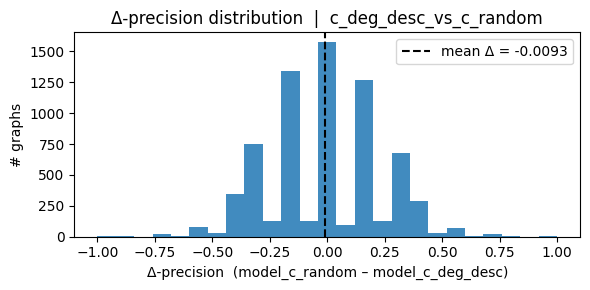

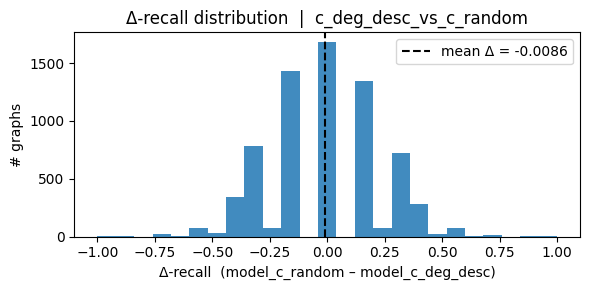

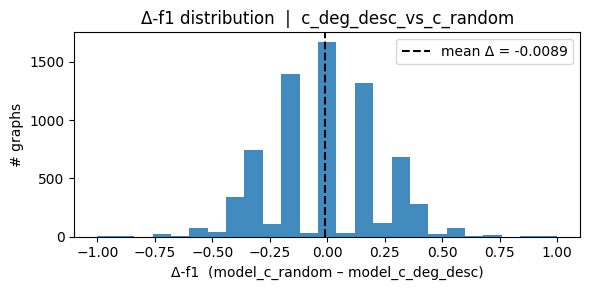

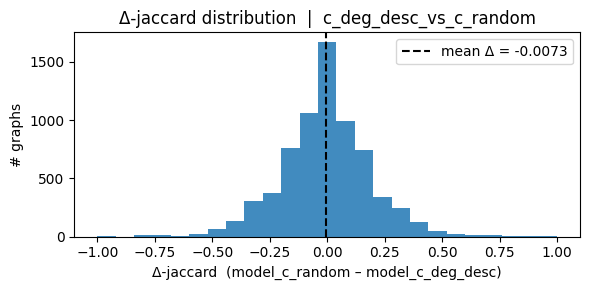

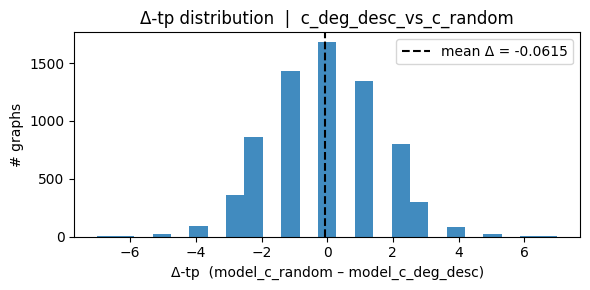

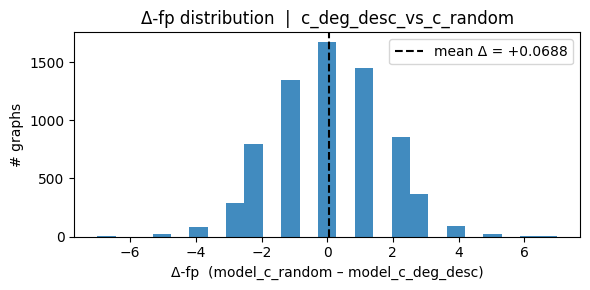

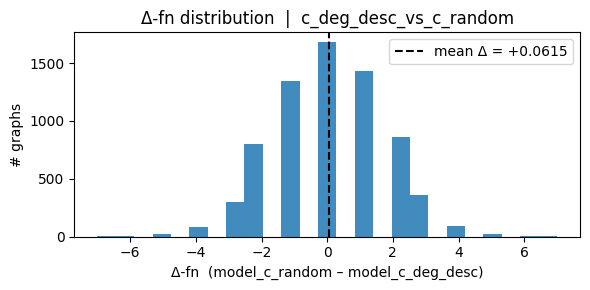

✔  Saved per-graph CSV, per-metric Δ-histograms, and summary to: /home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/c_deg_desc_vs_c_random


In [29]:
compare_models_metrics(
    model_constraints_deg_desc, model_constraints_random, test_dataloader,
    metrics=("precision", "recall", "f1", "jaccard", "tp", "fp", "fn")
)

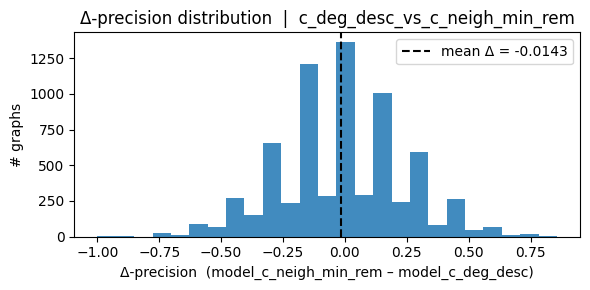

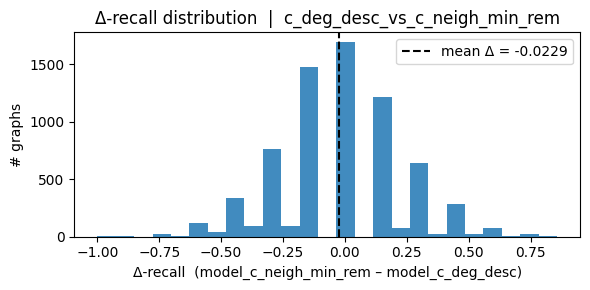

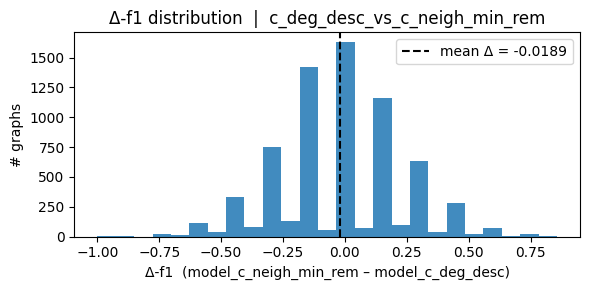

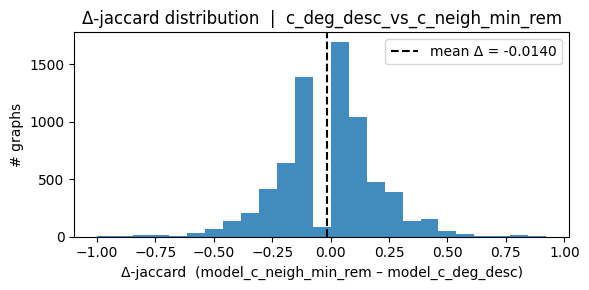

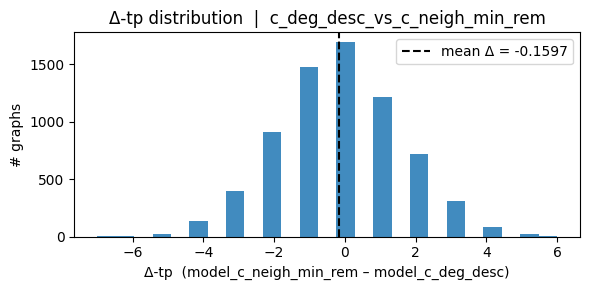

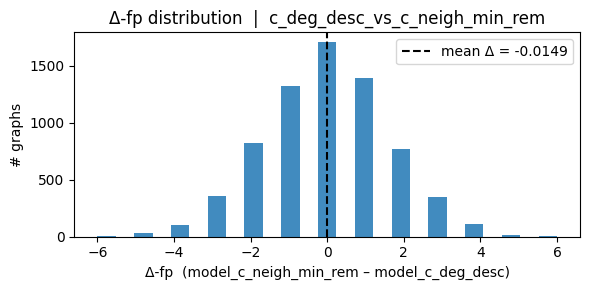

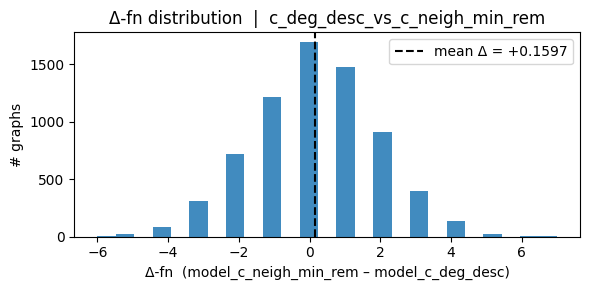

✔  Saved per-graph CSV, per-metric Δ-histograms, and summary to: /home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/c_deg_desc_vs_c_neigh_min_rem


In [34]:
compare_models_metrics(
    model_constraints_deg_desc, model_constraints_neigh_min_rem, test_dataloader,
    metrics=("precision", "recall", "f1", "jaccard", "tp", "fp", "fn")
)


== Counts by face count ==
winner   B_better  A_better  tie
n_nodes                         
6               8         6   13
7              40        50   23
8             170       184   64
9             969      1101  451
10           1505      1665  738

== Percentages by face count ==
winner   B_better  A_better   tie
n_nodes                          
6            29.6      22.2  48.1
7            35.4      44.2  20.4
8            40.7      44.0  15.3
9            38.4      43.7  17.9
10           38.5      42.6  18.9

== Delta stats by face count (positive = model B better) ==
         mean_delta  median_delta  std_delta  n_graphs
n_nodes                                               
6            0.0201           0.0     0.1822        27
7           -0.0437           0.0     0.2542       113
8           -0.0116           0.0     0.2839       418
9           -0.0195           0.0     0.2497      2521
10          -0.0106           0.0     0.2409      3908


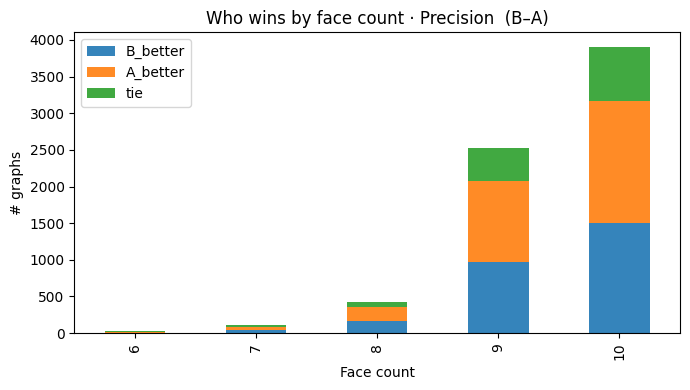

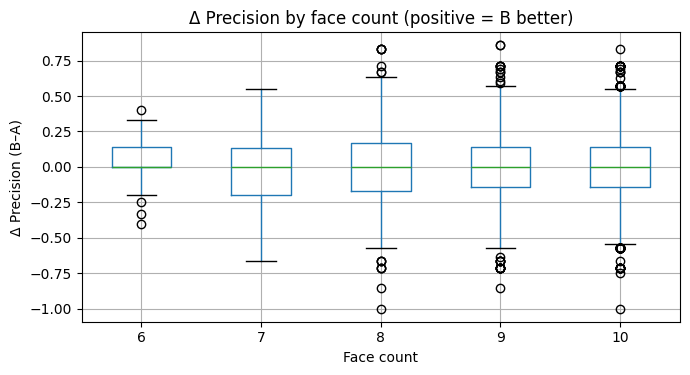

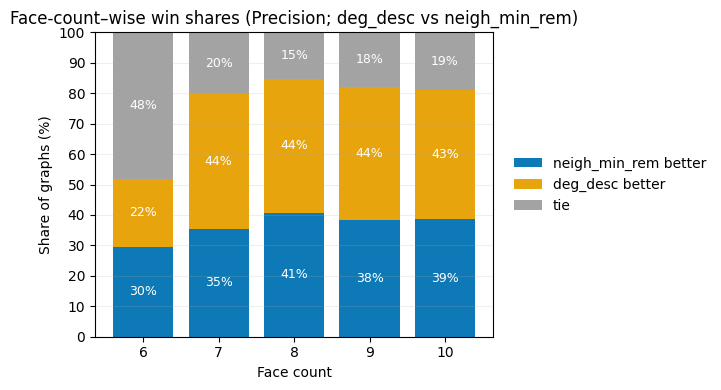

In [35]:
csv_path = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/c_deg_desc_vs_c_neigh_min_rem/c_deg_desc_vs_c_neigh_min_rem_per_graph_metrics.csv"
out_dir = "/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/c_deg_desc_vs_c_neigh_min_rem"
counts, perc, delta_stats, means = breakdown_by_facecount(
    csv_path,
    metric="Precision",
    tie_tol=0.0,
    plot=True,
    output_dir=out_dir,
    model_A_label="deg_desc", model_B_label="neigh_min_rem"
)

### Case study on specific structures

#### Helper functions

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import os, json, pathlib, math, itertools, collections
import numpy as np, pandas as pd
import matplotlib as mpl
import networkx as nx           # only for the visual helper
import torch
from matplotlib.ticker import MultipleLocator

def get_undirected_edges(edge_set):
    """Ensure that edges are stored in a single undirected format."""
    return {tuple(sorted(edge)) for edge in edge_set}

def convert_edges_to_int(edge_set):
    return [tuple(int(x) for x in edge) for edge in edge_set]

def visualize_graph_comparison(unfolded_graph, folded_graph, predicted_graph, title="Graph Comparison", show_visualization=True, print_stats=False, ax=None, layout="spring", layout_scale=3.0):
    """
    Visualizes the unfolded input graph, ground-truth folded graph, and predicted graph.
    Edges are color-coded to indicate their classification:
    - **Black** → Input edges (unfolded input graph)
    - **Green** → Correctly predicted edges (in both ground-truth and predicted graph, but not in input)
    - **Orange** → Missing edges (should be present but were not predicted)
    - **Red** → False positive edges (incorrectly predicted)

    Parameters:
        unfolded_graph : dgl.DGLGraph
        folded_graph   : dgl.DGLGraph
        predicted_graph: dgl.DGLGraph
        title          : figure / axes title
        show_visualization
            If False the function only computes the edge sets and returns;
            nothing is drawn (useful for debugging or tests).
        print_stats
            Verbose console summary of the four edge categories.
        ax : matplotlib.axes.Axes or None, default None
            • None  → create a new (8×8 in) figure and axes.  
            • Axes  → draw into this axes (no new figure is opened).
    """

    # Convert adjacency matrices for debugging
    A_unfolded = adjacency_matrix_from_dgl(unfolded_graph)
    A_folded = adjacency_matrix_from_dgl(folded_graph)
    A_predicted = adjacency_matrix_from_dgl(predicted_graph)
    
    # print("Folded Adjacency matrix:")
    # print(A_folded)
    # print("Predicted Adjacency matrix:")
    # print(A_predicted)
    
    # Move graphs to CPU first
    predicted_graph = predicted_graph.cpu()
    unfolded_graph = unfolded_graph.cpu()
    folded_graph = folded_graph.cpu()

    # Convert DGL graphs to NetworkX
    G_unfolded = unfolded_graph.to_networkx()
    G_folded = folded_graph.to_networkx()
    G_predicted = predicted_graph.to_networkx()

    # Extract edge sets
    unfolded_edges = set(G_unfolded.edges())  # Input edges (black)
    true_edges = set(G_folded.edges())        # Ground truth edges
    predicted_edges = set(G_predicted.edges()) # Model predictions
    
    # --- make them undirected first ------------------------------
    unfolded_edges_undir = get_undirected_edges(unfolded_edges)
    true_edges_undir  = get_undirected_edges(true_edges)
    predicted_edges_undir  = get_undirected_edges(predicted_edges)
    
    # === Per-node edge comparison ===
    if print_stats:
        print("\n🔍 Per-node edge count match (Predicted vs Folded):")
        print(f"{'Node':>5} | {'Match':>7}")
        print("-" * 18)

        for node_id in range(unfolded_graph.num_nodes()):
            deg_predicted = A_predicted[node_id].sum().item()
            deg_folded = A_folded[node_id].sum().item()
            print("Node id: ", node_id, "Deg folded: ", deg_folded, "Deg predicted: ", deg_predicted)

            match = "✅" if deg_predicted == deg_folded else "❌"
            print(f"{node_id:5d} | {match:>7}")

    # Classify edges while maintaining correct priority
    input_edges = unfolded_edges_undir # Already present edges (black)
    correct_edges = (true_edges_undir & predicted_edges_undir) - unfolded_edges_undir # Correctly predicted but NOT in input (green) # These are TRUE-POSITIVES
    missing_edges = true_edges_undir - predicted_edges_undir # Should be there but missing (orange) # FALSE_NEGATIVES
    false_positive_edges = (predicted_edges_undir - true_edges_undir) - unfolded_edges_undir # Wrongly predicted but NOT in input (red) # FALSE-POSITIVES
    
    if True: # Adapt this to investigate different Polyhedra "classes"
        
        # === Print Edge Classification Summary ===
        if print_stats:
            print("-" * 60)
            print(f"\n📊 Edge Classification Summary for graph with {unfolded_graph.num_nodes()} nodes:")
            print(f"  ◼️ Input Edges (Black): {len(input_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(input_edges))}")
            print(f"  ✅ Correctly Predicted Edges (Green): {len(correct_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(correct_edges))}")
            print(f"  ⚠️  Missing Edges (Orange): {len(missing_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(missing_edges))}")
            print(f"  ❌ False Positive Edges (Red): {len(false_positive_edges)}")
            print(f"     ➤ {convert_edges_to_int(sorted(false_positive_edges))}")
            
            # if print_stats:
            # print(f"📊 Edge-level rates for a {unfolded_graph.num_nodes()}-node graph:")
            # print(f"  ✅ Recall (TP / TP+FN)         : {recall_percent:.2%}")
            # print(f"  ⚠️ Miss rate (FN / TP+FN)       : {miss_percent:.2%}")
            # print(f"  ❌ Over-prediction (FP / TP+FP) : {overpred_percent:.2%}")
        
        if show_visualization:
            # target axes ────────────────────────────────────────────────────
            own_fig = False
            if ax is None:                         # called stand-alone
                fig, ax = plt.subplots(figsize=(6, 6))
                own_fig = True                    # so we can show() at the end

            # Initialize visualization graph
            G_combined = nx.Graph()
            G_combined.add_nodes_from(G_folded.nodes())  # Add all nodes

            edge_list = []
            edge_colors = []

            # Add edge and explicitly maintain the correct (source, destination) connections
            def add_edges(edge_set, color):
                """Helper function to add edges while ensuring correct (source, destination) pairs."""
                for edge in edge_set:
                    src, dst = edge  # Explicitly extract source and destination
                    if (src, dst) not in G_combined.edges and (dst, src) not in G_combined.edges:
                        G_combined.add_edge(src, dst)
                        edge_list.append((src, dst))
                        edge_colors.append(color)

            # **Fix: Ensure correct order and priority while adding edges**
            add_edges(input_edges, "black")  # Input edges first
            add_edges(correct_edges, "green")  # Correctly predicted edges
            add_edges(missing_edges, "orange")  # Missing edges
            add_edges(false_positive_edges, "red")  # False positives
            
            sorted_nodes = sorted(G_combined.nodes())  # Force consistent ordering
            
            if layout == "circular":
                pos = nx.circular_layout(G_combined, scale=layout_scale) # radius ≈ scale
            else: # fallback ⇢ spring
                pos = nx.spring_layout(G_combined, seed=42, k=0.5)
            
            pos = {node: pos[node] for node in sorted_nodes}  # Explicit mapping of positions

            # Draw nodes first to ensure correct positioning
            nx.draw_networkx_nodes(G_combined, pos, node_color="lightblue", node_size=500, ax=ax)

            # Draw edges explicitly by referring to sorted node list
            for edge, color in zip(edge_list, edge_colors):
                style = "dashed" if color == "orange" else "solid"
                nx.draw_networkx_edges(G_combined, pos, edgelist=[edge], edge_color=color, width=2, ax=ax, style=style)

            edge_labels = {(u, v): f"{u}-{v}" for u, v in edge_list}
            nx.draw_networkx_edge_labels(G_combined, pos, edge_labels=edge_labels, font_size=8, ax=ax)
            
            nx.draw_networkx_labels(G_combined, pos, ax=ax)
            
            # Create a legend
            legend_patches = [
                plt.Line2D([0], [0], color="black", lw=2, label="Input"),
                plt.Line2D([0], [0], color="green", lw=2, label="Correct"),
                plt.Line2D([0], [0], color="orange", lw=2, ls="--", label="Missing"),
                plt.Line2D([0], [0], color="red", lw=2, label="False Positives"),
            ]
            
            ax.legend(
                handles=legend_patches,
                loc="upper right",
                bbox_to_anchor=(1.05, 0.1),
                borderaxespad=0.0,
                frameon=False,
                fontsize=8
            )
            ax.set_title(title)
            ax.set_axis_off()

            # only show() if ax is None
            if own_fig:
                plt.show()

# ----------------------------------------------------------------------
# ========== helper 1 – build heat-map arrays ==========================
# ----------------------------------------------------------------------
def build_candidate_heatmap(pred_dict, true_undir, n_nodes):
    """
    Return  P, M, chosen, star_coords, src_seq, gt_list
    """
    dest_probs = pred_dict["dest_probs"]
    dest_cands = pred_dict["dest_candidates"]
    dest_cands_mask_deg0 = pred_dict.get("dest_candidates_mask_degzero", [])
    dest_cands_mask_exist = pred_dict.get("dest_candidates_mask_existing", [])
    pred_actions = pred_dict["pred_actions"]

    K = len(dest_probs)
    P = np.full((K, n_nodes), np.nan)
    M = np.zeros_like(P, dtype=bool)
    chosen  = np.full(K, -1, dtype=int)
    closed = np.zeros_like(P, dtype=bool) # deg_rem == 0
    present = np.zeros_like(P, dtype=bool) # already-exists
    
    src_seq = np.full(K, -1, dtype=int)
    star_coords = [] # all stars
    
    gt_list = [[] for _ in range(K)]

    from collections import defaultdict, deque
    gt_by_node = defaultdict(deque)
    for u,_,v in true_undir:
        gt_by_node[u].append(v)

    for k, ((src,flag,dest_pred), probs, cands) in enumerate(
            zip(pred_actions, dest_probs, dest_cands)):
        
        src_seq[k] = src

        # fill P and mask
        for j,node_id in enumerate(cands):
            P[k,node_id] = probs[j]
            M[k,node_id] = True

        # closed (budget-exhausted): only meaningful with constraints
        if k < len(dest_cands_mask_deg0) and dest_cands_mask_deg0[k]:
            for node_id in dest_cands_mask_deg0[k]:
                closed[k, node_id] = True
        
        if k < len(dest_cands_mask_exist):
            for node_id in dest_cands_mask_exist[k]:
                present[k, node_id] = True
            
        # model pick
        if dest_pred is not None:
            chosen[k] = dest_pred

        # ----------- ground-truth info ---------------------------------
        if gt_by_node[src]:

            # 2) put a star for *every* still-missing neighbour
            for tgt in gt_by_node[src]:
                star_coords.append((k, tgt))
                gt_list[k].append(tgt)

        # consume queue if edge predicted correctly
        if dest_pred in gt_by_node[src]:
            gt_by_node[src].remove(dest_pred)
        if src in gt_by_node[dest_pred]:
            gt_by_node[dest_pred].remove(src)

    return P, M, closed, present, chosen, star_coords, src_seq, gt_list

# ----------------------------------------------------------------------
# ========== helper 2 – draw sub-plots B,C,D ===========================
# ----------------------------------------------------------------------
def add_heatmap(ax, P, M, closed, present, chosen, star_coords, src_seq):
    # --- base heat-map ----------------------------------------------------
    cmap = mpl.cm.get_cmap("Reds").copy()
    cmap.set_bad("#eeeeee")
    ax.imshow(P, vmin=0, vmax=1, cmap=cmap,
              origin="lower", aspect="auto")

    # --- light-yellow highlight for the focus node column
    focus_mask = np.full_like(P, np.nan)
    for k, src in enumerate(src_seq):
        focus_mask[k, src] = 1
    ax.imshow(focus_mask,
              cmap=mpl.colors.ListedColormap(["#fff6b2"]),
              origin="lower", aspect="auto", zorder=1.5)
    
    # --- dark-grey overlay for already exhausted candidates => only when running with constraints ------------------------
    if np.any(closed):
        ax.imshow(np.where(closed, 1, np.nan),
                cmap=mpl.colors.ListedColormap(["#666666"]),
                origin="lower", aspect="auto")
    
    # --- slate-blue overlay for already-connected candidates ------------------------
    ax.imshow(np.where(present, 1, np.nan),
              cmap=mpl.colors.ListedColormap(["#6c7bd4"]),
              origin="lower", aspect="auto")

    # --- ground-truth stars  (one per missing neighbour) -----------------
    if star_coords:
        ys, xs = zip(*star_coords)
        ax.scatter(xs, ys, marker="*", s=55,
                   c="limegreen", edgecolors="k", zorder=3)

    # --- model’s pick  (yellow outline) ----------------------------------
    for k, dest in enumerate(chosen):
        if dest == -1:
            continue
        rect = mpl.patches.Rectangle((dest-0.5, k-0.5), 1, 1,
                                     lw=2.0, edgecolor="yellow",
                                     facecolor="none", zorder=4)
        ax.add_patch(rect)

    # --- focus/source node  (blue diamond) -------------------------------
    ax.scatter(src_seq,
           np.arange(len(src_seq)),
           marker="D", s=55,
           facecolors="tab:purple",
           edgecolors="white",
           linewidths=1.2,
           zorder=5)

    # cosmetics ------------------------------------------------------------
    ax.set_xlabel("candidate node id")
    ax.set_ylabel("step k")
    ax.set_xticks(range(P.shape[1]))
    ax.set_yticks(range(P.shape[0]))
    ax.set_ylim(-0.5, P.shape[0]-0.5)

def add_rank_conf(ax_rank, ax_conf, P, M, chosen, gt_list):
    """
    ax_rank … left-hand y-axis  – best rank(true)
              • blue line  …… GT node was in the candidate list
              • red “X”   …… every still-missing GT node was masked out
    ax_conf … right-hand y-axis – chosen p (%)
    """

    best_rank, conf = [], []
    x_masked = []                       # x-coords where every GT node is masked

    # ------------------------------------------------------------------ #
    #  collect data                                                      #
    # ------------------------------------------------------------------ #
    for k in range(len(P)):
        # chosen-edge probability ---------------------------------------
        conf.append(P[k, chosen[k]] if chosen[k] != -1 else np.nan)

        # best rank(true) ----------------------------------------------
        cand_ranks = []
        for tgt in gt_list[k]:
            if not M[k, tgt]:                 # ← this GT node was masked out
                continue
            order   = np.argsort(P[k][~np.isnan(P[k])])[::-1]
            abs_ids = np.arange(P.shape[1])[~np.isnan(P[k])]
            r = (abs_ids[order] == tgt).nonzero()[0][0] + 1
            cand_ranks.append(r)

        if cand_ranks:                        # at least one GT node visible
            best_rank.append(min(cand_ranks))
        elif gt_list[k]:                      # GT exists but all masked
            best_rank.append(np.nan)          # will draw a red “X” instead
            x_masked.append(k)
        else:                                 # no GT left for this source
            best_rank.append(np.nan)

    ks = np.arange(len(P))

    # ------------------------------------------------------------------ #
    #  plotting                                                          #
    # ------------------------------------------------------------------ #
    c_rank = "tab:blue"
    c_conf = "tab:orange"
    c_mask = "tab:red"

    # blue line ---------------------------------------------------------
    ax_rank.plot(ks, best_rank, "o-", color=c_rank, label="rank (true)")
    ax_rank.set_ylabel("rank (true)", color=c_rank)
    ax_rank.tick_params(axis="y", colors=c_rank)
    ax_rank.invert_yaxis()

    # ------------------------ axis limits for RANK --------------------
    finite_r = np.asarray(best_rank)[np.isfinite(best_rank)]
    ymax = int(finite_r.max()) if finite_r.size else 1          # worst rank
    pad_top, pad_bot = 0.3, 0.7                                # extra space
    ax_rank.set_ylim(ymax + pad_bot, 1 - pad_top)
    ax_rank.yaxis.set_major_locator(MultipleLocator(1))        # ticks every 1

    # red “×” markers ---------------------------------------------------
    if x_masked:
        ax_rank.scatter(
            x_masked,
            [ymax + 0.25]*len(x_masked),           # inside bottom margin
            marker="x", s=70, linewidths=2, color=c_mask,
            label="GT masked-out"
        )

    # ----------------------- confidence line --------------------------
    ax_conf.plot(ks, np.array(conf) * 100, "s-", color=c_conf,
                 label="chosen p (%)")
    ax_conf.set_ylabel("chosen p (%)", color=c_conf)
    ax_conf.tick_params(axis="y", colors=c_conf)

    # axis limits with ± 2 % padding
    pad_conf = 2.0
    ax_conf.set_ylim(-pad_conf, 100 + pad_conf)

    ax_conf.set_xlabel("step k")

    # (optional) combined legend
    # lines  = ax_rank.get_lines() + ax_conf.get_lines()
    # labels = [l.get_label() for l in lines]
    # ax_rank.legend(lines, labels, loc="upper left")

def add_outcome_strip(ax, pred_actions, true_undir):
    colors = {"TP":"#2ca02c", "FN":"#ff7f0e", "FP":"#d62728", "STOP":"black"}
    for k,(s,flag,d) in enumerate(pred_actions):
        if flag==0 or d is None:
            c = colors["STOP"]
        elif (s,1,d) in true_undir:
            c = colors["TP"]
        elif (s,1,d) not in true_undir and d is not None:
            if frozenset((s,d)) in {frozenset((u,v)) for u,_,v in true_undir}:
                c = colors["FN"]   # wrong direction (rare)
            else:
                c = colors["FP"]
        ax.add_patch(mpl.patches.Rectangle((k,0),1,1,color=c))
    ax.set_xlim(0, len(pred_actions))
    ax.set_ylim(0,1)
    ax.axis("off")

#### Main function

In [ ]:
def run_case_study(models, dataset, data_loader, out_dir="/home/nschmitz/GNNs/MasterThesisGNN/SavedModels/model_comparisons/case_studies/",
                   save_components=("A","B","C","D"), show_inline=False):
    """
    models         – list of tuples  (tag , loaded_DGMG)
    data_loader    – any torch DataLoader yielding  (unfolded , folded , …)
    out_dir        – folder where PNGs + JSONs go
    save_components – iterable of "A"…"D" to include (for quick drafts)
    """
    out_dir = pathlib.Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    for tag, model in models:
        model.eval()

    for g_unfold, g_fold, g_true_actions, gid in data_loader:
        gid = int(gid[0])
        g_unfold = g_unfold.to(device)
        g_fold = g_fold.to(device)
        source_file_id = str(dataset.get_source_file(gid))
        
        print(f"Current graph-structure: {source_file_id}")
        filefolder = out_dir / f"structure_{source_file_id}"
        filefolder.mkdir(exist_ok=True)
        gfolder = filefolder / f"graph_{gid}"
        gfolder.mkdir(exist_ok=True)
        
        for tag, model in models:
            with torch.no_grad():
                pred = model(g=g_unfold, actions=None, enable_tracking=True)
            
            fig = plt.figure(figsize=(6,9))
            gs  = fig.add_gridspec(4,1, height_ratios=[5,3,2,0.25])

            axA = fig.add_subplot(gs[0]) if "A" in save_components else None
            axB = fig.add_subplot(gs[1]) if "B" in save_components else None
            axC = fig.add_subplot(gs[2]) if "C" in save_components else None
            axD = fig.add_subplot(gs[3]) if "D" in save_components else None

            # --- subplot A -------------------------------------------------
            if axA:
                visualize_graph_comparison(g_unfold, g_fold, pred["generated_graph"],
                            title=f"{tag} | graph: {gid}",
                            show_visualization=True,
                            print_stats=False,
                            ax=axA,
                            layout="circular",
                            layout_scale=8)

            # --- subplot B,C,D ---------------------------------------------
            if any(c in save_components for c in "BCD"):
                true_list = g_true_actions[0]  # batch_actions in your loader
                true_undir = {(s,1,d) for s,flag,d in true_list if flag==1 and d is not None} \
                           | {(d,1,s) for s,flag,d in true_list if flag==1 and d is not None}

                P, M, closed, present, chosen, star_coords, src_seq, gt_list = build_candidate_heatmap(
                                        pred, true_undir, g_unfold.num_nodes())

                if axB:
                    add_heatmap(axB, P, M, closed, present, chosen, star_coords, src_seq)
                    axB.set_title("Candidate-probability heat-map")
                if axC:
                    axC2 = axC.twinx()  # split rank/conf on same row
                    add_rank_conf(axC, axC2, P, M, chosen, gt_list)
                    axC.set_title("Rank & confidence")

                if axD:
                    add_outcome_strip(axD, pred["pred_actions"], true_undir)
                    axD.set_title("Prediction quality timeline")
    
            fig.tight_layout()
            fname = gfolder / f"graph{gid}_{tag}.png"
            fig.savefig(fname, dpi=300)
            if show_inline:
                plt.show()
            plt.close(fig)

            # ---- minimal JSON with metrics -------------------------------
            met = compute_edge_evaluation_metrics(pred["generated_graph"],
                                                  g_unfold.cpu(), g_fold)
            json_out = {
                "source_file": source_file_id,
                "graph_id": gid,
                "model": tag,
                "F1": met["f1_score"],
                "precision": met["precision"],
                "recall": met["recall"]
            }
            with open(gfolder / f"graph_{gid}_{tag}.json", "w") as fh:
                json.dump(json_out, fh, indent=2)
        
        print(f"✓ case-study figures for graph_{gid} saved in  {gfolder.resolve()}")

    print(f"-----\n✓✓ all case-study figures saved in  {out_dir.resolve()}")

In [ ]:
from torch.utils.data import Subset
from dgl.dataloading import GraphDataLoader

idxs = [33966]  # the items you want => 31362 for NEIGH_MIN_REM better than DEG_DESC
one_item_ds = Subset(dataset, idxs)
one_item_loader = GraphDataLoader(
    one_item_ds,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=0,
)

In [ ]:
case_study_models = [
    ("constraints_random", model_constraints_random),
    ("constraints_round_robin",  model_constraints_round_robin),
    ("constraints_deg_desc",  model_constraints_deg_desc),
    ("constraints_neigh_min_rem",  model_constraints_neigh_min_rem),
]

# one_sample_loader = [next(iter(val_dataloader))]
run_case_study(case_study_models, dataset, one_item_loader, show_inline=True)

In [ ]:
from datetime import datetime
print("✅ Code finished successfully at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))